In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(forecast)
library(LaplacesDemon)
library(reshape)
library(gsynth)
library(readxl)
library(reshape)
library(lubridate)
library(zoo)
library(MASS)
library(doParallel)
library(foreach)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘LaplacesDemon’


The following object is masked from ‘package:forecast’:

    is.constant



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:LaplacesDemon’:

    dst, interval


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The followin

In [2]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [3]:
source('../causal_inference_methods_code.R')

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


Loaded glmnet 3.0-2




In [4]:
list.files()

[1] "Assess Effect of Michael Leaving.ipynb"   
[2] "big tv rating data.csv"                   
[3] "IMDb Rating Cleaning.ipynb"               
[4] "Office Ratings (with Michael Leaving).pdf"
[5] "plots_and_tables"                         
[6] "tv rating data.csv"

In [5]:
max_available_clusters <- detectCores()-1
  
desired_clusters <- 4
  
cl <- makeCluster(min(c(max_available_clusters, desired_clusters)))

registerDoParallel(cl)

In [6]:
officeCode <- 'tt0386676'

In [7]:
tvData = read.csv("big tv rating data.csv")

orderedTvData <- tvData %>% arrange(Title, Episode.Number)

orderedTvData <- orderedTvData %>% mutate(
    condensedNumber=rep(1:50, length(unique(tvData$Code))))

In [8]:
Y <- variableExpander(orderedTvData[, c('Title', 'condensedNumber', 'Rating')],
                unitKey='Title', timeKey='condensedNumber')


D <- variableExpander(orderedTvData[, c('Title', 'condensedNumber', 'main_character_left')],
                unitKey='Title', timeKey='condensedNumber')

In [13]:
#chosenSeries <- orderedTvData %>% filter(Title %in% c("Avatar: The Last Airbender", "The Legend of Korra",
#    "The X Files", "Samurai Jack", "Community", "The Office"))

chosenSeries <- orderedTvData %>% filter(Title %in% c("The Office", "Community", 
                                                      "Parks and Recreation", "Superstore",
                                                     "The Mindy Project",
                                                     "Psych"))

panelDataExample <- ggplot(chosenSeries, aes(x=condensedNumber, y=Rating, col=Title)) + geom_line(lwd=1.25)  +
theme_bw(base_size=20) + 
facet_wrap(~Title, scales='free') + xlab("Time") + 
ggtitle("Ratings for Comedies on IMDb") + guides(col=FALSE)

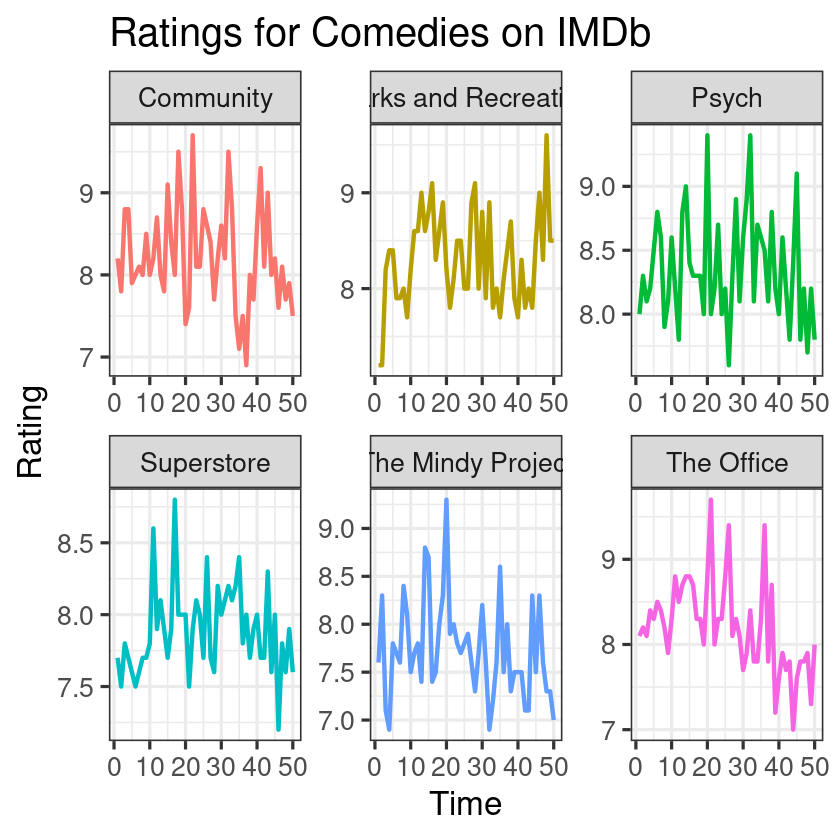

In [14]:
panelDataExample

# Method Performance Assessment

In [15]:
goodPoints <- which(colSums(D)==0)

numberOfPointsToBLockOut <- min(13, max(rowSums(D)))

allNonMissingY <- Y[, goodPoints]

print(paste("Number of shows:", dim(Y)[1]))

[1] "Number of shows: 691"


In [45]:
# dim(allNonMissingY)[1]

numberOfShowsToAssess <- dim(allNonMissingY)[1]


tvRatingErrorMatrix <- array(NA, dim=c(5, 1, numberOfShowsToAssess))

methodNames <- c("Synthetic Control", "Generalized Synthetic Control", 
                "Synthetic Difference in Differences", 'MC-NNM', 'LAPIS')

dimnames(tvRatingErrorMatrix) <- c(list(methodNames),list('MSE'),
                                   list(dimnames(allNonMissingY)[[1]][1:numberOfShowsToAssess]))

indic <- 1

for (tvShow in rownames(allNonMissingY)[1:numberOfShowsToAssess]){
    
    aNewD <- array(0, dim=dim(allNonMissingY))
    
    dimnames(aNewD) <- dimnames(allNonMissingY)
    
    blockOutSequence <- (dim(aNewD)[2]-numberOfPointsToBLockOut+1):dim(aNewD)[2]
    
    aNewD[tvShow, blockOutSequence] <- 1
    
    meltedD <- melt(aNewD) 

    names(meltedD) <- c('id', 'time', 'treated')

    meltedObservedData <- melt(allNonMissingY)

    names(meltedObservedData) <- c('id', 'time', 'rating')

    joinedDataForGsynth <- meltedD %>% inner_join(meltedObservedData)
    
    #joinedDataForGsynth$id <- as.character(joinedDataForGsynth$id)
    
    joinedDataForGsynth$id <- as.numeric(joinedDataForGsynth$id)
    
    synthContEst <- synth_cont(Y=allNonMissingY, W=aNewD)
    
    mcnnm_info <- matrix_completion_causal(Y=allNonMissingY, W=aNewD)

    mcnnm_est <- treat.estimator(allNonMissingY, mcnnm_info$L_hat, aNewD)
    
    #r=rankMatrix(mcnnm_info$L_hat)[1]
    gsynthInfo <- tryCatch(gsynthInfo <- gsynth(rating~treated, data=joinedDataForGsynth, 
                                                                 index=c('id', 'time'), 
                         parallel = FALSE), 
                           error = function(e) 'Bad try')
                           
    if (length(gsynthInfo) != 1){

        gsynthContEst <- gsynthInfo$att
        
        Time0 <- max(which(aNewD[tvShow,  ]==0))
        
        tau_estimate_gsynth <- gsynthInfo$att

        relevantgsynthcontEst <- gsynthContEst[(Time0+1):dim(aNewD)[2]]
        
        }else{
        
       relevantgsynthcontEst <-  synthContEst
    }
    
    
    SDIDEstimate <- SDID_general(Y=allNonMissingY, W=aNewD,
                     iterations_for_coord_desc=100)

    
    
    lapisEstimate <- LAPIS_with_rank_estimation(Y=allNonMissingY, W=aNewD,
                           initial_rank=100, tolerance=1e-03, 
                           min_iter=10, max_iter=1000, 
                           mu_grid=c(10^seq(-4,2,1),
                           seq(2,5,1)),
                           warm_start=F, 
                           method='non_explicit_tau',change_memory_length=30,
                           minimum_change=30,
                           num_folds=6)
    
    
   tvMseVec <- c(mean(synthContEst^2),  mean(relevantgsynthcontEst^2), mean(SDIDEstimate^2), 
                 mean(mcnnm_est^2),
                 mean(lapisEstimate^2))
    
   tvRatingErrorMatrix[,,tvShow] <- tvMseVec
                                            
   print(indic)

   indic <- indic+1
    
}

Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23017; MSPE = 0.03622*
 r = 1; sigma2 = 0.26169; IC = -1.05202; MSPE = 0.03756
 r = 2; sigma2 = 0.24733; IC = -0.82069; MSPE = 0.04006
 r = 3; sigma2 = 0.23926; IC = -0.56687; MSPE = 0.04139
 r = 4; sigma2 = 0.23191; IC = -0.31188; MSPE = 0.04389
 r = 5; sigma2 = 0.22605; IC = -0.05211; MSPE = 0.04369

 r* = 0

[1] 1


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23084; MSPE = 0.16422
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.05715*
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.06793
 r = 3; sigma2 = 0.23922; IC = -0.56707; MSPE = 0.07013
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.07309
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.08109

 r* = 1

[1] 2


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29191; IC = -1.23131; MSPE = 0.28157
 r = 1; sigma2 = 0.26137; IC = -1.05324; MSPE = 0.24363
 r = 2; sigma2 = 0.24707; IC = -0.82174; MSPE = 0.23372*
 r = 3; sigma2 = 0.23899; IC = -0.56800; MSPE = 0.24859
 r = 4; sigma2 = 0.23164; IC = -0.31305; MSPE = 0.28180
 r = 5; sigma2 = 0.22578; IC = -0.05331; MSPE = 0.29819

 r* = 2

[1] 3


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23017; MSPE = 0.04718*
 r = 1; sigma2 = 0.26169; IC = -1.05202; MSPE = 0.04847
 r = 2; sigma2 = 0.24733; IC = -0.82069; MSPE = 0.05133
 r = 3; sigma2 = 0.23926; IC = -0.56687; MSPE = 0.06259
 r = 4; sigma2 = 0.23191; IC = -0.31189; MSPE = 0.06544
 r = 5; sigma2 = 0.22604; IC = -0.05215; MSPE = 0.07066

 r* = 0

[1] 4


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23118; MSPE = 0.23070*
 r = 1; sigma2 = 0.26139; IC = -1.05318; MSPE = 0.24633
 r = 2; sigma2 = 0.24705; IC = -0.82182; MSPE = 0.25084
 r = 3; sigma2 = 0.23897; IC = -0.56808; MSPE = 0.27474
 r = 4; sigma2 = 0.23164; IC = -0.31308; MSPE = 0.25948
 r = 5; sigma2 = 0.22578; IC = -0.05331; MSPE = 0.24643

 r* = 0

[1] 5


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29172; IC = -1.23196; MSPE = 0.16877*
 r = 1; sigma2 = 0.26127; IC = -1.05361; MSPE = 0.18303
 r = 2; sigma2 = 0.24700; IC = -0.82202; MSPE = 0.19504
 r = 3; sigma2 = 0.23898; IC = -0.56805; MSPE = 0.18445
 r = 4; sigma2 = 0.23167; IC = -0.31292; MSPE = 0.11547*
 r = 5; sigma2 = 0.22579; IC = -0.05323; MSPE = 0.11929

 r* = 4

[1] 6


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23035; MSPE = 0.04809*
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.05085
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.05075
 r = 3; sigma2 = 0.23922; IC = -0.56705; MSPE = 0.04842
 r = 4; sigma2 = 0.23188; IC = -0.31204; MSPE = 0.04972
 r = 5; sigma2 = 0.22601; IC = -0.05230; MSPE = 0.05534

 r* = 0

[1] 7


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23055; MSPE = 0.12703*
 r = 1; sigma2 = 0.26158; IC = -1.05245; MSPE = 0.13316
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.13993
 r = 3; sigma2 = 0.23916; IC = -0.56729; MSPE = 0.14593
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.15150
 r = 5; sigma2 = 0.22593; IC = -0.05262; MSPE = 0.16211

 r* = 0

[1] 8


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29141; IC = -1.23302; MSPE = 0.51038*
 r = 1; sigma2 = 0.26088; IC = -1.05513; MSPE = 0.52585
 r = 2; sigma2 = 0.24654; IC = -0.82389; MSPE = 0.58000
 r = 3; sigma2 = 0.23845; IC = -0.57026; MSPE = 0.66232
 r = 4; sigma2 = 0.23110; IC = -0.31538; MSPE = 0.69006
 r = 5; sigma2 = 0.22521; IC = -0.05583; MSPE = 0.70689

 r* = 0

[1] 9


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23056; MSPE = 0.11658
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.11531*
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.12092
 r = 3; sigma2 = 0.23919; IC = -0.56718; MSPE = 0.10409*
 r = 4; sigma2 = 0.23183; IC = -0.31223; MSPE = 0.11338
 r = 5; sigma2 = 0.22596; IC = -0.05250; MSPE = 0.12633

 r* = 3

[1] 10


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23128; MSPE = 0.27386
 r = 1; sigma2 = 0.26145; IC = -1.05296; MSPE = 0.22272
 r = 2; sigma2 = 0.24709; IC = -0.82165; MSPE = 0.18308*
 r = 3; sigma2 = 0.23902; IC = -0.56787; MSPE = 0.21483
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.20933
 r = 5; sigma2 = 0.22583; IC = -0.05308; MSPE = 0.23085

 r* = 2

[1] 11


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23105; MSPE = 0.20386
 r = 1; sigma2 = 0.26142; IC = -1.05304; MSPE = 0.19440*
 r = 2; sigma2 = 0.24710; IC = -0.82162; MSPE = 0.19753
 r = 3; sigma2 = 0.23907; IC = -0.56769; MSPE = 0.25019
 r = 4; sigma2 = 0.23171; IC = -0.31274; MSPE = 0.23869
 r = 5; sigma2 = 0.22584; IC = -0.05305; MSPE = 0.23772

 r* = 1

[1] 12


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23053; MSPE = 0.09164*
 r = 1; sigma2 = 0.26158; IC = -1.05244; MSPE = 0.09511
 r = 2; sigma2 = 0.24723; IC = -0.82109; MSPE = 0.09180
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.09593
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.09386
 r = 5; sigma2 = 0.22594; IC = -0.05260; MSPE = 0.10817

 r* = 0

[1] 13


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.13730*
 r = 1; sigma2 = 0.26156; IC = -1.05252; MSPE = 0.13950
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.14432
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.15203
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.15944
 r = 5; sigma2 = 0.22591; IC = -0.05274; MSPE = 0.16941

 r* = 0

[1] 14


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23085; MSPE = 0.11584*
 r = 1; sigma2 = 0.26149; IC = -1.05277; MSPE = 0.12370
 r = 2; sigma2 = 0.24718; IC = -0.82129; MSPE = 0.13266
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.09257*
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.09367
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.09680

 r* = 3

[1] 15


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23199; MSPE = 0.49314
 r = 1; sigma2 = 0.26118; IC = -1.05399; MSPE = 0.49119
 r = 2; sigma2 = 0.24680; IC = -0.82283; MSPE = 0.42312*
 r = 3; sigma2 = 0.23873; IC = -0.56912; MSPE = 0.45698
 r = 4; sigma2 = 0.23140; IC = -0.31412; MSPE = 0.47037
 r = 5; sigma2 = 0.22552; IC = -0.05445; MSPE = 0.49677

 r* = 2

[1] 16


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29226; IC = -1.23010; MSPE = 0.01798*
 r = 1; sigma2 = 0.26172; IC = -1.05191; MSPE = 0.01897
 r = 2; sigma2 = 0.24736; IC = -0.82058; MSPE = 0.02090
 r = 3; sigma2 = 0.23929; IC = -0.56676; MSPE = 0.02228
 r = 4; sigma2 = 0.23194; IC = -0.31177; MSPE = 0.02110
 r = 5; sigma2 = 0.22607; IC = -0.05202; MSPE = 0.02465

 r* = 0

[1] 17


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23086; MSPE = 0.17102
 r = 1; sigma2 = 0.26148; IC = -1.05281; MSPE = 0.15424*
 r = 2; sigma2 = 0.24714; IC = -0.82147; MSPE = 0.16665
 r = 3; sigma2 = 0.23907; IC = -0.56769; MSPE = 0.18524
 r = 4; sigma2 = 0.23171; IC = -0.31276; MSPE = 0.19885
 r = 5; sigma2 = 0.22584; IC = -0.05305; MSPE = 0.21628

 r* = 1

[1] 18


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.07529*
 r = 1; sigma2 = 0.26164; IC = -1.05220; MSPE = 0.08779
 r = 2; sigma2 = 0.24728; IC = -0.82089; MSPE = 0.09543
 r = 3; sigma2 = 0.23921; IC = -0.56708; MSPE = 0.10214
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.08868
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.09009

 r* = 0

[1] 19


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23071; MSPE = 0.14578*
 r = 1; sigma2 = 0.26153; IC = -1.05265; MSPE = 0.16134
 r = 2; sigma2 = 0.24716; IC = -0.82137; MSPE = 0.15860
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.16665
 r = 4; sigma2 = 0.23176; IC = -0.31256; MSPE = 0.15320
 r = 5; sigma2 = 0.22589; IC = -0.05282; MSPE = 0.17057

 r* = 0

[1] 20


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.06924*
 r = 1; sigma2 = 0.26163; IC = -1.05226; MSPE = 0.07090
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.07709
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.08197
 r = 4; sigma2 = 0.23186; IC = -0.31212; MSPE = 0.08834
 r = 5; sigma2 = 0.22599; IC = -0.05235; MSPE = 0.10218

 r* = 0

[1] 21


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23047; MSPE = 0.10887
 r = 1; sigma2 = 0.26160; IC = -1.05237; MSPE = 0.10601*
 r = 2; sigma2 = 0.24724; IC = -0.82104; MSPE = 0.11525
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.10712
 r = 4; sigma2 = 0.23183; IC = -0.31224; MSPE = 0.11681
 r = 5; sigma2 = 0.22596; IC = -0.05251; MSPE = 0.11180

 r* = 1

[1] 22


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23127; MSPE = 0.27766*
 r = 1; sigma2 = 0.26137; IC = -1.05326; MSPE = 0.29966
 r = 2; sigma2 = 0.24700; IC = -0.82202; MSPE = 0.36329
 r = 3; sigma2 = 0.23894; IC = -0.56820; MSPE = 0.35743
 r = 4; sigma2 = 0.23160; IC = -0.31324; MSPE = 0.38540
 r = 5; sigma2 = 0.22573; IC = -0.05350; MSPE = 0.44197

 r* = 0

[1] 23


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23057; MSPE = 0.13671*
 r = 1; sigma2 = 0.26157; IC = -1.05249; MSPE = 0.15072
 r = 2; sigma2 = 0.24721; IC = -0.82118; MSPE = 0.16625
 r = 3; sigma2 = 0.23914; IC = -0.56740; MSPE = 0.16448
 r = 4; sigma2 = 0.23178; IC = -0.31245; MSPE = 0.18847
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.17633

 r* = 0

[1] 24


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23074; MSPE = 0.08754*
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.09581
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.11815
 r = 3; sigma2 = 0.23915; IC = -0.56734; MSPE = 0.12480
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.12900
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.13097

 r* = 0

[1] 25


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23108; MSPE = 0.19206*
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.19358
 r = 2; sigma2 = 0.24713; IC = -0.82151; MSPE = 0.20245
 r = 3; sigma2 = 0.23906; IC = -0.56770; MSPE = 0.20966
 r = 4; sigma2 = 0.23172; IC = -0.31273; MSPE = 0.22220
 r = 5; sigma2 = 0.22586; IC = -0.05297; MSPE = 0.25079

 r* = 0

[1] 26


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29222; IC = -1.23024; MSPE = 0.03355*
 r = 1; sigma2 = 0.26168; IC = -1.05206; MSPE = 0.03759
 r = 2; sigma2 = 0.24732; IC = -0.82072; MSPE = 0.04024
 r = 3; sigma2 = 0.23925; IC = -0.56691; MSPE = 0.04320
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.04395
 r = 5; sigma2 = 0.22603; IC = -0.05218; MSPE = 0.04592

 r* = 0

[1] 27


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29191; IC = -1.23130; MSPE = 0.32527*
 r = 1; sigma2 = 0.26135; IC = -1.05332; MSPE = 0.34466
 r = 2; sigma2 = 0.24698; IC = -0.82211; MSPE = 0.34338
 r = 3; sigma2 = 0.23891; IC = -0.56836; MSPE = 0.38476
 r = 4; sigma2 = 0.23156; IC = -0.31340; MSPE = 0.44141
 r = 5; sigma2 = 0.22568; IC = -0.05373; MSPE = 0.47368

 r* = 0

[1] 28


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29148; IC = -1.23277; MSPE = 0.72378*
 r = 1; sigma2 = 0.26093; IC = -1.05493; MSPE = 0.78392
 r = 2; sigma2 = 0.24655; IC = -0.82385; MSPE = 0.75512
 r = 3; sigma2 = 0.23855; IC = -0.56987; MSPE = 0.64699*
 r = 4; sigma2 = 0.23118; IC = -0.31507; MSPE = 0.70056
 r = 5; sigma2 = 0.22529; IC = -0.05549; MSPE = 0.76827

 r* = 3

[1] 29


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23033; MSPE = 0.07802
 r = 1; sigma2 = 0.26166; IC = -1.05214; MSPE = 0.05419*
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.05965
 r = 3; sigma2 = 0.23924; IC = -0.56698; MSPE = 0.06446
 r = 4; sigma2 = 0.23189; IC = -0.31199; MSPE = 0.04771*
 r = 5; sigma2 = 0.22602; IC = -0.05225; MSPE = 0.05719

 r* = 4

[1] 30


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29079; IC = -1.23517; MSPE = 1.30236*
 r = 1; sigma2 = 0.26046; IC = -1.05676; MSPE = 1.36097
 r = 2; sigma2 = 0.24607; IC = -0.82578; MSPE = 1.30147
 r = 3; sigma2 = 0.23813; IC = -0.57163; MSPE = 1.34051
 r = 4; sigma2 = 0.23074; IC = -0.31697; MSPE = 1.35531
 r = 5; sigma2 = 0.22488; IC = -0.05730; MSPE = 1.56811

 r* = 0

[1] 31


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.05896*
 r = 1; sigma2 = 0.26167; IC = -1.05212; MSPE = 0.06457
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.06879
 r = 3; sigma2 = 0.23924; IC = -0.56699; MSPE = 0.07316
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.07892
 r = 5; sigma2 = 0.22601; IC = -0.05226; MSPE = 0.07917

 r* = 0

[1] 32


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.05444
 r = 1; sigma2 = 0.26166; IC = -1.05213; MSPE = 0.05305*
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.05816
 r = 3; sigma2 = 0.23923; IC = -0.56699; MSPE = 0.06923
 r = 4; sigma2 = 0.23189; IC = -0.31198; MSPE = 0.06749
 r = 5; sigma2 = 0.22602; IC = -0.05224; MSPE = 0.06513

 r* = 1

[1] 33


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29058; IC = -1.23589; MSPE = 0.60474*
 r = 1; sigma2 = 0.25999; IC = -1.05853; MSPE = 0.64611
 r = 2; sigma2 = 0.24568; IC = -0.82737; MSPE = 0.68544
 r = 3; sigma2 = 0.23764; IC = -0.57369; MSPE = 0.79177
 r = 4; sigma2 = 0.23026; IC = -0.31905; MSPE = 0.85629
 r = 5; sigma2 = 0.22435; IC = -0.05965; MSPE = 0.86781

 r* = 0

[1] 34


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23050; MSPE = 0.10042*
 r = 1; sigma2 = 0.26160; IC = -1.05236; MSPE = 0.11018
 r = 2; sigma2 = 0.24724; IC = -0.82106; MSPE = 0.12043
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.11836
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.13263
 r = 5; sigma2 = 0.22596; IC = -0.05250; MSPE = 0.09495

 r* = 5

[1] 35


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23176; MSPE = 0.42737
 r = 1; sigma2 = 0.26133; IC = -1.05342; MSPE = 0.36984*
 r = 2; sigma2 = 0.24696; IC = -0.82217; MSPE = 0.40504
 r = 3; sigma2 = 0.23888; IC = -0.56846; MSPE = 0.42361
 r = 4; sigma2 = 0.23152; IC = -0.31358; MSPE = 0.45720
 r = 5; sigma2 = 0.22564; IC = -0.05394; MSPE = 0.52255

 r* = 1

[1] 36


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23076; MSPE = 0.07121*
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.07757
 r = 2; sigma2 = 0.24721; IC = -0.82119; MSPE = 0.08976
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.09382
 r = 4; sigma2 = 0.23178; IC = -0.31245; MSPE = 0.09856
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.11091

 r* = 0

[1] 37


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29141; IC = -1.23304; MSPE = 0.67501*
 r = 1; sigma2 = 0.26085; IC = -1.05523; MSPE = 0.72052
 r = 2; sigma2 = 0.24646; IC = -0.82419; MSPE = 0.77611
 r = 3; sigma2 = 0.23841; IC = -0.57046; MSPE = 0.80398
 r = 4; sigma2 = 0.23105; IC = -0.31562; MSPE = 0.89381
 r = 5; sigma2 = 0.22523; IC = -0.05575; MSPE = 0.77789

 r* = 0

[1] 38


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23135; MSPE = 0.11476*
 r = 1; sigma2 = 0.26137; IC = -1.05326; MSPE = 0.12114
 r = 2; sigma2 = 0.24712; IC = -0.82155; MSPE = 0.13285
 r = 3; sigma2 = 0.23905; IC = -0.56778; MSPE = 0.13702
 r = 4; sigma2 = 0.23169; IC = -0.31284; MSPE = 0.15471
 r = 5; sigma2 = 0.22583; IC = -0.05307; MSPE = 0.13755

 r* = 0

[1] 39


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23018; MSPE = 0.02601*
 r = 1; sigma2 = 0.26169; IC = -1.05203; MSPE = 0.02809
 r = 2; sigma2 = 0.24733; IC = -0.82070; MSPE = 0.02508*
 r = 3; sigma2 = 0.23926; IC = -0.56688; MSPE = 0.02572
 r = 4; sigma2 = 0.23191; IC = -0.31189; MSPE = 0.02503*
 r = 5; sigma2 = 0.22604; IC = -0.05213; MSPE = 0.02732

 r* = 4

[1] 40


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23057; MSPE = 0.17420
 r = 1; sigma2 = 0.26157; IC = -1.05249; MSPE = 0.17151
 r = 2; sigma2 = 0.24725; IC = -0.82103; MSPE = 0.12832*
 r = 3; sigma2 = 0.23918; IC = -0.56720; MSPE = 0.13314
 r = 4; sigma2 = 0.23184; IC = -0.31219; MSPE = 0.13813
 r = 5; sigma2 = 0.22597; IC = -0.05246; MSPE = 0.14864

 r* = 2

[1] 41


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29229; IC = -1.23002; MSPE = 0.00000*
 r = 1; sigma2 = 0.26173; IC = -1.05186; MSPE = 0.00000
 r = 2; sigma2 = 0.24737; IC = -0.82051; MSPE = 0.00000
 r = 3; sigma2 = 0.23931; IC = -0.56669; MSPE = 0.00000
 r = 4; sigma2 = 0.23196; IC = -0.31170; MSPE = 0.00000
 r = 5; sigma2 = 0.22609; IC = -0.05195; MSPE = 0.00000

 r* = 0

[1] 42


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29145; IC = -1.23289; MSPE = 0.71590
 r = 1; sigma2 = 0.26102; IC = -1.05460; MSPE = 0.69278*
 r = 2; sigma2 = 0.24667; IC = -0.82337; MSPE = 0.72383
 r = 3; sigma2 = 0.23858; IC = -0.56973; MSPE = 0.77198
 r = 4; sigma2 = 0.23125; IC = -0.31475; MSPE = 0.84861
 r = 5; sigma2 = 0.22536; IC = -0.05517; MSPE = 0.94180

 r* = 1

[1] 43


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23055; MSPE = 0.12792*
 r = 1; sigma2 = 0.26158; IC = -1.05246; MSPE = 0.13777
 r = 2; sigma2 = 0.24722; IC = -0.82114; MSPE = 0.14725
 r = 3; sigma2 = 0.23915; IC = -0.56736; MSPE = 0.15703
 r = 4; sigma2 = 0.23180; IC = -0.31239; MSPE = 0.16096
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.19122

 r* = 0

[1] 44


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23123; MSPE = 0.38767
 r = 1; sigma2 = 0.26142; IC = -1.05308; MSPE = 0.28246
 r = 2; sigma2 = 0.24713; IC = -0.82151; MSPE = 0.26205*
 r = 3; sigma2 = 0.23905; IC = -0.56774; MSPE = 0.35252
 r = 4; sigma2 = 0.23172; IC = -0.31273; MSPE = 0.37528
 r = 5; sigma2 = 0.22585; IC = -0.05301; MSPE = 0.40737

 r* = 2

[1] 45


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23034; MSPE = 0.06011*
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.06139
 r = 2; sigma2 = 0.24728; IC = -0.82091; MSPE = 0.06462
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.06987
 r = 4; sigma2 = 0.23185; IC = -0.31214; MSPE = 0.07754
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.08403

 r* = 0

[1] 46


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23089; MSPE = 0.14760
 r = 1; sigma2 = 0.26153; IC = -1.05265; MSPE = 0.05435
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.04585
 r = 3; sigma2 = 0.23916; IC = -0.56731; MSPE = 0.04329*
 r = 4; sigma2 = 0.23180; IC = -0.31237; MSPE = 0.04547
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.05165

 r* = 3

[1] 47


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29177; IC = -1.23180; MSPE = 0.32618*
 r = 1; sigma2 = 0.26121; IC = -1.05388; MSPE = 0.34152
 r = 2; sigma2 = 0.24683; IC = -0.82270; MSPE = 0.37186
 r = 3; sigma2 = 0.23877; IC = -0.56894; MSPE = 0.39155
 r = 4; sigma2 = 0.23140; IC = -0.31410; MSPE = 0.42676
 r = 5; sigma2 = 0.22552; IC = -0.05445; MSPE = 0.48053

 r* = 0

[1] 48


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29155; IC = -1.23253; MSPE = 0.42856*
 r = 1; sigma2 = 0.26102; IC = -1.05460; MSPE = 0.46964
 r = 2; sigma2 = 0.24668; IC = -0.82332; MSPE = 0.51519
 r = 3; sigma2 = 0.23861; IC = -0.56962; MSPE = 0.57953
 r = 4; sigma2 = 0.23124; IC = -0.31480; MSPE = 0.63797
 r = 5; sigma2 = 0.22543; IC = -0.05485; MSPE = 0.63449

 r* = 0

[1] 49


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29161; IC = -1.23235; MSPE = 0.71856
 r = 1; sigma2 = 0.26111; IC = -1.05425; MSPE = 0.66185*
 r = 2; sigma2 = 0.24676; IC = -0.82301; MSPE = 0.80231
 r = 3; sigma2 = 0.23869; IC = -0.56927; MSPE = 0.84411
 r = 4; sigma2 = 0.23134; IC = -0.31435; MSPE = 0.87981
 r = 5; sigma2 = 0.22549; IC = -0.05458; MSPE = 0.58392

 r* = 5

[1] 50


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29167; IC = -1.23214; MSPE = 0.54395*
 r = 1; sigma2 = 0.26114; IC = -1.05414; MSPE = 0.58509
 r = 2; sigma2 = 0.24677; IC = -0.82295; MSPE = 0.58936
 r = 3; sigma2 = 0.23870; IC = -0.56923; MSPE = 0.64076
 r = 4; sigma2 = 0.23133; IC = -0.31441; MSPE = 0.67429
 r = 5; sigma2 = 0.22547; IC = -0.05465; MSPE = 0.71543

 r* = 0

[1] 51


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23035; MSPE = 0.08255
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.07256*
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.07662
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.09062
 r = 4; sigma2 = 0.23185; IC = -0.31214; MSPE = 0.09733
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.10920

 r* = 1

[1] 52


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.15544
 r = 1; sigma2 = 0.26157; IC = -1.05247; MSPE = 0.15030
 r = 2; sigma2 = 0.24721; IC = -0.82117; MSPE = 0.14755*
 r = 3; sigma2 = 0.23914; IC = -0.56738; MSPE = 0.15511
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.16395
 r = 5; sigma2 = 0.22592; IC = -0.05270; MSPE = 0.18086

 r* = 2

[1] 53


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29222; IC = -1.23026; MSPE = 0.03491*
 r = 1; sigma2 = 0.26166; IC = -1.05212; MSPE = 0.03832
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.04056
 r = 3; sigma2 = 0.23923; IC = -0.56700; MSPE = 0.04464
 r = 4; sigma2 = 0.23188; IC = -0.31203; MSPE = 0.04810
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.05405

 r* = 0

[1] 54


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23138; MSPE = 0.17028*
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.18496
 r = 2; sigma2 = 0.24710; IC = -0.82162; MSPE = 0.19021
 r = 3; sigma2 = 0.23903; IC = -0.56785; MSPE = 0.19858
 r = 4; sigma2 = 0.23167; IC = -0.31292; MSPE = 0.21065
 r = 5; sigma2 = 0.22580; IC = -0.05321; MSPE = 0.23119

 r* = 0

[1] 55


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23067; MSPE = 0.05533
 r = 1; sigma2 = 0.26155; IC = -1.05257; MSPE = 0.03806
 r = 2; sigma2 = 0.24724; IC = -0.82106; MSPE = 0.03688*
 r = 3; sigma2 = 0.23917; IC = -0.56727; MSPE = 0.03981
 r = 4; sigma2 = 0.23182; IC = -0.31227; MSPE = 0.03508*
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.03929

 r* = 4

[1] 56


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23077; MSPE = 0.17510*
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.18278
 r = 2; sigma2 = 0.24716; IC = -0.82139; MSPE = 0.20063
 r = 3; sigma2 = 0.23909; IC = -0.56760; MSPE = 0.23053
 r = 4; sigma2 = 0.23173; IC = -0.31267; MSPE = 0.24744
 r = 5; sigma2 = 0.22586; IC = -0.05296; MSPE = 0.26418

 r* = 0

[1] 57


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23079; MSPE = 0.21958*
 r = 1; sigma2 = 0.26151; IC = -1.05273; MSPE = 0.23922
 r = 2; sigma2 = 0.24715; IC = -0.82143; MSPE = 0.27094
 r = 3; sigma2 = 0.23907; IC = -0.56767; MSPE = 0.29179
 r = 4; sigma2 = 0.23173; IC = -0.31270; MSPE = 0.30632
 r = 5; sigma2 = 0.22585; IC = -0.05299; MSPE = 0.36494

 r* = 0

[1] 58


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23071; MSPE = 0.13336*
 r = 1; sigma2 = 0.26153; IC = -1.05262; MSPE = 0.14198
 r = 2; sigma2 = 0.24717; IC = -0.82132; MSPE = 0.11965*
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.13127
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.14720
 r = 5; sigma2 = 0.22588; IC = -0.05287; MSPE = 0.16915

 r* = 2

[1] 59


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29094; IC = -1.23465; MSPE = 0.97263
 r = 1; sigma2 = 0.26043; IC = -1.05684; MSPE = 0.93783*
 r = 2; sigma2 = 0.24617; IC = -0.82541; MSPE = 0.95992
 r = 3; sigma2 = 0.23806; IC = -0.57191; MSPE = 1.04575
 r = 4; sigma2 = 0.23069; IC = -0.31717; MSPE = 0.97823
 r = 5; sigma2 = 0.22480; IC = -0.05767; MSPE = 1.10277

 r* = 1

[1] 60


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23023; MSPE = 0.05505
 r = 1; sigma2 = 0.26168; IC = -1.05208; MSPE = 0.05094*
 r = 2; sigma2 = 0.24732; IC = -0.82075; MSPE = 0.05790
 r = 3; sigma2 = 0.23925; IC = -0.56694; MSPE = 0.06106
 r = 4; sigma2 = 0.23189; IC = -0.31197; MSPE = 0.06698
 r = 5; sigma2 = 0.22602; IC = -0.05222; MSPE = 0.07375

 r* = 1

[1] 61


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23163; MSPE = 0.30758*
 r = 1; sigma2 = 0.26126; IC = -1.05368; MSPE = 0.34368
 r = 2; sigma2 = 0.24691; IC = -0.82240; MSPE = 0.36618
 r = 3; sigma2 = 0.23883; IC = -0.56870; MSPE = 0.38769
 r = 4; sigma2 = 0.23146; IC = -0.31383; MSPE = 0.44748
 r = 5; sigma2 = 0.22558; IC = -0.05419; MSPE = 0.50383

 r* = 0

[1] 62


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23039; MSPE = 0.05261*
 r = 1; sigma2 = 0.26163; IC = -1.05227; MSPE = 0.05598
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.05407
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.05152*
 r = 4; sigma2 = 0.23185; IC = -0.31215; MSPE = 0.05755
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.06186

 r* = 3

[1] 63


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23040; MSPE = 0.06647
 r = 1; sigma2 = 0.26166; IC = -1.05213; MSPE = 0.03365*
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.03535
 r = 3; sigma2 = 0.23923; IC = -0.56700; MSPE = 0.04704
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.05040
 r = 5; sigma2 = 0.22601; IC = -0.05227; MSPE = 0.05288

 r* = 1

[1] 64


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29040; IC = -1.23648; MSPE = 0.23040
 r = 1; sigma2 = 0.26126; IC = -1.05367; MSPE = 0.21189*
 r = 2; sigma2 = 0.24705; IC = -0.82181; MSPE = 0.22280
 r = 3; sigma2 = 0.23898; IC = -0.56806; MSPE = 0.19143*
 r = 4; sigma2 = 0.23162; IC = -0.31315; MSPE = 0.21067
 r = 5; sigma2 = 0.22575; IC = -0.05345; MSPE = 0.21780

 r* = 3

[1] 65


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23077; MSPE = 0.07463*
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.08483
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.07125*
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.07173
 r = 4; sigma2 = 0.23185; IC = -0.31214; MSPE = 0.08139
 r = 5; sigma2 = 0.22598; IC = -0.05241; MSPE = 0.08799

 r* = 2

[1] 66


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29184; IC = -1.23155; MSPE = 0.35749
 r = 1; sigma2 = 0.26141; IC = -1.05309; MSPE = 0.35530*
 r = 2; sigma2 = 0.24705; IC = -0.82181; MSPE = 0.39584
 r = 3; sigma2 = 0.23902; IC = -0.56788; MSPE = 0.39677
 r = 4; sigma2 = 0.23167; IC = -0.31296; MSPE = 0.40661
 r = 5; sigma2 = 0.22579; IC = -0.05327; MSPE = 0.42112

 r* = 1

[1] 67


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23052; MSPE = 0.04053
 r = 1; sigma2 = 0.26163; IC = -1.05226; MSPE = 0.03654*
 r = 2; sigma2 = 0.24726; IC = -0.82096; MSPE = 0.03828
 r = 3; sigma2 = 0.23919; IC = -0.56716; MSPE = 0.04285
 r = 4; sigma2 = 0.23184; IC = -0.31220; MSPE = 0.04641
 r = 5; sigma2 = 0.22597; IC = -0.05246; MSPE = 0.04719

 r* = 1

[1] 68


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.11524*
 r = 1; sigma2 = 0.26160; IC = -1.05235; MSPE = 0.12531
 r = 2; sigma2 = 0.24724; IC = -0.82105; MSPE = 0.13707
 r = 3; sigma2 = 0.23917; IC = -0.56727; MSPE = 0.13895
 r = 4; sigma2 = 0.23181; IC = -0.31232; MSPE = 0.14600
 r = 5; sigma2 = 0.22594; IC = -0.05259; MSPE = 0.15455

 r* = 0

[1] 69


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23106; MSPE = 0.14335*
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.15856
 r = 2; sigma2 = 0.24713; IC = -0.82150; MSPE = 0.15696
 r = 3; sigma2 = 0.23907; IC = -0.56766; MSPE = 0.19340
 r = 4; sigma2 = 0.23173; IC = -0.31269; MSPE = 0.16383
 r = 5; sigma2 = 0.22585; IC = -0.05298; MSPE = 0.17836

 r* = 0

[1] 70


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.09238*
 r = 1; sigma2 = 0.26162; IC = -1.05229; MSPE = 0.09944
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.10084
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.10900
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.12943
 r = 5; sigma2 = 0.22597; IC = -0.05248; MSPE = 0.13186

 r* = 0

[1] 71


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23059; MSPE = 0.13422*
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.13543
 r = 2; sigma2 = 0.24720; IC = -0.82120; MSPE = 0.13781
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.14792
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.15434
 r = 5; sigma2 = 0.22591; IC = -0.05272; MSPE = 0.16837

 r* = 0

[1] 72


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.12565*
 r = 1; sigma2 = 0.26155; IC = -1.05256; MSPE = 0.12806
 r = 2; sigma2 = 0.24719; IC = -0.82128; MSPE = 0.12288*
 r = 3; sigma2 = 0.23911; IC = -0.56749; MSPE = 0.12574
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.13877
 r = 5; sigma2 = 0.22590; IC = -0.05276; MSPE = 0.15354

 r* = 2

[1] 73


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29183; IC = -1.23159; MSPE = 0.19682
 r = 1; sigma2 = 0.26127; IC = -1.05364; MSPE = 0.18213*
 r = 2; sigma2 = 0.24696; IC = -0.82219; MSPE = 0.18268
 r = 3; sigma2 = 0.23889; IC = -0.56841; MSPE = 0.19596
 r = 4; sigma2 = 0.23158; IC = -0.31332; MSPE = 0.22182
 r = 5; sigma2 = 0.22574; IC = -0.05347; MSPE = 0.24374

 r* = 1

[1] 74


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23034; MSPE = 0.06032*
 r = 1; sigma2 = 0.26164; IC = -1.05220; MSPE = 0.06653
 r = 2; sigma2 = 0.24729; IC = -0.82085; MSPE = 0.06628
 r = 3; sigma2 = 0.23922; IC = -0.56704; MSPE = 0.07213
 r = 4; sigma2 = 0.23188; IC = -0.31203; MSPE = 0.07714
 r = 5; sigma2 = 0.22601; IC = -0.05229; MSPE = 0.08326

 r* = 0

[1] 75


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23099; MSPE = 0.21890*
 r = 1; sigma2 = 0.26144; IC = -1.05296; MSPE = 0.22908
 r = 2; sigma2 = 0.24708; IC = -0.82172; MSPE = 0.22803
 r = 3; sigma2 = 0.23900; IC = -0.56797; MSPE = 0.24271
 r = 4; sigma2 = 0.23170; IC = -0.31283; MSPE = 0.24926
 r = 5; sigma2 = 0.22584; IC = -0.05301; MSPE = 0.26265

 r* = 0

[1] 76


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.06072*
 r = 1; sigma2 = 0.26162; IC = -1.05230; MSPE = 0.06753
 r = 2; sigma2 = 0.24726; IC = -0.82095; MSPE = 0.06616
 r = 3; sigma2 = 0.23921; IC = -0.56708; MSPE = 0.06674
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.07266
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.08561

 r* = 0

[1] 77


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29197; IC = -1.23109; MSPE = 0.18372
 r = 1; sigma2 = 0.26146; IC = -1.05292; MSPE = 0.16943*
 r = 2; sigma2 = 0.24713; IC = -0.82152; MSPE = 0.18212
 r = 3; sigma2 = 0.23905; IC = -0.56776; MSPE = 0.19919
 r = 4; sigma2 = 0.23174; IC = -0.31263; MSPE = 0.14697*
 r = 5; sigma2 = 0.22587; IC = -0.05292; MSPE = 0.16177

 r* = 4

[1] 78


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.07302
 r = 1; sigma2 = 0.26163; IC = -1.05226; MSPE = 0.07080*
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.07275
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.07532
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.07372
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.08411

 r* = 1

[1] 79


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23149; MSPE = 0.08074*
 r = 1; sigma2 = 0.26150; IC = -1.05277; MSPE = 0.08072
 r = 2; sigma2 = 0.24718; IC = -0.82129; MSPE = 0.09087
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.08426
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.08897
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.10408

 r* = 0

[1] 80


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23036; MSPE = 0.06594*
 r = 1; sigma2 = 0.26164; IC = -1.05221; MSPE = 0.07068
 r = 2; sigma2 = 0.24728; IC = -0.82089; MSPE = 0.08366
 r = 3; sigma2 = 0.23921; IC = -0.56707; MSPE = 0.08606
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.09263
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.11074

 r* = 0

[1] 81


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23104; MSPE = 0.16507*
 r = 1; sigma2 = 0.26144; IC = -1.05299; MSPE = 0.18029
 r = 2; sigma2 = 0.24707; IC = -0.82175; MSPE = 0.18383
 r = 3; sigma2 = 0.23900; IC = -0.56796; MSPE = 0.20387
 r = 4; sigma2 = 0.23165; IC = -0.31301; MSPE = 0.20692
 r = 5; sigma2 = 0.22577; IC = -0.05333; MSPE = 0.23252

 r* = 0

[1] 82


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29086; IC = -1.23490; MSPE = 0.43174
 r = 1; sigma2 = 0.26140; IC = -1.05315; MSPE = 0.29240*
 r = 2; sigma2 = 0.24703; IC = -0.82190; MSPE = 0.29516
 r = 3; sigma2 = 0.23897; IC = -0.56811; MSPE = 0.36475
 r = 4; sigma2 = 0.23164; IC = -0.31308; MSPE = 0.40611
 r = 5; sigma2 = 0.22576; IC = -0.05340; MSPE = 0.39062

 r* = 1

[1] 83


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29123; IC = -1.23366; MSPE = 0.47590*
 r = 1; sigma2 = 0.26065; IC = -1.05602; MSPE = 0.49763
 r = 2; sigma2 = 0.24625; IC = -0.82505; MSPE = 0.55641
 r = 3; sigma2 = 0.23815; IC = -0.57153; MSPE = 0.60478
 r = 4; sigma2 = 0.23080; IC = -0.31669; MSPE = 0.67063
 r = 5; sigma2 = 0.22492; IC = -0.05712; MSPE = 0.78357

 r* = 0

[1] 84


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29122; IC = -1.23368; MSPE = 0.06985*
 r = 1; sigma2 = 0.26127; IC = -1.05363; MSPE = 0.07256
 r = 2; sigma2 = 0.24713; IC = -0.82150; MSPE = 0.08035
 r = 3; sigma2 = 0.23909; IC = -0.56760; MSPE = 0.09163
 r = 4; sigma2 = 0.23176; IC = -0.31254; MSPE = 0.09848
 r = 5; sigma2 = 0.22591; IC = -0.05273; MSPE = 0.10691

 r* = 0

[1] 85


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23101; MSPE = 0.25631
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.17258
 r = 2; sigma2 = 0.24716; IC = -0.82136; MSPE = 0.15575
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.15379*
 r = 4; sigma2 = 0.23176; IC = -0.31254; MSPE = 0.16073
 r = 5; sigma2 = 0.22589; IC = -0.05281; MSPE = 0.17804

 r* = 3

[1] 86


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29148; IC = -1.23278; MSPE = 0.07796
 r = 1; sigma2 = 0.26127; IC = -1.05363; MSPE = 0.07741*
 r = 2; sigma2 = 0.24702; IC = -0.82193; MSPE = 0.08772
 r = 3; sigma2 = 0.23896; IC = -0.56812; MSPE = 0.11271
 r = 4; sigma2 = 0.23164; IC = -0.31306; MSPE = 0.12740
 r = 5; sigma2 = 0.22577; IC = -0.05333; MSPE = 0.16568

 r* = 1

[1] 87


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23087; MSPE = 0.17240
 r = 1; sigma2 = 0.26151; IC = -1.05272; MSPE = 0.15814
 r = 2; sigma2 = 0.24714; IC = -0.82146; MSPE = 0.15789*
 r = 3; sigma2 = 0.23907; IC = -0.56767; MSPE = 0.16796
 r = 4; sigma2 = 0.23173; IC = -0.31269; MSPE = 0.17736
 r = 5; sigma2 = 0.22585; IC = -0.05298; MSPE = 0.19204

 r* = 2

[1] 88


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.13762*
 r = 1; sigma2 = 0.26154; IC = -1.05258; MSPE = 0.15410
 r = 2; sigma2 = 0.24719; IC = -0.82127; MSPE = 0.16165
 r = 3; sigma2 = 0.23912; IC = -0.56749; MSPE = 0.15054
 r = 4; sigma2 = 0.23176; IC = -0.31254; MSPE = 0.15832
 r = 5; sigma2 = 0.22589; IC = -0.05282; MSPE = 0.14865

 r* = 0

[1] 89


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29172; IC = -1.23195; MSPE = 0.44000*
 r = 1; sigma2 = 0.26116; IC = -1.05407; MSPE = 0.47777
 r = 2; sigma2 = 0.24679; IC = -0.82288; MSPE = 0.51028
 r = 3; sigma2 = 0.23871; IC = -0.56918; MSPE = 0.60230
 r = 4; sigma2 = 0.23135; IC = -0.31434; MSPE = 0.61827
 r = 5; sigma2 = 0.22549; IC = -0.05460; MSPE = 0.74886

 r* = 0

[1] 90


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23082; MSPE = 0.15015*
 r = 1; sigma2 = 0.26153; IC = -1.05265; MSPE = 0.15851
 r = 2; sigma2 = 0.24716; IC = -0.82137; MSPE = 0.16855
 r = 3; sigma2 = 0.23909; IC = -0.56758; MSPE = 0.14767*
 r = 4; sigma2 = 0.23174; IC = -0.31265; MSPE = 0.16692
 r = 5; sigma2 = 0.22586; IC = -0.05294; MSPE = 0.18145

 r* = 3

[1] 91


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23071; MSPE = 0.12726
 r = 1; sigma2 = 0.26156; IC = -1.05253; MSPE = 0.09556*
 r = 2; sigma2 = 0.24719; IC = -0.82124; MSPE = 0.10119
 r = 3; sigma2 = 0.23912; IC = -0.56746; MSPE = 0.10482
 r = 4; sigma2 = 0.23177; IC = -0.31251; MSPE = 0.09676
 r = 5; sigma2 = 0.22589; IC = -0.05280; MSPE = 0.10410

 r* = 1

[1] 92


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23037; MSPE = 0.07121
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.04204
 r = 2; sigma2 = 0.24733; IC = -0.82070; MSPE = 0.03902*
 r = 3; sigma2 = 0.23926; IC = -0.56689; MSPE = 0.04417
 r = 4; sigma2 = 0.23191; IC = -0.31191; MSPE = 0.04802
 r = 5; sigma2 = 0.22604; IC = -0.05215; MSPE = 0.05414

 r* = 2

[1] 93


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23072; MSPE = 0.11476
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.09573*
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.10449
 r = 3; sigma2 = 0.23916; IC = -0.56729; MSPE = 0.11967
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.13452
 r = 5; sigma2 = 0.22593; IC = -0.05262; MSPE = 0.14671

 r* = 1

[1] 94


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23113; MSPE = 0.27854*
 r = 1; sigma2 = 0.26140; IC = -1.05313; MSPE = 0.29215
 r = 2; sigma2 = 0.24703; IC = -0.82188; MSPE = 0.29727
 r = 3; sigma2 = 0.23896; IC = -0.56813; MSPE = 0.31166
 r = 4; sigma2 = 0.23160; IC = -0.31323; MSPE = 0.29141
 r = 5; sigma2 = 0.22572; IC = -0.05356; MSPE = 0.30933

 r* = 0

[1] 95


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29179; IC = -1.23173; MSPE = 0.49767
 r = 1; sigma2 = 0.26125; IC = -1.05371; MSPE = 0.48350
 r = 2; sigma2 = 0.24694; IC = -0.82225; MSPE = 0.40324*
 r = 3; sigma2 = 0.23886; IC = -0.56854; MSPE = 0.44691
 r = 4; sigma2 = 0.23150; IC = -0.31366; MSPE = 0.48627
 r = 5; sigma2 = 0.22562; IC = -0.05400; MSPE = 0.56604

 r* = 2

[1] 96


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23114; MSPE = 0.31660
 r = 1; sigma2 = 0.26145; IC = -1.05294; MSPE = 0.25516
 r = 2; sigma2 = 0.24722; IC = -0.82115; MSPE = 0.14121*
 r = 3; sigma2 = 0.23915; IC = -0.56734; MSPE = 0.15354
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.11233
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.10762

 r* = 5

[1] 97


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.08074*
 r = 1; sigma2 = 0.26163; IC = -1.05225; MSPE = 0.08708
 r = 2; sigma2 = 0.24727; IC = -0.82094; MSPE = 0.08580
 r = 3; sigma2 = 0.23920; IC = -0.56715; MSPE = 0.08637
 r = 4; sigma2 = 0.23184; IC = -0.31219; MSPE = 0.08964
 r = 5; sigma2 = 0.22597; IC = -0.05244; MSPE = 0.09161

 r* = 0

[1] 98


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.12060*
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.12722
 r = 2; sigma2 = 0.24719; IC = -0.82127; MSPE = 0.12291
 r = 3; sigma2 = 0.23912; IC = -0.56746; MSPE = 0.12650
 r = 4; sigma2 = 0.23177; IC = -0.31249; MSPE = 0.14371
 r = 5; sigma2 = 0.22591; IC = -0.05272; MSPE = 0.17580

 r* = 0

[1] 99


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23124; MSPE = 0.26629*
 r = 1; sigma2 = 0.26140; IC = -1.05314; MSPE = 0.26733
 r = 2; sigma2 = 0.24706; IC = -0.82180; MSPE = 0.30723
 r = 3; sigma2 = 0.23899; IC = -0.56803; MSPE = 0.34118
 r = 4; sigma2 = 0.23163; IC = -0.31311; MSPE = 0.33112
 r = 5; sigma2 = 0.22577; IC = -0.05333; MSPE = 0.31388

 r* = 0

[1] 100


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23055; MSPE = 0.12250*
 r = 1; sigma2 = 0.26158; IC = -1.05246; MSPE = 0.13035
 r = 2; sigma2 = 0.24721; IC = -0.82117; MSPE = 0.15698
 r = 3; sigma2 = 0.23914; IC = -0.56739; MSPE = 0.16466
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.17584
 r = 5; sigma2 = 0.22594; IC = -0.05261; MSPE = 0.18222

 r* = 0

[1] 101


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29080; IC = -1.23512; MSPE = 0.71834*
 r = 1; sigma2 = 0.26041; IC = -1.05693; MSPE = 0.74636
 r = 2; sigma2 = 0.24601; IC = -0.82602; MSPE = 0.78403
 r = 3; sigma2 = 0.23803; IC = -0.57204; MSPE = 0.85123
 r = 4; sigma2 = 0.23066; IC = -0.31732; MSPE = 0.93073
 r = 5; sigma2 = 0.22476; IC = -0.05784; MSPE = 1.02804

 r* = 0

[1] 102


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.16149*
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.17233
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.18280
 r = 3; sigma2 = 0.23916; IC = -0.56732; MSPE = 0.18015
 r = 4; sigma2 = 0.23180; IC = -0.31236; MSPE = 0.19126
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.20004

 r* = 0

[1] 103


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29168; IC = -1.23209; MSPE = 0.22410*
 r = 1; sigma2 = 0.26120; IC = -1.05391; MSPE = 0.24940
 r = 2; sigma2 = 0.24683; IC = -0.82272; MSPE = 0.28584
 r = 3; sigma2 = 0.23874; IC = -0.56905; MSPE = 0.29123
 r = 4; sigma2 = 0.23138; IC = -0.31419; MSPE = 0.29706
 r = 5; sigma2 = 0.22551; IC = -0.05451; MSPE = 0.33504

 r* = 0

[1] 104


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.10070
 r = 1; sigma2 = 0.26162; IC = -1.05229; MSPE = 0.09958*
 r = 2; sigma2 = 0.24726; IC = -0.82096; MSPE = 0.11196
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.11470
 r = 4; sigma2 = 0.23184; IC = -0.31220; MSPE = 0.12595
 r = 5; sigma2 = 0.22597; IC = -0.05247; MSPE = 0.14314

 r* = 1

[1] 105


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23227; MSPE = 0.18420*
 r = 1; sigma2 = 0.26132; IC = -1.05344; MSPE = 0.19525
 r = 2; sigma2 = 0.24695; IC = -0.82224; MSPE = 0.19928
 r = 3; sigma2 = 0.23887; IC = -0.56852; MSPE = 0.16092*
 r = 4; sigma2 = 0.23151; IC = -0.31363; MSPE = 0.16580
 r = 5; sigma2 = 0.22568; IC = -0.05374; MSPE = 0.18045

 r* = 3

[1] 106


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23106; MSPE = 0.25888
 r = 1; sigma2 = 0.26143; IC = -1.05302; MSPE = 0.23703
 r = 2; sigma2 = 0.24706; IC = -0.82177; MSPE = 0.22560
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.20318*
 r = 4; sigma2 = 0.23169; IC = -0.31283; MSPE = 0.22300
 r = 5; sigma2 = 0.22582; IC = -0.05312; MSPE = 0.26226

 r* = 3

[1] 107


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29149; IC = -1.23274; MSPE = 0.44006
 r = 1; sigma2 = 0.26135; IC = -1.05333; MSPE = 0.23655
 r = 2; sigma2 = 0.24703; IC = -0.82189; MSPE = 0.23191
 r = 3; sigma2 = 0.23898; IC = -0.56806; MSPE = 0.22402*
 r = 4; sigma2 = 0.23162; IC = -0.31315; MSPE = 0.23784
 r = 5; sigma2 = 0.22578; IC = -0.05329; MSPE = 0.23666

 r* = 3

[1] 108


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23055; MSPE = 0.10820
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.10589
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.08296*
 r = 3; sigma2 = 0.23915; IC = -0.56733; MSPE = 0.09283
 r = 4; sigma2 = 0.23180; IC = -0.31236; MSPE = 0.10118
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.10092

 r* = 2

[1] 109


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29111; IC = -1.23405; MSPE = 0.99129
 r = 1; sigma2 = 0.26067; IC = -1.05595; MSPE = 0.66324*
 r = 2; sigma2 = 0.24648; IC = -0.82413; MSPE = 0.75388
 r = 3; sigma2 = 0.23841; IC = -0.57044; MSPE = 0.86882
 r = 4; sigma2 = 0.23103; IC = -0.31569; MSPE = 0.93097
 r = 5; sigma2 = 0.22514; IC = -0.05614; MSPE = 1.09828

 r* = 1

[1] 110


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23098; MSPE = 0.13633*
 r = 1; sigma2 = 0.26145; IC = -1.05294; MSPE = 0.13832
 r = 2; sigma2 = 0.24709; IC = -0.82168; MSPE = 0.15729
 r = 3; sigma2 = 0.23905; IC = -0.56777; MSPE = 0.16008
 r = 4; sigma2 = 0.23173; IC = -0.31267; MSPE = 0.14724
 r = 5; sigma2 = 0.22588; IC = -0.05288; MSPE = 0.16466

 r* = 0

[1] 111


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23176; MSPE = 0.43461*
 r = 1; sigma2 = 0.26123; IC = -1.05379; MSPE = 0.47896
 r = 2; sigma2 = 0.24685; IC = -0.82262; MSPE = 0.54853
 r = 3; sigma2 = 0.23879; IC = -0.56886; MSPE = 0.54918
 r = 4; sigma2 = 0.23144; IC = -0.31395; MSPE = 0.63857
 r = 5; sigma2 = 0.22562; IC = -0.05401; MSPE = 0.48660

 r* = 0

[1] 112


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23062; MSPE = 0.11612*
 r = 1; sigma2 = 0.26156; IC = -1.05254; MSPE = 0.11957
 r = 2; sigma2 = 0.24719; IC = -0.82125; MSPE = 0.13463
 r = 3; sigma2 = 0.23912; IC = -0.56747; MSPE = 0.14551
 r = 4; sigma2 = 0.23177; IC = -0.31250; MSPE = 0.14414
 r = 5; sigma2 = 0.22590; IC = -0.05278; MSPE = 0.14345

 r* = 0

[1] 113


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29044; IC = -1.23637; MSPE = 1.44769*
 r = 1; sigma2 = 0.26000; IC = -1.05849; MSPE = 1.49058
 r = 2; sigma2 = 0.24562; IC = -0.82765; MSPE = 1.39464*
 r = 3; sigma2 = 0.23774; IC = -0.57324; MSPE = 1.65224
 r = 4; sigma2 = 0.23041; IC = -0.31838; MSPE = 1.74502
 r = 5; sigma2 = 0.22449; IC = -0.05902; MSPE = 2.02060

 r* = 2

[1] 114


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28771; IC = -1.24581; MSPE = 4.94728*
 r = 1; sigma2 = 0.25708; IC = -1.06979; MSPE = 5.34717
 r = 2; sigma2 = 0.24264; IC = -0.83983; MSPE = 5.68109
 r = 3; sigma2 = 0.23530; IC = -0.58356; MSPE = 6.13093
 r = 4; sigma2 = 0.22835; IC = -0.32736; MSPE = 6.49530
 r = 5; sigma2 = 0.22237; IC = -0.06851; MSPE = 7.57787

 r* = 0

[1] 115


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29049; IC = -1.23618; MSPE = 1.48671
 r = 1; sigma2 = 0.25998; IC = -1.05860; MSPE = 1.43520*
 r = 2; sigma2 = 0.24559; IC = -0.82777; MSPE = 1.53663
 r = 3; sigma2 = 0.23747; IC = -0.57439; MSPE = 1.71968
 r = 4; sigma2 = 0.23008; IC = -0.31983; MSPE = 1.79220
 r = 5; sigma2 = 0.22436; IC = -0.05961; MSPE = 1.92610

 r* = 1

[1] 116


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23064; MSPE = 0.15055
 r = 1; sigma2 = 0.26155; IC = -1.05257; MSPE = 0.12586*
 r = 2; sigma2 = 0.24720; IC = -0.82120; MSPE = 0.13693
 r = 3; sigma2 = 0.23914; IC = -0.56740; MSPE = 0.14604
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.16619
 r = 5; sigma2 = 0.22591; IC = -0.05273; MSPE = 0.19784

 r* = 1

[1] 117


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23199; MSPE = 0.34236*
 r = 1; sigma2 = 0.26115; IC = -1.05409; MSPE = 0.38199
 r = 2; sigma2 = 0.24682; IC = -0.82275; MSPE = 0.42496
 r = 3; sigma2 = 0.23875; IC = -0.56900; MSPE = 0.44464
 r = 4; sigma2 = 0.23142; IC = -0.31402; MSPE = 0.45256
 r = 5; sigma2 = 0.22561; IC = -0.05406; MSPE = 0.46269

 r* = 0

[1] 118


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29147; IC = -1.23282; MSPE = 0.19773*
 r = 1; sigma2 = 0.26118; IC = -1.05398; MSPE = 0.20004
 r = 2; sigma2 = 0.24680; IC = -0.82283; MSPE = 0.18830*
 r = 3; sigma2 = 0.23872; IC = -0.56913; MSPE = 0.19737
 r = 4; sigma2 = 0.23136; IC = -0.31430; MSPE = 0.21370
 r = 5; sigma2 = 0.22547; IC = -0.05469; MSPE = 0.21688

 r* = 2

[1] 119


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.07832*
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.08534
 r = 2; sigma2 = 0.24730; IC = -0.82083; MSPE = 0.09534
 r = 3; sigma2 = 0.23923; IC = -0.56703; MSPE = 0.10341
 r = 4; sigma2 = 0.23187; IC = -0.31206; MSPE = 0.11627
 r = 5; sigma2 = 0.22600; IC = -0.05232; MSPE = 0.13720

 r* = 0

[1] 120


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.08862*
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.09263
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.10052
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.10522
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.11248
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.12480

 r* = 0

[1] 121


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23116; MSPE = 0.25767*
 r = 1; sigma2 = 0.26139; IC = -1.05316; MSPE = 0.27669
 r = 2; sigma2 = 0.24705; IC = -0.82182; MSPE = 0.27497
 r = 3; sigma2 = 0.23899; IC = -0.56801; MSPE = 0.30698
 r = 4; sigma2 = 0.23164; IC = -0.31306; MSPE = 0.30602
 r = 5; sigma2 = 0.22576; IC = -0.05338; MSPE = 0.33370

 r* = 0

[1] 122


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.05233
 r = 1; sigma2 = 0.26167; IC = -1.05209; MSPE = 0.04052*
 r = 2; sigma2 = 0.24731; IC = -0.82076; MSPE = 0.04317
 r = 3; sigma2 = 0.23925; IC = -0.56694; MSPE = 0.04747
 r = 4; sigma2 = 0.23190; IC = -0.31195; MSPE = 0.05478
 r = 5; sigma2 = 0.22603; IC = -0.05220; MSPE = 0.06026

 r* = 1

[1] 123


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29183; IC = -1.23158; MSPE = 0.28219*
 r = 1; sigma2 = 0.26128; IC = -1.05361; MSPE = 0.29797
 r = 2; sigma2 = 0.24691; IC = -0.82239; MSPE = 0.31639
 r = 3; sigma2 = 0.23883; IC = -0.56869; MSPE = 0.33832
 r = 4; sigma2 = 0.23147; IC = -0.31382; MSPE = 0.36738
 r = 5; sigma2 = 0.22559; IC = -0.05414; MSPE = 0.40760

 r* = 0

[1] 124


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23059; MSPE = 0.10911
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.10866
 r = 2; sigma2 = 0.24724; IC = -0.82107; MSPE = 0.10299*
 r = 3; sigma2 = 0.23917; IC = -0.56728; MSPE = 0.12215
 r = 4; sigma2 = 0.23182; IC = -0.31230; MSPE = 0.09579*
 r = 5; sigma2 = 0.22594; IC = -0.05257; MSPE = 0.10187

 r* = 4

[1] 125


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23067; MSPE = 0.13422
 r = 1; sigma2 = 0.26157; IC = -1.05247; MSPE = 0.13355*
 r = 2; sigma2 = 0.24721; IC = -0.82118; MSPE = 0.14268
 r = 3; sigma2 = 0.23914; IC = -0.56740; MSPE = 0.15617
 r = 4; sigma2 = 0.23178; IC = -0.31244; MSPE = 0.17274
 r = 5; sigma2 = 0.22592; IC = -0.05268; MSPE = 0.19820

 r* = 1

[1] 126


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.08590*
 r = 1; sigma2 = 0.26161; IC = -1.05232; MSPE = 0.08764
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.09038
 r = 3; sigma2 = 0.23918; IC = -0.56722; MSPE = 0.09459
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.10200
 r = 5; sigma2 = 0.22595; IC = -0.05253; MSPE = 0.10999

 r* = 0

[1] 127


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23053; MSPE = 0.10433
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.10135*
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.10677
 r = 3; sigma2 = 0.23917; IC = -0.56728; MSPE = 0.10217
 r = 4; sigma2 = 0.23181; IC = -0.31232; MSPE = 0.11542
 r = 5; sigma2 = 0.22594; IC = -0.05257; MSPE = 0.12588

 r* = 1

[1] 128


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29159; IC = -1.23242; MSPE = 0.76172
 r = 1; sigma2 = 0.26112; IC = -1.05419; MSPE = 0.45842
 r = 2; sigma2 = 0.24689; IC = -0.82246; MSPE = 0.45689*
 r = 3; sigma2 = 0.23881; IC = -0.56875; MSPE = 0.47916
 r = 4; sigma2 = 0.23145; IC = -0.31386; MSPE = 0.53365
 r = 5; sigma2 = 0.22557; IC = -0.05423; MSPE = 0.58115

 r* = 2

[1] 129


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23099; MSPE = 0.20681
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.18598*
 r = 2; sigma2 = 0.24713; IC = -0.82149; MSPE = 0.20097
 r = 3; sigma2 = 0.23907; IC = -0.56767; MSPE = 0.19063
 r = 4; sigma2 = 0.23173; IC = -0.31266; MSPE = 0.16442*
 r = 5; sigma2 = 0.22586; IC = -0.05293; MSPE = 0.17311

 r* = 4

[1] 130


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23229; MSPE = 0.27219*
 r = 1; sigma2 = 0.26126; IC = -1.05367; MSPE = 0.28820
 r = 2; sigma2 = 0.24689; IC = -0.82248; MSPE = 0.29545
 r = 3; sigma2 = 0.23881; IC = -0.56877; MSPE = 0.35554
 r = 4; sigma2 = 0.23145; IC = -0.31390; MSPE = 0.28751
 r = 5; sigma2 = 0.22559; IC = -0.05416; MSPE = 0.28946

 r* = 0

[1] 131


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29225; IC = -1.23016; MSPE = 0.03083*
 r = 1; sigma2 = 0.26170; IC = -1.05198; MSPE = 0.03257
 r = 2; sigma2 = 0.24734; IC = -0.82065; MSPE = 0.03620
 r = 3; sigma2 = 0.23927; IC = -0.56683; MSPE = 0.03915
 r = 4; sigma2 = 0.23192; IC = -0.31185; MSPE = 0.04092
 r = 5; sigma2 = 0.22605; IC = -0.05210; MSPE = 0.04666

 r* = 0

[1] 132


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23047; MSPE = 0.11947*
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.12626
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.12431
 r = 3; sigma2 = 0.23916; IC = -0.56729; MSPE = 0.13091
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.14427
 r = 5; sigma2 = 0.22593; IC = -0.05262; MSPE = 0.15685

 r* = 0

[1] 133


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.14471*
 r = 1; sigma2 = 0.26156; IC = -1.05252; MSPE = 0.15244
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.14753
 r = 3; sigma2 = 0.23914; IC = -0.56740; MSPE = 0.16992
 r = 4; sigma2 = 0.23178; IC = -0.31244; MSPE = 0.18377
 r = 5; sigma2 = 0.22591; IC = -0.05270; MSPE = 0.21350

 r* = 0

[1] 134


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29222; IC = -1.23024; MSPE = 0.04248
 r = 1; sigma2 = 0.26167; IC = -1.05211; MSPE = 0.04236*
 r = 2; sigma2 = 0.24731; IC = -0.82079; MSPE = 0.04395
 r = 3; sigma2 = 0.23924; IC = -0.56697; MSPE = 0.04432
 r = 4; sigma2 = 0.23189; IC = -0.31198; MSPE = 0.04944
 r = 5; sigma2 = 0.22602; IC = -0.05224; MSPE = 0.05459

 r* = 1

[1] 135


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23204; MSPE = 0.23856*
 r = 1; sigma2 = 0.26114; IC = -1.05414; MSPE = 0.26848
 r = 2; sigma2 = 0.24692; IC = -0.82235; MSPE = 0.28214
 r = 3; sigma2 = 0.23885; IC = -0.56862; MSPE = 0.30084
 r = 4; sigma2 = 0.23148; IC = -0.31375; MSPE = 0.34485
 r = 5; sigma2 = 0.22562; IC = -0.05403; MSPE = 0.37089

 r* = 0

[1] 136


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23226; MSPE = 0.65873
 r = 1; sigma2 = 0.26116; IC = -1.05404; MSPE = 0.44494
 r = 2; sigma2 = 0.24697; IC = -0.82214; MSPE = 0.38055*
 r = 3; sigma2 = 0.23890; IC = -0.56840; MSPE = 0.41043
 r = 4; sigma2 = 0.23164; IC = -0.31305; MSPE = 0.32022*
 r = 5; sigma2 = 0.22577; IC = -0.05334; MSPE = 0.36685

 r* = 4

[1] 137


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29181; IC = -1.23164; MSPE = 0.33293*
 r = 1; sigma2 = 0.26127; IC = -1.05364; MSPE = 0.35151
 r = 2; sigma2 = 0.24691; IC = -0.82240; MSPE = 0.34169
 r = 3; sigma2 = 0.23885; IC = -0.56858; MSPE = 0.39117
 r = 4; sigma2 = 0.23150; IC = -0.31365; MSPE = 0.40755
 r = 5; sigma2 = 0.22562; IC = -0.05400; MSPE = 0.46201

 r* = 0

[1] 138


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23081; MSPE = 0.12233*
 r = 1; sigma2 = 0.26152; IC = -1.05266; MSPE = 0.13603
 r = 2; sigma2 = 0.24718; IC = -0.82129; MSPE = 0.13418
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.14524
 r = 4; sigma2 = 0.23175; IC = -0.31257; MSPE = 0.15568
 r = 5; sigma2 = 0.22588; IC = -0.05286; MSPE = 0.17263

 r* = 0

[1] 139


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23031; MSPE = 0.04444*
 r = 1; sigma2 = 0.26165; IC = -1.05218; MSPE = 0.04684
 r = 2; sigma2 = 0.24730; IC = -0.82082; MSPE = 0.04882
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.05045
 r = 4; sigma2 = 0.23187; IC = -0.31205; MSPE = 0.05986
 r = 5; sigma2 = 0.22600; IC = -0.05231; MSPE = 0.06765

 r* = 0

[1] 140


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23043; MSPE = 0.06304
 r = 1; sigma2 = 0.26166; IC = -1.05214; MSPE = 0.04973
 r = 2; sigma2 = 0.24730; IC = -0.82081; MSPE = 0.04625
 r = 3; sigma2 = 0.23923; IC = -0.56700; MSPE = 0.04196*
 r = 4; sigma2 = 0.23189; IC = -0.31200; MSPE = 0.05063
 r = 5; sigma2 = 0.22602; IC = -0.05225; MSPE = 0.05622

 r* = 3

[1] 141


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23117; MSPE = 0.15151*
 r = 1; sigma2 = 0.26140; IC = -1.05315; MSPE = 0.16313
 r = 2; sigma2 = 0.24707; IC = -0.82173; MSPE = 0.17363
 r = 3; sigma2 = 0.23900; IC = -0.56798; MSPE = 0.17940
 r = 4; sigma2 = 0.23164; IC = -0.31306; MSPE = 0.19933
 r = 5; sigma2 = 0.22576; IC = -0.05338; MSPE = 0.20629

 r* = 0

[1] 142


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23143; MSPE = 0.19144*
 r = 1; sigma2 = 0.26140; IC = -1.05313; MSPE = 0.21267
 r = 2; sigma2 = 0.24704; IC = -0.82187; MSPE = 0.19241
 r = 3; sigma2 = 0.23902; IC = -0.56790; MSPE = 0.21708
 r = 4; sigma2 = 0.23174; IC = -0.31265; MSPE = 0.20246
 r = 5; sigma2 = 0.22587; IC = -0.05292; MSPE = 0.22154

 r* = 0

[1] 143


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23203; MSPE = 0.53807*
 r = 1; sigma2 = 0.26117; IC = -1.05401; MSPE = 0.58817
 r = 2; sigma2 = 0.24684; IC = -0.82268; MSPE = 0.63756
 r = 3; sigma2 = 0.23878; IC = -0.56888; MSPE = 0.63833
 r = 4; sigma2 = 0.23142; IC = -0.31402; MSPE = 0.71966
 r = 5; sigma2 = 0.22555; IC = -0.05431; MSPE = 0.69593

 r* = 0

[1] 144


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23075; MSPE = 0.17087*
 r = 1; sigma2 = 0.26152; IC = -1.05269; MSPE = 0.18767
 r = 2; sigma2 = 0.24716; IC = -0.82139; MSPE = 0.21398
 r = 3; sigma2 = 0.23909; IC = -0.56758; MSPE = 0.23209
 r = 4; sigma2 = 0.23174; IC = -0.31264; MSPE = 0.25818
 r = 5; sigma2 = 0.22586; IC = -0.05292; MSPE = 0.27893

 r* = 0

[1] 145


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23038; MSPE = 0.10055*
 r = 1; sigma2 = 0.26163; IC = -1.05225; MSPE = 0.10474
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.11729
 r = 3; sigma2 = 0.23920; IC = -0.56712; MSPE = 0.12722
 r = 4; sigma2 = 0.23185; IC = -0.31216; MSPE = 0.13621
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.15651

 r* = 0

[1] 146


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23035; MSPE = 0.09157*
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.09691
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.09757
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.09901
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.10073
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.10415

 r* = 0

[1] 147


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23079; MSPE = 0.14970*
 r = 1; sigma2 = 0.26154; IC = -1.05262; MSPE = 0.16495
 r = 2; sigma2 = 0.24718; IC = -0.82128; MSPE = 0.17415
 r = 3; sigma2 = 0.23911; IC = -0.56749; MSPE = 0.21131
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.21804
 r = 5; sigma2 = 0.22591; IC = -0.05273; MSPE = 0.23041

 r* = 0

[1] 148


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29167; IC = -1.23212; MSPE = 0.21890
 r = 1; sigma2 = 0.26117; IC = -1.05400; MSPE = 0.13521
 r = 2; sigma2 = 0.24680; IC = -0.82285; MSPE = 0.12635
 r = 3; sigma2 = 0.23872; IC = -0.56913; MSPE = 0.12334*
 r = 4; sigma2 = 0.23136; IC = -0.31429; MSPE = 0.13403
 r = 5; sigma2 = 0.22547; IC = -0.05469; MSPE = 0.13091

 r* = 3

[1] 149


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.08076
 r = 1; sigma2 = 0.26161; IC = -1.05232; MSPE = 0.07173
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.07159*
 r = 3; sigma2 = 0.23919; IC = -0.56718; MSPE = 0.07659
 r = 4; sigma2 = 0.23184; IC = -0.31222; MSPE = 0.07615
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.07943

 r* = 2

[1] 150


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.08257*
 r = 1; sigma2 = 0.26161; IC = -1.05231; MSPE = 0.08593
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.09484
 r = 3; sigma2 = 0.23918; IC = -0.56722; MSPE = 0.11314
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.12253
 r = 5; sigma2 = 0.22597; IC = -0.05245; MSPE = 0.09083

 r* = 0

[1] 151


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23144; MSPE = 0.24129*
 r = 1; sigma2 = 0.26134; IC = -1.05335; MSPE = 0.26578
 r = 2; sigma2 = 0.24698; IC = -0.82210; MSPE = 0.25145
 r = 3; sigma2 = 0.23894; IC = -0.56821; MSPE = 0.23995*
 r = 4; sigma2 = 0.23158; IC = -0.31331; MSPE = 0.26379
 r = 5; sigma2 = 0.22571; IC = -0.05362; MSPE = 0.28610

 r* = 3

[1] 152


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23022; MSPE = 0.02614*
 r = 1; sigma2 = 0.26168; IC = -1.05207; MSPE = 0.02779
 r = 2; sigma2 = 0.24732; IC = -0.82075; MSPE = 0.02756
 r = 3; sigma2 = 0.23925; IC = -0.56691; MSPE = 0.02949
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.03125
 r = 5; sigma2 = 0.22603; IC = -0.05219; MSPE = 0.03676

 r* = 0

[1] 153


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23071; MSPE = 0.16588
 r = 1; sigma2 = 0.26153; IC = -1.05262; MSPE = 0.14026
 r = 2; sigma2 = 0.24721; IC = -0.82118; MSPE = 0.13924*
 r = 3; sigma2 = 0.23914; IC = -0.56738; MSPE = 0.15198
 r = 4; sigma2 = 0.23179; IC = -0.31243; MSPE = 0.17767
 r = 5; sigma2 = 0.22591; IC = -0.05271; MSPE = 0.20644

 r* = 2

[1] 154


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23086; MSPE = 0.04439
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.04043*
 r = 2; sigma2 = 0.24719; IC = -0.82126; MSPE = 0.04070
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.03663*
 r = 4; sigma2 = 0.23177; IC = -0.31249; MSPE = 0.03914
 r = 5; sigma2 = 0.22592; IC = -0.05269; MSPE = 0.04221

 r* = 3

[1] 155


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23018; MSPE = 0.00000*
 r = 1; sigma2 = 0.26169; IC = -1.05203; MSPE = 0.00000
 r = 2; sigma2 = 0.24733; IC = -0.82069; MSPE = 0.00000
 r = 3; sigma2 = 0.23926; IC = -0.56688; MSPE = 0.00000
 r = 4; sigma2 = 0.23191; IC = -0.31190; MSPE = 0.00000
 r = 5; sigma2 = 0.22604; IC = -0.05214; MSPE = 0.00000

 r* = 0

[1] 156


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29145; IC = -1.23288; MSPE = 0.43940
 r = 1; sigma2 = 0.26148; IC = -1.05283; MSPE = 0.17715
 r = 2; sigma2 = 0.24714; IC = -0.82144; MSPE = 0.15613*
 r = 3; sigma2 = 0.23907; IC = -0.56766; MSPE = 0.17500
 r = 4; sigma2 = 0.23172; IC = -0.31271; MSPE = 0.18480
 r = 5; sigma2 = 0.22585; IC = -0.05297; MSPE = 0.19277

 r* = 2

[1] 157


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23074; MSPE = 0.14246*
 r = 1; sigma2 = 0.26152; IC = -1.05268; MSPE = 0.15204
 r = 2; sigma2 = 0.24715; IC = -0.82141; MSPE = 0.15987
 r = 3; sigma2 = 0.23911; IC = -0.56749; MSPE = 0.15875
 r = 4; sigma2 = 0.23176; IC = -0.31255; MSPE = 0.17207
 r = 5; sigma2 = 0.22588; IC = -0.05284; MSPE = 0.18858

 r* = 0

[1] 158


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29177; IC = -1.23178; MSPE = 0.28172*
 r = 1; sigma2 = 0.26121; IC = -1.05387; MSPE = 0.32059
 r = 2; sigma2 = 0.24693; IC = -0.82232; MSPE = 0.33157
 r = 3; sigma2 = 0.23886; IC = -0.56855; MSPE = 0.36333
 r = 4; sigma2 = 0.23150; IC = -0.31368; MSPE = 0.36377
 r = 5; sigma2 = 0.22561; IC = -0.05404; MSPE = 0.39637

 r* = 0

[1] 159


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29185; IC = -1.23150; MSPE = 0.34690*
 r = 1; sigma2 = 0.26135; IC = -1.05331; MSPE = 0.37250
 r = 2; sigma2 = 0.24699; IC = -0.82208; MSPE = 0.39748
 r = 3; sigma2 = 0.23892; IC = -0.56830; MSPE = 0.41838
 r = 4; sigma2 = 0.23156; IC = -0.31340; MSPE = 0.46986
 r = 5; sigma2 = 0.22568; IC = -0.05374; MSPE = 0.51411

 r* = 0

[1] 160


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23113; MSPE = 0.29732*
 r = 1; sigma2 = 0.26140; IC = -1.05313; MSPE = 0.32425
 r = 2; sigma2 = 0.24703; IC = -0.82190; MSPE = 0.39300
 r = 3; sigma2 = 0.23896; IC = -0.56814; MSPE = 0.39729
 r = 4; sigma2 = 0.23161; IC = -0.31320; MSPE = 0.41449
 r = 5; sigma2 = 0.22573; IC = -0.05352; MSPE = 0.56242

 r* = 0

[1] 161


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23056; MSPE = 0.09798
 r = 1; sigma2 = 0.26158; IC = -1.05245; MSPE = 0.08810*
 r = 2; sigma2 = 0.24721; IC = -0.82115; MSPE = 0.09476
 r = 3; sigma2 = 0.23914; IC = -0.56737; MSPE = 0.10494
 r = 4; sigma2 = 0.23179; IC = -0.31243; MSPE = 0.11509
 r = 5; sigma2 = 0.22591; IC = -0.05272; MSPE = 0.12960

 r* = 1

[1] 162


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29147; IC = -1.23283; MSPE = 0.67168*
 r = 1; sigma2 = 0.26090; IC = -1.05504; MSPE = 0.67799
 r = 2; sigma2 = 0.24655; IC = -0.82387; MSPE = 0.72454
 r = 3; sigma2 = 0.23848; IC = -0.57014; MSPE = 0.72272
 r = 4; sigma2 = 0.23111; IC = -0.31536; MSPE = 0.78627
 r = 5; sigma2 = 0.22526; IC = -0.05558; MSPE = 0.99223

 r* = 0

[1] 163


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29126; IC = -1.23355; MSPE = 0.70957
 r = 1; sigma2 = 0.26122; IC = -1.05382; MSPE = 0.43130*
 r = 2; sigma2 = 0.24685; IC = -0.82264; MSPE = 0.45523
 r = 3; sigma2 = 0.23878; IC = -0.56890; MSPE = 0.49560
 r = 4; sigma2 = 0.23147; IC = -0.31380; MSPE = 0.38840*
 r = 5; sigma2 = 0.22559; IC = -0.05412; MSPE = 0.45398

 r* = 4

[1] 164


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23067; MSPE = 0.14851*
 r = 1; sigma2 = 0.26154; IC = -1.05260; MSPE = 0.15294
 r = 2; sigma2 = 0.24718; IC = -0.82130; MSPE = 0.14791*
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.15664
 r = 4; sigma2 = 0.23176; IC = -0.31257; MSPE = 0.18326
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.19477

 r* = 2

[1] 165


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23226; MSPE = 0.53353
 r = 1; sigma2 = 0.26121; IC = -1.05388; MSPE = 0.52555*
 r = 2; sigma2 = 0.24684; IC = -0.82265; MSPE = 0.56658
 r = 3; sigma2 = 0.23876; IC = -0.56897; MSPE = 0.60613
 r = 4; sigma2 = 0.23143; IC = -0.31397; MSPE = 0.68335
 r = 5; sigma2 = 0.22556; IC = -0.05428; MSPE = 0.94890

 r* = 1

[1] 166


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23033; MSPE = 0.04293*
 r = 1; sigma2 = 0.26165; IC = -1.05217; MSPE = 0.04478
 r = 2; sigma2 = 0.24730; IC = -0.82083; MSPE = 0.04501
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.04731
 r = 4; sigma2 = 0.23188; IC = -0.31205; MSPE = 0.05105
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.05774

 r* = 0

[1] 167


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29169; IC = -1.23207; MSPE = 0.49474*
 r = 1; sigma2 = 0.26113; IC = -1.05417; MSPE = 0.50408
 r = 2; sigma2 = 0.24681; IC = -0.82281; MSPE = 0.49790
 r = 3; sigma2 = 0.23874; IC = -0.56905; MSPE = 0.55154
 r = 4; sigma2 = 0.23146; IC = -0.31386; MSPE = 0.50746
 r = 5; sigma2 = 0.22558; IC = -0.05420; MSPE = 0.47915

 r* = 5

[1] 168


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23068; MSPE = 0.08301*
 r = 1; sigma2 = 0.26154; IC = -1.05259; MSPE = 0.09291
 r = 2; sigma2 = 0.24718; IC = -0.82131; MSPE = 0.08268*
 r = 3; sigma2 = 0.23910; IC = -0.56754; MSPE = 0.09699
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.11049
 r = 5; sigma2 = 0.22588; IC = -0.05287; MSPE = 0.08580

 r* = 2

[1] 169


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29165; IC = -1.23222; MSPE = 0.37246
 r = 1; sigma2 = 0.26133; IC = -1.05338; MSPE = 0.25640*
 r = 2; sigma2 = 0.24697; IC = -0.82215; MSPE = 0.26186
 r = 3; sigma2 = 0.23889; IC = -0.56844; MSPE = 0.25661
 r = 4; sigma2 = 0.23153; IC = -0.31353; MSPE = 0.26331
 r = 5; sigma2 = 0.22568; IC = -0.05375; MSPE = 0.27452

 r* = 1

[1] 170


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28960; IC = -1.23926; MSPE = 0.23229
 r = 1; sigma2 = 0.25924; IC = -1.06142; MSPE = 0.19882*
 r = 2; sigma2 = 0.24572; IC = -0.82724; MSPE = 0.21002
 r = 3; sigma2 = 0.23760; IC = -0.57386; MSPE = 0.20675
 r = 4; sigma2 = 0.23065; IC = -0.31733; MSPE = 0.20027
 r = 5; sigma2 = 0.22495; IC = -0.05696; MSPE = 0.21728

 r* = 1

[1] 171


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23019; MSPE = 0.03355*
 r = 1; sigma2 = 0.26168; IC = -1.05205; MSPE = 0.03702
 r = 2; sigma2 = 0.24733; IC = -0.82069; MSPE = 0.03318*
 r = 3; sigma2 = 0.23926; IC = -0.56688; MSPE = 0.03631
 r = 4; sigma2 = 0.23191; IC = -0.31190; MSPE = 0.03892
 r = 5; sigma2 = 0.22604; IC = -0.05215; MSPE = 0.04212

 r* = 2

[1] 172


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23092; MSPE = 0.21231
 r = 1; sigma2 = 0.26149; IC = -1.05280; MSPE = 0.21108*
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.22897
 r = 3; sigma2 = 0.23905; IC = -0.56777; MSPE = 0.24761
 r = 4; sigma2 = 0.23169; IC = -0.31283; MSPE = 0.26306
 r = 5; sigma2 = 0.22582; IC = -0.05312; MSPE = 0.32589

 r* = 1

[1] 173


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29035; IC = -1.23668; MSPE = 1.04890*
 r = 1; sigma2 = 0.25990; IC = -1.05890; MSPE = 1.12112
 r = 2; sigma2 = 0.24548; IC = -0.82818; MSPE = 1.21771
 r = 3; sigma2 = 0.23747; IC = -0.57440; MSPE = 1.22344
 r = 4; sigma2 = 0.23006; IC = -0.31990; MSPE = 1.22890
 r = 5; sigma2 = 0.22416; IC = -0.06050; MSPE = 1.34141

 r* = 0

[1] 174


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29048; IC = -1.23623; MSPE = 1.17346*
 r = 1; sigma2 = 0.26001; IC = -1.05847; MSPE = 1.28988
 r = 2; sigma2 = 0.24566; IC = -0.82746; MSPE = 1.24364
 r = 3; sigma2 = 0.23766; IC = -0.57359; MSPE = 1.25782
 r = 4; sigma2 = 0.23046; IC = -0.31819; MSPE = 1.36928
 r = 5; sigma2 = 0.22458; IC = -0.05862; MSPE = 1.45874

 r* = 0

[1] 175


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23034; MSPE = 0.08227*
 r = 1; sigma2 = 0.26164; IC = -1.05221; MSPE = 0.08807
 r = 2; sigma2 = 0.24728; IC = -0.82089; MSPE = 0.08745
 r = 3; sigma2 = 0.23921; IC = -0.56708; MSPE = 0.09128
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.08878
 r = 5; sigma2 = 0.22600; IC = -0.05233; MSPE = 0.09285

 r* = 0

[1] 176


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23094; MSPE = 0.16694*
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.18074
 r = 2; sigma2 = 0.24710; IC = -0.82163; MSPE = 0.19582
 r = 3; sigma2 = 0.23904; IC = -0.56781; MSPE = 0.21568
 r = 4; sigma2 = 0.23172; IC = -0.31271; MSPE = 0.22853
 r = 5; sigma2 = 0.22585; IC = -0.05301; MSPE = 0.24863

 r* = 0

[1] 177


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23031; MSPE = 0.06163*
 r = 1; sigma2 = 0.26165; IC = -1.05218; MSPE = 0.06215
 r = 2; sigma2 = 0.24729; IC = -0.82086; MSPE = 0.06457
 r = 3; sigma2 = 0.23922; IC = -0.56706; MSPE = 0.07302
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.08344
 r = 5; sigma2 = 0.22599; IC = -0.05235; MSPE = 0.08881

 r* = 0

[1] 178


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.15136
 r = 1; sigma2 = 0.26155; IC = -1.05257; MSPE = 0.08012*
 r = 2; sigma2 = 0.24723; IC = -0.82110; MSPE = 0.08552
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.09672
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.10377
 r = 5; sigma2 = 0.22595; IC = -0.05253; MSPE = 0.11609

 r* = 1

[1] 179


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23090; MSPE = 0.18735*
 r = 1; sigma2 = 0.26147; IC = -1.05287; MSPE = 0.19886
 r = 2; sigma2 = 0.24712; IC = -0.82154; MSPE = 0.21137
 r = 3; sigma2 = 0.23906; IC = -0.56772; MSPE = 0.21413
 r = 4; sigma2 = 0.23175; IC = -0.31260; MSPE = 0.16375*
 r = 5; sigma2 = 0.22589; IC = -0.05283; MSPE = 0.18136

 r* = 4

[1] 180


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29167; IC = -1.23215; MSPE = 0.55076
 r = 1; sigma2 = 0.26111; IC = -1.05423; MSPE = 0.53560*
 r = 2; sigma2 = 0.24681; IC = -0.82279; MSPE = 0.58248
 r = 3; sigma2 = 0.23873; IC = -0.56910; MSPE = 0.60527
 r = 4; sigma2 = 0.23136; IC = -0.31426; MSPE = 0.64237
 r = 5; sigma2 = 0.22550; IC = -0.05452; MSPE = 0.64432

 r* = 1

[1] 181


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23039; MSPE = 0.05437*
 r = 1; sigma2 = 0.26163; IC = -1.05227; MSPE = 0.05474
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.06010
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.06073
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.07075
 r = 5; sigma2 = 0.22597; IC = -0.05248; MSPE = 0.07851

 r* = 0

[1] 182


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29197; IC = -1.23109; MSPE = 0.20550
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.19956*
 r = 2; sigma2 = 0.24710; IC = -0.82162; MSPE = 0.20820
 r = 3; sigma2 = 0.23902; IC = -0.56787; MSPE = 0.21136
 r = 4; sigma2 = 0.23167; IC = -0.31295; MSPE = 0.23622
 r = 5; sigma2 = 0.22581; IC = -0.05315; MSPE = 0.25706

 r* = 1

[1] 183


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23133; MSPE = 0.30389
 r = 1; sigma2 = 0.26144; IC = -1.05297; MSPE = 0.11385*
 r = 2; sigma2 = 0.24710; IC = -0.82161; MSPE = 0.12117
 r = 3; sigma2 = 0.23904; IC = -0.56780; MSPE = 0.11972
 r = 4; sigma2 = 0.23168; IC = -0.31288; MSPE = 0.13365
 r = 5; sigma2 = 0.22581; IC = -0.05317; MSPE = 0.14126

 r* = 1

[1] 184


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23072; MSPE = 0.06788*
 r = 1; sigma2 = 0.26154; IC = -1.05260; MSPE = 0.07267
 r = 2; sigma2 = 0.24718; IC = -0.82128; MSPE = 0.07191
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.07230
 r = 4; sigma2 = 0.23177; IC = -0.31252; MSPE = 0.07717
 r = 5; sigma2 = 0.22589; IC = -0.05280; MSPE = 0.09490

 r* = 0

[1] 185


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23225; MSPE = 0.57979*
 r = 1; sigma2 = 0.26108; IC = -1.05435; MSPE = 0.63068
 r = 2; sigma2 = 0.24670; IC = -0.82322; MSPE = 0.67814
 r = 3; sigma2 = 0.23862; IC = -0.56958; MSPE = 0.90618
 r = 4; sigma2 = 0.23125; IC = -0.31477; MSPE = 0.94365
 r = 5; sigma2 = 0.22535; IC = -0.05519; MSPE = 0.98800

 r* = 0

[1] 186


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23123; MSPE = 0.28112*
 r = 1; sigma2 = 0.26139; IC = -1.05316; MSPE = 0.30213
 r = 2; sigma2 = 0.24704; IC = -0.82185; MSPE = 0.32961
 r = 3; sigma2 = 0.23897; IC = -0.56811; MSPE = 0.34941
 r = 4; sigma2 = 0.23161; IC = -0.31320; MSPE = 0.36498
 r = 5; sigma2 = 0.22575; IC = -0.05341; MSPE = 0.35983

 r* = 0

[1] 187


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.05397*
 r = 1; sigma2 = 0.26167; IC = -1.05211; MSPE = 0.05662
 r = 2; sigma2 = 0.24731; IC = -0.82077; MSPE = 0.06354
 r = 3; sigma2 = 0.23924; IC = -0.56696; MSPE = 0.07354
 r = 4; sigma2 = 0.23189; IC = -0.31199; MSPE = 0.07648
 r = 5; sigma2 = 0.22603; IC = -0.05220; MSPE = 0.07053

 r* = 0

[1] 188


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23035; MSPE = 0.09072
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.07998*
 r = 2; sigma2 = 0.24728; IC = -0.82088; MSPE = 0.08069
 r = 3; sigma2 = 0.23921; IC = -0.56708; MSPE = 0.09125
 r = 4; sigma2 = 0.23186; IC = -0.31212; MSPE = 0.09473
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.09279

 r* = 1

[1] 189


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23085; MSPE = 0.20127
 r = 1; sigma2 = 0.26150; IC = -1.05274; MSPE = 0.19252*
 r = 2; sigma2 = 0.24714; IC = -0.82146; MSPE = 0.19669
 r = 3; sigma2 = 0.23907; IC = -0.56770; MSPE = 0.20040
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.22015
 r = 5; sigma2 = 0.22583; IC = -0.05308; MSPE = 0.24481

 r* = 1

[1] 190


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29153; IC = -1.23260; MSPE = 0.06516
 r = 1; sigma2 = 0.26155; IC = -1.05257; MSPE = 0.04833*
 r = 2; sigma2 = 0.24721; IC = -0.82118; MSPE = 0.05113
 r = 3; sigma2 = 0.23914; IC = -0.56737; MSPE = 0.05904
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.06577
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.07497

 r* = 1

[1] 191


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.18412*
 r = 1; sigma2 = 0.26153; IC = -1.05262; MSPE = 0.19222
 r = 2; sigma2 = 0.24718; IC = -0.82129; MSPE = 0.19948
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.20645
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.21617
 r = 5; sigma2 = 0.22588; IC = -0.05287; MSPE = 0.24174

 r* = 0

[1] 192


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.09096*
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.09850
 r = 2; sigma2 = 0.24725; IC = -0.82103; MSPE = 0.09647
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.10593
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.12218
 r = 5; sigma2 = 0.22597; IC = -0.05248; MSPE = 0.13973

 r* = 0

[1] 193


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.07531
 r = 1; sigma2 = 0.26162; IC = -1.05230; MSPE = 0.07247*
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.08006
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.07921
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.07741
 r = 5; sigma2 = 0.22597; IC = -0.05245; MSPE = 0.08313

 r* = 1

[1] 194


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29167; IC = -1.23213; MSPE = 0.55191
 r = 1; sigma2 = 0.26110; IC = -1.05428; MSPE = 0.52114*
 r = 2; sigma2 = 0.24679; IC = -0.82286; MSPE = 0.54472
 r = 3; sigma2 = 0.23880; IC = -0.56880; MSPE = 0.61394
 r = 4; sigma2 = 0.23144; IC = -0.31394; MSPE = 0.61549
 r = 5; sigma2 = 0.22555; IC = -0.05431; MSPE = 0.66468

 r* = 1

[1] 195


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23136; MSPE = 0.28008*
 r = 1; sigma2 = 0.26134; IC = -1.05335; MSPE = 0.31128
 r = 2; sigma2 = 0.24698; IC = -0.82210; MSPE = 0.33097
 r = 3; sigma2 = 0.23893; IC = -0.56828; MSPE = 0.35521
 r = 4; sigma2 = 0.23159; IC = -0.31328; MSPE = 0.39416
 r = 5; sigma2 = 0.22571; IC = -0.05361; MSPE = 0.43940

 r* = 0

[1] 196


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28834; IC = -1.24362; MSPE = 1.85913*
 r = 1; sigma2 = 0.25767; IC = -1.06750; MSPE = 2.04776
 r = 2; sigma2 = 0.24357; IC = -0.83599; MSPE = 2.23023
 r = 3; sigma2 = 0.23544; IC = -0.58297; MSPE = 2.28986
 r = 4; sigma2 = 0.22800; IC = -0.32889; MSPE = 2.49001
 r = 5; sigma2 = 0.22214; IC = -0.06956; MSPE = 2.66649

 r* = 0

[1] 197


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29155; IC = -1.23255; MSPE = 0.22223*
 r = 1; sigma2 = 0.26131; IC = -1.05348; MSPE = 0.23860
 r = 2; sigma2 = 0.24703; IC = -0.82191; MSPE = 0.25889
 r = 3; sigma2 = 0.23897; IC = -0.56810; MSPE = 0.27470
 r = 4; sigma2 = 0.23161; IC = -0.31320; MSPE = 0.28836
 r = 5; sigma2 = 0.22574; IC = -0.05348; MSPE = 0.30149

 r* = 0

[1] 198


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23095; MSPE = 0.09618*
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.10554
 r = 2; sigma2 = 0.24711; IC = -0.82157; MSPE = 0.11387
 r = 3; sigma2 = 0.23904; IC = -0.56778; MSPE = 0.11147
 r = 4; sigma2 = 0.23169; IC = -0.31286; MSPE = 0.11244
 r = 5; sigma2 = 0.22581; IC = -0.05317; MSPE = 0.11765

 r* = 0

[1] 199


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23099; MSPE = 0.20930
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.08798*
 r = 2; sigma2 = 0.24721; IC = -0.82116; MSPE = 0.08997
 r = 3; sigma2 = 0.23915; IC = -0.56735; MSPE = 0.08916
 r = 4; sigma2 = 0.23180; IC = -0.31237; MSPE = 0.09581
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.10325

 r* = 1

[1] 200


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23083; MSPE = 0.06940*
 r = 1; sigma2 = 0.26155; IC = -1.05257; MSPE = 0.07416
 r = 2; sigma2 = 0.24719; IC = -0.82126; MSPE = 0.07766
 r = 3; sigma2 = 0.23912; IC = -0.56748; MSPE = 0.08560
 r = 4; sigma2 = 0.23176; IC = -0.31253; MSPE = 0.08624
 r = 5; sigma2 = 0.22589; IC = -0.05282; MSPE = 0.09225

 r* = 0

[1] 201


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23054; MSPE = 0.07977*
 r = 1; sigma2 = 0.26158; IC = -1.05244; MSPE = 0.08404
 r = 2; sigma2 = 0.24722; IC = -0.82115; MSPE = 0.09182
 r = 3; sigma2 = 0.23915; IC = -0.56734; MSPE = 0.08950
 r = 4; sigma2 = 0.23181; IC = -0.31233; MSPE = 0.09929
 r = 5; sigma2 = 0.22595; IC = -0.05257; MSPE = 0.13949

 r* = 0

[1] 202


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29184; IC = -1.23156; MSPE = 0.30004*
 r = 1; sigma2 = 0.26130; IC = -1.05353; MSPE = 0.33966
 r = 2; sigma2 = 0.24693; IC = -0.82231; MSPE = 0.35914
 r = 3; sigma2 = 0.23886; IC = -0.56855; MSPE = 0.37734
 r = 4; sigma2 = 0.23150; IC = -0.31368; MSPE = 0.41598
 r = 5; sigma2 = 0.22561; IC = -0.05404; MSPE = 0.41692

 r* = 0

[1] 203


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29168; IC = -1.23210; MSPE = 0.30306
 r = 1; sigma2 = 0.26111; IC = -1.05423; MSPE = 0.28157*
 r = 2; sigma2 = 0.24675; IC = -0.82303; MSPE = 0.30343
 r = 3; sigma2 = 0.23867; IC = -0.56937; MSPE = 0.37323
 r = 4; sigma2 = 0.23130; IC = -0.31455; MSPE = 0.40257
 r = 5; sigma2 = 0.22542; IC = -0.05487; MSPE = 0.42853

 r* = 1

[1] 204


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23148; MSPE = 0.30185
 r = 1; sigma2 = 0.26131; IC = -1.05349; MSPE = 0.24007*
 r = 2; sigma2 = 0.24702; IC = -0.82193; MSPE = 0.26703
 r = 3; sigma2 = 0.23896; IC = -0.56815; MSPE = 0.28087
 r = 4; sigma2 = 0.23161; IC = -0.31318; MSPE = 0.29697
 r = 5; sigma2 = 0.22573; IC = -0.05351; MSPE = 0.36236

 r* = 1

[1] 205


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23056; MSPE = 0.10548*
 r = 1; sigma2 = 0.26157; IC = -1.05248; MSPE = 0.11893
 r = 2; sigma2 = 0.24721; IC = -0.82119; MSPE = 0.12723
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.14212
 r = 4; sigma2 = 0.23178; IC = -0.31247; MSPE = 0.15306
 r = 5; sigma2 = 0.22591; IC = -0.05273; MSPE = 0.15694

 r* = 0

[1] 206


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23113; MSPE = 0.14359*
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.15812
 r = 2; sigma2 = 0.24717; IC = -0.82132; MSPE = 0.15518
 r = 3; sigma2 = 0.23910; IC = -0.56754; MSPE = 0.17256
 r = 4; sigma2 = 0.23176; IC = -0.31256; MSPE = 0.15079
 r = 5; sigma2 = 0.22590; IC = -0.05278; MSPE = 0.16933

 r* = 0

[1] 207


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23097; MSPE = 0.26720*
 r = 1; sigma2 = 0.26146; IC = -1.05291; MSPE = 0.29668
 r = 2; sigma2 = 0.24709; IC = -0.82165; MSPE = 0.33310
 r = 3; sigma2 = 0.23902; IC = -0.56788; MSPE = 0.34233
 r = 4; sigma2 = 0.23168; IC = -0.31291; MSPE = 0.31185
 r = 5; sigma2 = 0.22580; IC = -0.05322; MSPE = 0.34392

 r* = 0

[1] 208


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23135; MSPE = 0.21414*
 r = 1; sigma2 = 0.26134; IC = -1.05336; MSPE = 0.21666
 r = 2; sigma2 = 0.24697; IC = -0.82213; MSPE = 0.24307
 r = 3; sigma2 = 0.23893; IC = -0.56828; MSPE = 0.27153
 r = 4; sigma2 = 0.23156; IC = -0.31339; MSPE = 0.29848
 r = 5; sigma2 = 0.22568; IC = -0.05373; MSPE = 0.32541

 r* = 0

[1] 209


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23053; MSPE = 0.12974*
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.13531
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.11332*
 r = 3; sigma2 = 0.23915; IC = -0.56733; MSPE = 0.11642
 r = 4; sigma2 = 0.23183; IC = -0.31227; MSPE = 0.12192
 r = 5; sigma2 = 0.22597; IC = -0.05247; MSPE = 0.14535

 r* = 2

[1] 210


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23029; MSPE = 0.05467
 r = 1; sigma2 = 0.26166; IC = -1.05214; MSPE = 0.05046*
 r = 2; sigma2 = 0.24730; IC = -0.82081; MSPE = 0.05255
 r = 3; sigma2 = 0.23923; IC = -0.56699; MSPE = 0.05576
 r = 4; sigma2 = 0.23189; IC = -0.31198; MSPE = 0.04505*
 r = 5; sigma2 = 0.22602; IC = -0.05224; MSPE = 0.04900

 r* = 4

[1] 211


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23147; MSPE = 0.28353
 r = 1; sigma2 = 0.26140; IC = -1.05314; MSPE = 0.24499*
 r = 2; sigma2 = 0.24704; IC = -0.82188; MSPE = 0.26189
 r = 3; sigma2 = 0.23898; IC = -0.56804; MSPE = 0.27067
 r = 4; sigma2 = 0.23165; IC = -0.31304; MSPE = 0.28673
 r = 5; sigma2 = 0.22578; IC = -0.05330; MSPE = 0.27504

 r* = 1

[1] 212


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29166; IC = -1.23216; MSPE = 0.25830*
 r = 1; sigma2 = 0.26110; IC = -1.05428; MSPE = 0.29010
 r = 2; sigma2 = 0.24672; IC = -0.82315; MSPE = 0.28557
 r = 3; sigma2 = 0.23864; IC = -0.56949; MSPE = 0.26890
 r = 4; sigma2 = 0.23129; IC = -0.31458; MSPE = 0.28923
 r = 5; sigma2 = 0.22540; IC = -0.05500; MSPE = 0.26400

 r* = 0

[1] 213


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23031; MSPE = 0.04353
 r = 1; sigma2 = 0.26166; IC = -1.05213; MSPE = 0.03326
 r = 2; sigma2 = 0.24730; IC = -0.82081; MSPE = 0.02351*
 r = 3; sigma2 = 0.23923; IC = -0.56701; MSPE = 0.02415
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.02581
 r = 5; sigma2 = 0.22601; IC = -0.05226; MSPE = 0.02779

 r* = 2

[1] 214


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23053; MSPE = 0.07463*
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.08314
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.07677
 r = 3; sigma2 = 0.23916; IC = -0.56729; MSPE = 0.07905
 r = 4; sigma2 = 0.23181; IC = -0.31233; MSPE = 0.08475
 r = 5; sigma2 = 0.22594; IC = -0.05258; MSPE = 0.08724

 r* = 0

[1] 215


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23039; MSPE = 0.08098
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.07008*
 r = 2; sigma2 = 0.24727; IC = -0.82091; MSPE = 0.07230
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.07899
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.08373
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.11309

 r* = 1

[1] 216


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23124; MSPE = 0.09571
 r = 1; sigma2 = 0.26137; IC = -1.05324; MSPE = 0.06348*
 r = 2; sigma2 = 0.24713; IC = -0.82152; MSPE = 0.06642
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.07162
 r = 4; sigma2 = 0.23171; IC = -0.31276; MSPE = 0.07951
 r = 5; sigma2 = 0.22587; IC = -0.05291; MSPE = 0.08641

 r* = 1

[1] 217


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23085; MSPE = 0.19569
 r = 1; sigma2 = 0.26149; IC = -1.05278; MSPE = 0.19135*
 r = 2; sigma2 = 0.24713; IC = -0.82150; MSPE = 0.21185
 r = 3; sigma2 = 0.23906; IC = -0.56772; MSPE = 0.23679
 r = 4; sigma2 = 0.23170; IC = -0.31280; MSPE = 0.24851
 r = 5; sigma2 = 0.22583; IC = -0.05310; MSPE = 0.25980

 r* = 1

[1] 218


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.13331
 r = 1; sigma2 = 0.26160; IC = -1.05237; MSPE = 0.10475*
 r = 2; sigma2 = 0.24724; IC = -0.82105; MSPE = 0.11817
 r = 3; sigma2 = 0.23917; IC = -0.56725; MSPE = 0.12078
 r = 4; sigma2 = 0.23182; IC = -0.31228; MSPE = 0.13179
 r = 5; sigma2 = 0.22595; IC = -0.05256; MSPE = 0.13780

 r* = 1

[1] 219


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23079; MSPE = 0.11612*
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.12577
 r = 2; sigma2 = 0.24718; IC = -0.82130; MSPE = 0.12740
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.11776
 r = 4; sigma2 = 0.23177; IC = -0.31249; MSPE = 0.12434
 r = 5; sigma2 = 0.22590; IC = -0.05277; MSPE = 0.14055

 r* = 0

[1] 220


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23107; MSPE = 0.21769*
 r = 1; sigma2 = 0.26143; IC = -1.05300; MSPE = 0.22401
 r = 2; sigma2 = 0.24706; IC = -0.82176; MSPE = 0.25131
 r = 3; sigma2 = 0.23901; IC = -0.56794; MSPE = 0.25514
 r = 4; sigma2 = 0.23165; IC = -0.31301; MSPE = 0.27926
 r = 5; sigma2 = 0.22577; IC = -0.05333; MSPE = 0.32441

 r* = 0

[1] 221


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.11312*
 r = 1; sigma2 = 0.26162; IC = -1.05231; MSPE = 0.13574
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.13942
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.14088
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.14803
 r = 5; sigma2 = 0.22596; IC = -0.05252; MSPE = 0.16072

 r* = 0

[1] 222


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.09163*
 r = 1; sigma2 = 0.26158; IC = -1.05243; MSPE = 0.09177
 r = 2; sigma2 = 0.24724; IC = -0.82104; MSPE = 0.08309
 r = 3; sigma2 = 0.23917; IC = -0.56725; MSPE = 0.07901*
 r = 4; sigma2 = 0.23182; IC = -0.31230; MSPE = 0.08658
 r = 5; sigma2 = 0.22595; IC = -0.05257; MSPE = 0.08948

 r* = 3

[1] 223


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23096; MSPE = 0.17323
 r = 1; sigma2 = 0.26154; IC = -1.05258; MSPE = 0.12731
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.12561*
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.13095
 r = 4; sigma2 = 0.23181; IC = -0.31235; MSPE = 0.12726
 r = 5; sigma2 = 0.22594; IC = -0.05259; MSPE = 0.13432

 r* = 2

[1] 224


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23021; MSPE = 0.04802*
 r = 1; sigma2 = 0.26168; IC = -1.05207; MSPE = 0.05100
 r = 2; sigma2 = 0.24732; IC = -0.82075; MSPE = 0.05465
 r = 3; sigma2 = 0.23925; IC = -0.56694; MSPE = 0.06297
 r = 4; sigma2 = 0.23190; IC = -0.31196; MSPE = 0.06731
 r = 5; sigma2 = 0.22602; IC = -0.05222; MSPE = 0.07826

 r* = 0

[1] 225


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23225; MSPE = 0.60605
 r = 1; sigma2 = 0.26115; IC = -1.05411; MSPE = 0.34163*
 r = 2; sigma2 = 0.24691; IC = -0.82238; MSPE = 0.34979
 r = 3; sigma2 = 0.23886; IC = -0.56856; MSPE = 0.36456
 r = 4; sigma2 = 0.23151; IC = -0.31361; MSPE = 0.38273
 r = 5; sigma2 = 0.22570; IC = -0.05365; MSPE = 0.39653

 r* = 1

[1] 226


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23082; MSPE = 0.19388*
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.21437
 r = 2; sigma2 = 0.24713; IC = -0.82149; MSPE = 0.22354
 r = 3; sigma2 = 0.23906; IC = -0.56773; MSPE = 0.23189
 r = 4; sigma2 = 0.23170; IC = -0.31281; MSPE = 0.24744
 r = 5; sigma2 = 0.22583; IC = -0.05307; MSPE = 0.26279

 r* = 0

[1] 227


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23177; MSPE = 0.38170*
 r = 1; sigma2 = 0.26123; IC = -1.05379; MSPE = 0.39528
 r = 2; sigma2 = 0.24686; IC = -0.82258; MSPE = 0.39460
 r = 3; sigma2 = 0.23878; IC = -0.56888; MSPE = 0.47086
 r = 4; sigma2 = 0.23142; IC = -0.31403; MSPE = 0.49283
 r = 5; sigma2 = 0.22554; IC = -0.05438; MSPE = 0.56185

 r* = 0

[1] 228


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23038; MSPE = 0.06503*
 r = 1; sigma2 = 0.26165; IC = -1.05217; MSPE = 0.06760
 r = 2; sigma2 = 0.24729; IC = -0.82085; MSPE = 0.08011
 r = 3; sigma2 = 0.23922; IC = -0.56704; MSPE = 0.08479
 r = 4; sigma2 = 0.23187; IC = -0.31206; MSPE = 0.08329
 r = 5; sigma2 = 0.22600; IC = -0.05231; MSPE = 0.08907

 r* = 0

[1] 229


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23142; MSPE = 0.26125
 r = 1; sigma2 = 0.26148; IC = -1.05284; MSPE = 0.23676*
 r = 2; sigma2 = 0.24711; IC = -0.82159; MSPE = 0.23775
 r = 3; sigma2 = 0.23903; IC = -0.56783; MSPE = 0.24255
 r = 4; sigma2 = 0.23168; IC = -0.31287; MSPE = 0.26157
 r = 5; sigma2 = 0.22581; IC = -0.05318; MSPE = 0.27427

 r* = 1

[1] 230


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23038; MSPE = 0.06577*
 r = 1; sigma2 = 0.26163; IC = -1.05225; MSPE = 0.07070
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.07893
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.08431
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.05979*
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.06667

 r* = 4

[1] 231


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23020; MSPE = 0.04036
 r = 1; sigma2 = 0.26168; IC = -1.05206; MSPE = 0.03735
 r = 2; sigma2 = 0.24733; IC = -0.82070; MSPE = 0.03136
 r = 3; sigma2 = 0.23926; IC = -0.56686; MSPE = 0.03053*
 r = 4; sigma2 = 0.23192; IC = -0.31187; MSPE = 0.03378
 r = 5; sigma2 = 0.22604; IC = -0.05213; MSPE = 0.03244

 r* = 3

[1] 232


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29175; IC = -1.23187; MSPE = 0.26699
 r = 1; sigma2 = 0.26118; IC = -1.05398; MSPE = 0.24986*
 r = 2; sigma2 = 0.24696; IC = -0.82219; MSPE = 0.26069
 r = 3; sigma2 = 0.23889; IC = -0.56845; MSPE = 0.29809
 r = 4; sigma2 = 0.23153; IC = -0.31355; MSPE = 0.33789
 r = 5; sigma2 = 0.22568; IC = -0.05373; MSPE = 0.37346

 r* = 1

[1] 233


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23090; MSPE = 0.17420*
 r = 1; sigma2 = 0.26149; IC = -1.05280; MSPE = 0.18957
 r = 2; sigma2 = 0.24712; IC = -0.82154; MSPE = 0.21806
 r = 3; sigma2 = 0.23905; IC = -0.56776; MSPE = 0.23307
 r = 4; sigma2 = 0.23169; IC = -0.31284; MSPE = 0.23621
 r = 5; sigma2 = 0.22582; IC = -0.05313; MSPE = 0.26174

 r* = 0

[1] 234


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23084; MSPE = 0.13308*
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.14084
 r = 2; sigma2 = 0.24713; IC = -0.82148; MSPE = 0.14704
 r = 3; sigma2 = 0.23906; IC = -0.56771; MSPE = 0.14285
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.13382
 r = 5; sigma2 = 0.22584; IC = -0.05301; MSPE = 0.14711

 r* = 0

[1] 235


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23141; MSPE = 0.32000
 r = 1; sigma2 = 0.26134; IC = -1.05336; MSPE = 0.20156*
 r = 2; sigma2 = 0.24709; IC = -0.82166; MSPE = 0.20792
 r = 3; sigma2 = 0.23907; IC = -0.56767; MSPE = 0.19970*
 r = 4; sigma2 = 0.23172; IC = -0.31274; MSPE = 0.20878
 r = 5; sigma2 = 0.22584; IC = -0.05304; MSPE = 0.23302

 r* = 3

[1] 236


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23123; MSPE = 0.25435
 r = 1; sigma2 = 0.26137; IC = -1.05323; MSPE = 0.18771*
 r = 2; sigma2 = 0.24700; IC = -0.82201; MSPE = 0.18842
 r = 3; sigma2 = 0.23893; IC = -0.56828; MSPE = 0.17625*
 r = 4; sigma2 = 0.23157; IC = -0.31336; MSPE = 0.17899
 r = 5; sigma2 = 0.22569; IC = -0.05370; MSPE = 0.17392

 r* = 5

[1] 237


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.16212
 r = 1; sigma2 = 0.26153; IC = -1.05263; MSPE = 0.15482*
 r = 2; sigma2 = 0.24719; IC = -0.82127; MSPE = 0.16264
 r = 3; sigma2 = 0.23913; IC = -0.56744; MSPE = 0.17279
 r = 4; sigma2 = 0.23177; IC = -0.31249; MSPE = 0.17461
 r = 5; sigma2 = 0.22590; IC = -0.05275; MSPE = 0.20981

 r* = 1

[1] 238


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29147; IC = -1.23284; MSPE = 0.33868
 r = 1; sigma2 = 0.26142; IC = -1.05307; MSPE = 0.25307*
 r = 2; sigma2 = 0.24705; IC = -0.82184; MSPE = 0.26941
 r = 3; sigma2 = 0.23897; IC = -0.56810; MSPE = 0.27454
 r = 4; sigma2 = 0.23161; IC = -0.31318; MSPE = 0.31962
 r = 5; sigma2 = 0.22583; IC = -0.05308; MSPE = 0.27302

 r* = 1

[1] 239


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29132; IC = -1.23333; MSPE = 0.42781*
 r = 1; sigma2 = 0.26088; IC = -1.05514; MSPE = 0.46971
 r = 2; sigma2 = 0.24652; IC = -0.82398; MSPE = 0.48107
 r = 3; sigma2 = 0.23850; IC = -0.57007; MSPE = 0.50142
 r = 4; sigma2 = 0.23120; IC = -0.31498; MSPE = 0.52970
 r = 5; sigma2 = 0.22531; IC = -0.05537; MSPE = 0.54024

 r* = 0

[1] 240


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23076; MSPE = 0.12060*
 r = 1; sigma2 = 0.26154; IC = -1.05260; MSPE = 0.12747
 r = 2; sigma2 = 0.24718; IC = -0.82131; MSPE = 0.10052*
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.10499
 r = 4; sigma2 = 0.23177; IC = -0.31252; MSPE = 0.11160
 r = 5; sigma2 = 0.22589; IC = -0.05281; MSPE = 0.10504

 r* = 2

[1] 241


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23023; MSPE = 0.05563*
 r = 1; sigma2 = 0.26168; IC = -1.05208; MSPE = 0.05624
 r = 2; sigma2 = 0.24731; IC = -0.82075; MSPE = 0.05314*
 r = 3; sigma2 = 0.23925; IC = -0.56693; MSPE = 0.06762
 r = 4; sigma2 = 0.23190; IC = -0.31196; MSPE = 0.07551
 r = 5; sigma2 = 0.22602; IC = -0.05222; MSPE = 0.08213

 r* = 2

[1] 242


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.13875*
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.14612
 r = 2; sigma2 = 0.24723; IC = -0.82110; MSPE = 0.18176
 r = 3; sigma2 = 0.23917; IC = -0.56727; MSPE = 0.18557
 r = 4; sigma2 = 0.23181; IC = -0.31232; MSPE = 0.20026
 r = 5; sigma2 = 0.22594; IC = -0.05260; MSPE = 0.23128

 r* = 0

[1] 243


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23094; MSPE = 0.16605*
 r = 1; sigma2 = 0.26146; IC = -1.05291; MSPE = 0.17046
 r = 2; sigma2 = 0.24709; IC = -0.82165; MSPE = 0.15957*
 r = 3; sigma2 = 0.23902; IC = -0.56788; MSPE = 0.17199
 r = 4; sigma2 = 0.23166; IC = -0.31296; MSPE = 0.18079
 r = 5; sigma2 = 0.22579; IC = -0.05327; MSPE = 0.19854

 r* = 2

[1] 244


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.06577*
 r = 1; sigma2 = 0.26165; IC = -1.05216; MSPE = 0.06632
 r = 2; sigma2 = 0.24729; IC = -0.82085; MSPE = 0.04434*
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.04768
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.05241
 r = 5; sigma2 = 0.22603; IC = -0.05218; MSPE = 0.05750

 r* = 2

[1] 245


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.13883
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.05999*
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.06428
 r = 3; sigma2 = 0.23919; IC = -0.56719; MSPE = 0.07910
 r = 4; sigma2 = 0.23184; IC = -0.31220; MSPE = 0.07635
 r = 5; sigma2 = 0.22597; IC = -0.05247; MSPE = 0.08041

 r* = 1

[1] 246


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.14834*
 r = 1; sigma2 = 0.26154; IC = -1.05261; MSPE = 0.16158
 r = 2; sigma2 = 0.24717; IC = -0.82132; MSPE = 0.17901
 r = 3; sigma2 = 0.23911; IC = -0.56753; MSPE = 0.18737
 r = 4; sigma2 = 0.23175; IC = -0.31259; MSPE = 0.21198
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.18754

 r* = 0

[1] 247


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23066; MSPE = 0.12429*
 r = 1; sigma2 = 0.26157; IC = -1.05248; MSPE = 0.14278
 r = 2; sigma2 = 0.24721; IC = -0.82117; MSPE = 0.14883
 r = 3; sigma2 = 0.23914; IC = -0.56739; MSPE = 0.14837
 r = 4; sigma2 = 0.23178; IC = -0.31245; MSPE = 0.14063
 r = 5; sigma2 = 0.22591; IC = -0.05270; MSPE = 0.15294

 r* = 0

[1] 248


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23066; MSPE = 0.16149*
 r = 1; sigma2 = 0.26154; IC = -1.05259; MSPE = 0.17114
 r = 2; sigma2 = 0.24718; IC = -0.82131; MSPE = 0.16251
 r = 3; sigma2 = 0.23912; IC = -0.56745; MSPE = 0.13986*
 r = 4; sigma2 = 0.23178; IC = -0.31245; MSPE = 0.15338
 r = 5; sigma2 = 0.22592; IC = -0.05267; MSPE = 0.16574

 r* = 3

[1] 249


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23064; MSPE = 0.05291
 r = 1; sigma2 = 0.26155; IC = -1.05256; MSPE = 0.05093*
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.05413
 r = 3; sigma2 = 0.23913; IC = -0.56745; MSPE = 0.06197
 r = 4; sigma2 = 0.23177; IC = -0.31251; MSPE = 0.06648
 r = 5; sigma2 = 0.22589; IC = -0.05279; MSPE = 0.07409

 r* = 1

[1] 250


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.22382*
 r = 1; sigma2 = 0.26147; IC = -1.05287; MSPE = 0.25217
 r = 2; sigma2 = 0.24710; IC = -0.82162; MSPE = 0.22963
 r = 3; sigma2 = 0.23903; IC = -0.56787; MSPE = 0.21469*
 r = 4; sigma2 = 0.23169; IC = -0.31283; MSPE = 0.24876
 r = 5; sigma2 = 0.22582; IC = -0.05312; MSPE = 0.27534

 r* = 3

[1] 251


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23043; MSPE = 0.08467
 r = 1; sigma2 = 0.26162; IC = -1.05230; MSPE = 0.07606
 r = 2; sigma2 = 0.24728; IC = -0.82087; MSPE = 0.06799*
 r = 3; sigma2 = 0.23922; IC = -0.56706; MSPE = 0.07246
 r = 4; sigma2 = 0.23187; IC = -0.31209; MSPE = 0.07102
 r = 5; sigma2 = 0.22599; IC = -0.05235; MSPE = 0.07459

 r* = 2

[1] 252


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23051; MSPE = 0.08164
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.07843*
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.09239
 r = 3; sigma2 = 0.23915; IC = -0.56734; MSPE = 0.09504
 r = 4; sigma2 = 0.23180; IC = -0.31239; MSPE = 0.10401
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.10515

 r* = 1

[1] 253


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29138; IC = -1.23312; MSPE = 0.84822*
 r = 1; sigma2 = 0.26081; IC = -1.05538; MSPE = 0.91090
 r = 2; sigma2 = 0.24643; IC = -0.82435; MSPE = 1.01204
 r = 3; sigma2 = 0.23833; IC = -0.57077; MSPE = 1.04891
 r = 4; sigma2 = 0.23100; IC = -0.31582; MSPE = 1.16590
 r = 5; sigma2 = 0.22521; IC = -0.05583; MSPE = 1.32412

 r* = 0

[1] 254


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23035; MSPE = 0.08711*
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.09463
 r = 2; sigma2 = 0.24728; IC = -0.82091; MSPE = 0.10121
 r = 3; sigma2 = 0.23921; IC = -0.56709; MSPE = 0.09804
 r = 4; sigma2 = 0.23186; IC = -0.31212; MSPE = 0.10316
 r = 5; sigma2 = 0.22599; IC = -0.05239; MSPE = 0.11553

 r* = 0

[1] 255


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29126; IC = -1.23353; MSPE = 0.78894*
 r = 1; sigma2 = 0.26073; IC = -1.05570; MSPE = 0.81797
 r = 2; sigma2 = 0.24634; IC = -0.82470; MSPE = 0.88781
 r = 3; sigma2 = 0.23829; IC = -0.57096; MSPE = 0.98452
 r = 4; sigma2 = 0.23092; IC = -0.31618; MSPE = 1.07862
 r = 5; sigma2 = 0.22512; IC = -0.05621; MSPE = 0.80592

 r* = 0

[1] 256


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23093; MSPE = 0.14994
 r = 1; sigma2 = 0.26148; IC = -1.05284; MSPE = 0.14483*
 r = 2; sigma2 = 0.24712; IC = -0.82155; MSPE = 0.15354
 r = 3; sigma2 = 0.23907; IC = -0.56766; MSPE = 0.16681
 r = 4; sigma2 = 0.23175; IC = -0.31257; MSPE = 0.11318*
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.13263

 r* = 4

[1] 257


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23109; MSPE = 0.10841
 r = 1; sigma2 = 0.26142; IC = -1.05307; MSPE = 0.10736*
 r = 2; sigma2 = 0.24708; IC = -0.82171; MSPE = 0.10956
 r = 3; sigma2 = 0.23900; IC = -0.56795; MSPE = 0.11816
 r = 4; sigma2 = 0.23172; IC = -0.31270; MSPE = 0.11183
 r = 5; sigma2 = 0.22585; IC = -0.05299; MSPE = 0.11995

 r* = 1

[1] 258


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29159; IC = -1.23241; MSPE = 0.53323*
 r = 1; sigma2 = 0.26103; IC = -1.05453; MSPE = 0.56317
 r = 2; sigma2 = 0.24666; IC = -0.82340; MSPE = 0.60267
 r = 3; sigma2 = 0.23857; IC = -0.56977; MSPE = 0.63115
 r = 4; sigma2 = 0.23120; IC = -0.31498; MSPE = 0.75132
 r = 5; sigma2 = 0.22531; IC = -0.05540; MSPE = 0.91187

 r* = 0

[1] 259


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23141; MSPE = 0.30849*
 r = 1; sigma2 = 0.26136; IC = -1.05329; MSPE = 0.32811
 r = 2; sigma2 = 0.24699; IC = -0.82207; MSPE = 0.33616
 r = 3; sigma2 = 0.23892; IC = -0.56831; MSPE = 0.35509
 r = 4; sigma2 = 0.23157; IC = -0.31336; MSPE = 0.37552
 r = 5; sigma2 = 0.22569; IC = -0.05369; MSPE = 0.38208

 r* = 0

[1] 260


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23038; MSPE = 0.08136*
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.08549
 r = 2; sigma2 = 0.24727; IC = -0.82091; MSPE = 0.08620
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.09575
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.10591
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.09763

 r* = 0

[1] 261


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29166; IC = -1.23215; MSPE = 0.18327*
 r = 1; sigma2 = 0.26110; IC = -1.05429; MSPE = 0.19409
 r = 2; sigma2 = 0.24673; IC = -0.82313; MSPE = 0.21530
 r = 3; sigma2 = 0.23867; IC = -0.56936; MSPE = 0.23508
 r = 4; sigma2 = 0.23133; IC = -0.31439; MSPE = 0.25205
 r = 5; sigma2 = 0.22545; IC = -0.05477; MSPE = 0.27516

 r* = 0

[1] 262


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23055; MSPE = 0.09951*
 r = 1; sigma2 = 0.26157; IC = -1.05247; MSPE = 0.10465
 r = 2; sigma2 = 0.24721; IC = -0.82118; MSPE = 0.10668
 r = 3; sigma2 = 0.23914; IC = -0.56737; MSPE = 0.10165
 r = 4; sigma2 = 0.23179; IC = -0.31243; MSPE = 0.11127
 r = 5; sigma2 = 0.22592; IC = -0.05268; MSPE = 0.11765

 r* = 0

[1] 263


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.04991
 r = 1; sigma2 = 0.26166; IC = -1.05213; MSPE = 0.04671*
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.05012
 r = 3; sigma2 = 0.23923; IC = -0.56699; MSPE = 0.05157
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.04913
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.05206

 r* = 1

[1] 264


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.20416*
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.22597
 r = 2; sigma2 = 0.24710; IC = -0.82161; MSPE = 0.24106
 r = 3; sigma2 = 0.23903; IC = -0.56785; MSPE = 0.23609
 r = 4; sigma2 = 0.23167; IC = -0.31294; MSPE = 0.25068
 r = 5; sigma2 = 0.22580; IC = -0.05323; MSPE = 0.27597

 r* = 0

[1] 265


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23064; MSPE = 0.13883
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.12873
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.12670*
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.13221
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.13731
 r = 5; sigma2 = 0.22592; IC = -0.05269; MSPE = 0.15731

 r* = 2

[1] 266


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23102; MSPE = 0.12817
 r = 1; sigma2 = 0.26144; IC = -1.05298; MSPE = 0.08832*
 r = 2; sigma2 = 0.24716; IC = -0.82138; MSPE = 0.09398
 r = 3; sigma2 = 0.23909; IC = -0.56759; MSPE = 0.09623
 r = 4; sigma2 = 0.23174; IC = -0.31265; MSPE = 0.10634
 r = 5; sigma2 = 0.22588; IC = -0.05286; MSPE = 0.11674

 r* = 1

[1] 267


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23080; MSPE = 0.08890*
 r = 1; sigma2 = 0.26157; IC = -1.05249; MSPE = 0.09634
 r = 2; sigma2 = 0.24721; IC = -0.82117; MSPE = 0.10026
 r = 3; sigma2 = 0.23914; IC = -0.56738; MSPE = 0.10125
 r = 4; sigma2 = 0.23179; IC = -0.31244; MSPE = 0.09944
 r = 5; sigma2 = 0.22591; IC = -0.05272; MSPE = 0.11047

 r* = 0

[1] 268


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23139; MSPE = 0.15514*
 r = 1; sigma2 = 0.26135; IC = -1.05332; MSPE = 0.16851
 r = 2; sigma2 = 0.24698; IC = -0.82210; MSPE = 0.17439
 r = 3; sigma2 = 0.23891; IC = -0.56834; MSPE = 0.17430
 r = 4; sigma2 = 0.23155; IC = -0.31346; MSPE = 0.19425
 r = 5; sigma2 = 0.22569; IC = -0.05368; MSPE = 0.20235

 r* = 0

[1] 269


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29194; IC = -1.23122; MSPE = 0.16234*
 r = 1; sigma2 = 0.26137; IC = -1.05323; MSPE = 0.17018
 r = 2; sigma2 = 0.24701; IC = -0.82200; MSPE = 0.19553
 r = 3; sigma2 = 0.23893; IC = -0.56827; MSPE = 0.21194
 r = 4; sigma2 = 0.23158; IC = -0.31332; MSPE = 0.22691
 r = 5; sigma2 = 0.22571; IC = -0.05363; MSPE = 0.23617

 r* = 0

[1] 270


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23126; MSPE = 0.21911
 r = 1; sigma2 = 0.26151; IC = -1.05271; MSPE = 0.13718*
 r = 2; sigma2 = 0.24715; IC = -0.82141; MSPE = 0.15194
 r = 3; sigma2 = 0.23908; IC = -0.56765; MSPE = 0.16641
 r = 4; sigma2 = 0.23173; IC = -0.31269; MSPE = 0.17929
 r = 5; sigma2 = 0.22587; IC = -0.05291; MSPE = 0.19091

 r* = 1

[1] 271


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23062; MSPE = 0.11970
 r = 1; sigma2 = 0.26156; IC = -1.05254; MSPE = 0.11906*
 r = 2; sigma2 = 0.24721; IC = -0.82118; MSPE = 0.13220
 r = 3; sigma2 = 0.23914; IC = -0.56739; MSPE = 0.13777
 r = 4; sigma2 = 0.23179; IC = -0.31244; MSPE = 0.15319
 r = 5; sigma2 = 0.22591; IC = -0.05271; MSPE = 0.17185

 r* = 1

[1] 272


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23020; MSPE = 0.05414*
 r = 1; sigma2 = 0.26169; IC = -1.05204; MSPE = 0.05969
 r = 2; sigma2 = 0.24732; IC = -0.82072; MSPE = 0.06110
 r = 3; sigma2 = 0.23926; IC = -0.56690; MSPE = 0.05488
 r = 4; sigma2 = 0.23191; IC = -0.31191; MSPE = 0.05680
 r = 5; sigma2 = 0.22604; IC = -0.05216; MSPE = 0.06119

 r* = 0

[1] 273


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23084; MSPE = 0.19552*
 r = 1; sigma2 = 0.26150; IC = -1.05277; MSPE = 0.20480
 r = 2; sigma2 = 0.24713; IC = -0.82148; MSPE = 0.21411
 r = 3; sigma2 = 0.23906; IC = -0.56772; MSPE = 0.23199
 r = 4; sigma2 = 0.23170; IC = -0.31279; MSPE = 0.23827
 r = 5; sigma2 = 0.22584; IC = -0.05305; MSPE = 0.26370

 r* = 0

[1] 274


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.09510
 r = 1; sigma2 = 0.26163; IC = -1.05224; MSPE = 0.08940*
 r = 2; sigma2 = 0.24727; IC = -0.82091; MSPE = 0.10031
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.08555*
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.09597
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.10764

 r* = 3

[1] 275


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23092; MSPE = 0.08437
 r = 1; sigma2 = 0.26149; IC = -1.05280; MSPE = 0.08332*
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.09044
 r = 3; sigma2 = 0.23906; IC = -0.56770; MSPE = 0.08144*
 r = 4; sigma2 = 0.23171; IC = -0.31278; MSPE = 0.08763
 r = 5; sigma2 = 0.22583; IC = -0.05307; MSPE = 0.08885

 r* = 3

[1] 276


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23076; MSPE = 0.15758*
 r = 1; sigma2 = 0.26151; IC = -1.05271; MSPE = 0.17320
 r = 2; sigma2 = 0.24715; IC = -0.82140; MSPE = 0.16401
 r = 3; sigma2 = 0.23910; IC = -0.56757; MSPE = 0.16809
 r = 4; sigma2 = 0.23174; IC = -0.31264; MSPE = 0.16274
 r = 5; sigma2 = 0.22586; IC = -0.05294; MSPE = 0.19027

 r* = 0

[1] 277


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23079; MSPE = 0.14743
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.07372
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.07222
 r = 3; sigma2 = 0.23919; IC = -0.56718; MSPE = 0.04500
 r = 4; sigma2 = 0.23185; IC = -0.31216; MSPE = 0.04442*
 r = 5; sigma2 = 0.22600; IC = -0.05233; MSPE = 0.04597

 r* = 4

[1] 278


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28931; IC = -1.24026; MSPE = 2.42238*
 r = 1; sigma2 = 0.25892; IC = -1.06266; MSPE = 2.52177
 r = 2; sigma2 = 0.24449; IC = -0.83222; MSPE = 2.29826*
 r = 3; sigma2 = 0.23634; IC = -0.57917; MSPE = 2.84455
 r = 4; sigma2 = 0.22927; IC = -0.32337; MSPE = 3.01621
 r = 5; sigma2 = 0.22332; IC = -0.06426; MSPE = 3.06756

 r* = 2

[1] 279


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29144; IC = -1.23292; MSPE = 0.47357
 r = 1; sigma2 = 0.26107; IC = -1.05441; MSPE = 0.44381
 r = 2; sigma2 = 0.24671; IC = -0.82321; MSPE = 0.41840*
 r = 3; sigma2 = 0.23863; IC = -0.56950; MSPE = 0.43975
 r = 4; sigma2 = 0.23127; IC = -0.31468; MSPE = 0.41145
 r = 5; sigma2 = 0.22539; IC = -0.05504; MSPE = 0.39938

 r* = 5

[1] 280


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23199; MSPE = 0.46934*
 r = 1; sigma2 = 0.26122; IC = -1.05383; MSPE = 0.51511
 r = 2; sigma2 = 0.24685; IC = -0.82263; MSPE = 0.54254
 r = 3; sigma2 = 0.23877; IC = -0.56894; MSPE = 0.55779
 r = 4; sigma2 = 0.23141; IC = -0.31404; MSPE = 0.58932
 r = 5; sigma2 = 0.22553; IC = -0.05442; MSPE = 0.62424

 r* = 0

[1] 281


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23018; MSPE = 0.01934
 r = 1; sigma2 = 0.26169; IC = -1.05203; MSPE = 0.01808
 r = 2; sigma2 = 0.24733; IC = -0.82070; MSPE = 0.01624*
 r = 3; sigma2 = 0.23926; IC = -0.56689; MSPE = 0.01656
 r = 4; sigma2 = 0.23191; IC = -0.31189; MSPE = 0.01797
 r = 5; sigma2 = 0.22604; IC = -0.05214; MSPE = 0.02026

 r* = 2

[1] 282


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.06140
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.05862*
 r = 2; sigma2 = 0.24728; IC = -0.82089; MSPE = 0.06762
 r = 3; sigma2 = 0.23923; IC = -0.56701; MSPE = 0.05959
 r = 4; sigma2 = 0.23188; IC = -0.31205; MSPE = 0.06912
 r = 5; sigma2 = 0.22602; IC = -0.05224; MSPE = 0.05390

 r* = 5

[1] 283


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.10554
 r = 1; sigma2 = 0.26161; IC = -1.05235; MSPE = 0.10231*
 r = 2; sigma2 = 0.24724; IC = -0.82105; MSPE = 0.11583
 r = 3; sigma2 = 0.23918; IC = -0.56720; MSPE = 0.12245
 r = 4; sigma2 = 0.23183; IC = -0.31224; MSPE = 0.14206
 r = 5; sigma2 = 0.22596; IC = -0.05250; MSPE = 0.19078

 r* = 1

[1] 284


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23034; MSPE = 0.03083*
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.03310
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.03739
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.03925
 r = 4; sigma2 = 0.23185; IC = -0.31214; MSPE = 0.04367
 r = 5; sigma2 = 0.22599; IC = -0.05239; MSPE = 0.04684

 r* = 0

[1] 285


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29174; IC = -1.23190; MSPE = 0.38153*
 r = 1; sigma2 = 0.26121; IC = -1.05385; MSPE = 0.42012
 r = 2; sigma2 = 0.24685; IC = -0.82265; MSPE = 0.42797
 r = 3; sigma2 = 0.23876; IC = -0.56896; MSPE = 0.50647
 r = 4; sigma2 = 0.23140; IC = -0.31412; MSPE = 0.54342
 r = 5; sigma2 = 0.22555; IC = -0.05433; MSPE = 0.58797

 r* = 0

[1] 286


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23123; MSPE = 0.22047
 r = 1; sigma2 = 0.26148; IC = -1.05281; MSPE = 0.12911
 r = 2; sigma2 = 0.24713; IC = -0.82151; MSPE = 0.09407*
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.10231
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.11018
 r = 5; sigma2 = 0.22587; IC = -0.05291; MSPE = 0.11151

 r* = 2

[1] 287


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23090; MSPE = 0.16991*
 r = 1; sigma2 = 0.26150; IC = -1.05276; MSPE = 0.18311
 r = 2; sigma2 = 0.24713; IC = -0.82150; MSPE = 0.19971
 r = 3; sigma2 = 0.23908; IC = -0.56764; MSPE = 0.19936
 r = 4; sigma2 = 0.23172; IC = -0.31270; MSPE = 0.21364
 r = 5; sigma2 = 0.22585; IC = -0.05297; MSPE = 0.24568

 r* = 0

[1] 288


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23194; MSPE = 0.34654
 r = 1; sigma2 = 0.26121; IC = -1.05386; MSPE = 0.32273*
 r = 2; sigma2 = 0.24690; IC = -0.82243; MSPE = 0.33563
 r = 3; sigma2 = 0.23882; IC = -0.56873; MSPE = 0.37243
 r = 4; sigma2 = 0.23146; IC = -0.31386; MSPE = 0.41271
 r = 5; sigma2 = 0.22561; IC = -0.05405; MSPE = 0.51704

 r* = 1

[1] 289


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29143; IC = -1.23295; MSPE = 0.75204*
 r = 1; sigma2 = 0.26088; IC = -1.05512; MSPE = 0.75305
 r = 2; sigma2 = 0.24650; IC = -0.82407; MSPE = 0.73668
 r = 3; sigma2 = 0.23851; IC = -0.57003; MSPE = 0.65844
 r = 4; sigma2 = 0.23115; IC = -0.31517; MSPE = 0.63804
 r = 5; sigma2 = 0.22526; IC = -0.05562; MSPE = 0.59789

 r* = 5

[1] 290


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23019; MSPE = 0.03159*
 r = 1; sigma2 = 0.26169; IC = -1.05203; MSPE = 0.03328
 r = 2; sigma2 = 0.24733; IC = -0.82070; MSPE = 0.03378
 r = 3; sigma2 = 0.23926; IC = -0.56689; MSPE = 0.03570
 r = 4; sigma2 = 0.23191; IC = -0.31189; MSPE = 0.03978
 r = 5; sigma2 = 0.22604; IC = -0.05214; MSPE = 0.03270

 r* = 0

[1] 291


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29222; IC = -1.23023; MSPE = 0.06425
 r = 1; sigma2 = 0.26167; IC = -1.05209; MSPE = 0.06357*
 r = 2; sigma2 = 0.24731; IC = -0.82075; MSPE = 0.07049
 r = 3; sigma2 = 0.23924; IC = -0.56695; MSPE = 0.07290
 r = 4; sigma2 = 0.23190; IC = -0.31194; MSPE = 0.05165
 r = 5; sigma2 = 0.22603; IC = -0.05219; MSPE = 0.04830

 r* = 5

[1] 292


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23059; MSPE = 0.12068*
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.12127
 r = 2; sigma2 = 0.24720; IC = -0.82120; MSPE = 0.12386
 r = 3; sigma2 = 0.23913; IC = -0.56742; MSPE = 0.13074
 r = 4; sigma2 = 0.23178; IC = -0.31244; MSPE = 0.14342
 r = 5; sigma2 = 0.22591; IC = -0.05271; MSPE = 0.16409

 r* = 0

[1] 293


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28762; IC = -1.24611; MSPE = 3.25881*
 r = 1; sigma2 = 0.25694; IC = -1.07033; MSPE = 3.47078
 r = 2; sigma2 = 0.24246; IC = -0.84059; MSPE = 3.72142
 r = 3; sigma2 = 0.23526; IC = -0.58372; MSPE = 4.08227
 r = 4; sigma2 = 0.22896; IC = -0.32470; MSPE = 3.76492
 r = 5; sigma2 = 0.22318; IC = -0.06488; MSPE = 3.99870

 r* = 0

[1] 294


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23050; MSPE = 0.08620
 r = 1; sigma2 = 0.26160; IC = -1.05239; MSPE = 0.08549*
 r = 2; sigma2 = 0.24723; IC = -0.82109; MSPE = 0.09387
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.10927
 r = 4; sigma2 = 0.23181; IC = -0.31232; MSPE = 0.08661
 r = 5; sigma2 = 0.22594; IC = -0.05260; MSPE = 0.09944

 r* = 1

[1] 295


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.20686*
 r = 1; sigma2 = 0.26153; IC = -1.05264; MSPE = 0.22812
 r = 2; sigma2 = 0.24716; IC = -0.82136; MSPE = 0.25983
 r = 3; sigma2 = 0.23911; IC = -0.56749; MSPE = 0.29726
 r = 4; sigma2 = 0.23176; IC = -0.31255; MSPE = 0.31749
 r = 5; sigma2 = 0.22589; IC = -0.05282; MSPE = 0.36671

 r* = 0

[1] 296


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29036; IC = -1.23664; MSPE = 1.66110*
 r = 1; sigma2 = 0.25981; IC = -1.05922; MSPE = 1.75000
 r = 2; sigma2 = 0.24570; IC = -0.82731; MSPE = 1.82889
 r = 3; sigma2 = 0.23766; IC = -0.57361; MSPE = 1.73151
 r = 4; sigma2 = 0.23030; IC = -0.31888; MSPE = 1.58617*
 r = 5; sigma2 = 0.22440; IC = -0.05945; MSPE = 1.78883

 r* = 4

[1] 297


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23075; MSPE = 0.14329
 r = 1; sigma2 = 0.26152; IC = -1.05268; MSPE = 0.10961*
 r = 2; sigma2 = 0.24717; IC = -0.82134; MSPE = 0.11666
 r = 3; sigma2 = 0.23913; IC = -0.56742; MSPE = 0.11268
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.12254
 r = 5; sigma2 = 0.22591; IC = -0.05271; MSPE = 0.13304

 r* = 1

[1] 298


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23106; MSPE = 0.16991*
 r = 1; sigma2 = 0.26148; IC = -1.05283; MSPE = 0.17741
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.20459
 r = 3; sigma2 = 0.23906; IC = -0.56773; MSPE = 0.19283
 r = 4; sigma2 = 0.23170; IC = -0.31281; MSPE = 0.21418
 r = 5; sigma2 = 0.22585; IC = -0.05298; MSPE = 0.23769

 r* = 0

[1] 299


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23142; MSPE = 0.33526*
 r = 1; sigma2 = 0.26132; IC = -1.05345; MSPE = 0.36100
 r = 2; sigma2 = 0.24696; IC = -0.82220; MSPE = 0.38274
 r = 3; sigma2 = 0.23888; IC = -0.56848; MSPE = 0.40290
 r = 4; sigma2 = 0.23151; IC = -0.31361; MSPE = 0.44024
 r = 5; sigma2 = 0.22563; IC = -0.05397; MSPE = 0.49193

 r* = 0

[1] 300


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23034; MSPE = 0.02533*
 r = 1; sigma2 = 0.26168; IC = -1.05208; MSPE = 0.02782
 r = 2; sigma2 = 0.24731; IC = -0.82075; MSPE = 0.02945
 r = 3; sigma2 = 0.23925; IC = -0.56694; MSPE = 0.02977
 r = 4; sigma2 = 0.23189; IC = -0.31196; MSPE = 0.02876
 r = 5; sigma2 = 0.22602; IC = -0.05222; MSPE = 0.03148

 r* = 0

[1] 301


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23064; MSPE = 0.09225*
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.09355
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.10167
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.10550
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.11679
 r = 5; sigma2 = 0.22596; IC = -0.05249; MSPE = 0.12812

 r* = 0

[1] 302


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23057; MSPE = 0.12837*
 r = 1; sigma2 = 0.26157; IC = -1.05247; MSPE = 0.13010
 r = 2; sigma2 = 0.24721; IC = -0.82117; MSPE = 0.13482
 r = 3; sigma2 = 0.23914; IC = -0.56737; MSPE = 0.13953
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.15437
 r = 5; sigma2 = 0.22592; IC = -0.05269; MSPE = 0.17183

 r* = 0

[1] 303


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28784; IC = -1.24534; MSPE = 3.81276*
 r = 1; sigma2 = 0.25756; IC = -1.06792; MSPE = 4.14858
 r = 2; sigma2 = 0.24308; IC = -0.83802; MSPE = 4.58786
 r = 3; sigma2 = 0.23489; IC = -0.58533; MSPE = 5.18596
 r = 4; sigma2 = 0.22815; IC = -0.32826; MSPE = 5.57144
 r = 5; sigma2 = 0.22215; IC = -0.06949; MSPE = 6.30742

 r* = 0

[1] 304


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23147; MSPE = 0.27667*
 r = 1; sigma2 = 0.26134; IC = -1.05336; MSPE = 0.29608
 r = 2; sigma2 = 0.24697; IC = -0.82215; MSPE = 0.30478
 r = 3; sigma2 = 0.23890; IC = -0.56838; MSPE = 0.32958
 r = 4; sigma2 = 0.23162; IC = -0.31317; MSPE = 0.25941*
 r = 5; sigma2 = 0.22574; IC = -0.05349; MSPE = 0.29813

 r* = 4

[1] 305


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28780; IC = -1.24548; MSPE = 3.56414*
 r = 1; sigma2 = 0.25734; IC = -1.06879; MSPE = 3.61676
 r = 2; sigma2 = 0.24289; IC = -0.83880; MSPE = 3.74306
 r = 3; sigma2 = 0.23470; IC = -0.58611; MSPE = 3.33259*
 r = 4; sigma2 = 0.22776; IC = -0.32996; MSPE = 3.74262
 r = 5; sigma2 = 0.22192; IC = -0.07054; MSPE = 3.78162

 r* = 3

[1] 306


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.08983*
 r = 1; sigma2 = 0.26162; IC = -1.05231; MSPE = 0.09005
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.08361*
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.08588
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.08235*
 r = 5; sigma2 = 0.22595; IC = -0.05252; MSPE = 0.08937

 r* = 4

[1] 307


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23055; MSPE = 0.11788*
 r = 1; sigma2 = 0.26158; IC = -1.05246; MSPE = 0.13487
 r = 2; sigma2 = 0.24721; IC = -0.82116; MSPE = 0.14743
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.12233
 r = 4; sigma2 = 0.23181; IC = -0.31233; MSPE = 0.12073
 r = 5; sigma2 = 0.22596; IC = -0.05252; MSPE = 0.13174

 r* = 0

[1] 308


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.08590
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.08443*
 r = 2; sigma2 = 0.24725; IC = -0.82102; MSPE = 0.09248
 r = 3; sigma2 = 0.23918; IC = -0.56720; MSPE = 0.08719
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.09304
 r = 5; sigma2 = 0.22597; IC = -0.05245; MSPE = 0.12113

 r* = 1

[1] 309


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23193; MSPE = 0.40650
 r = 1; sigma2 = 0.26121; IC = -1.05388; MSPE = 0.35208
 r = 2; sigma2 = 0.24691; IC = -0.82238; MSPE = 0.30771*
 r = 3; sigma2 = 0.23883; IC = -0.56866; MSPE = 0.37166
 r = 4; sigma2 = 0.23149; IC = -0.31371; MSPE = 0.39691
 r = 5; sigma2 = 0.22564; IC = -0.05391; MSPE = 0.45092

 r* = 2

[1] 310


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23047; MSPE = 0.07922
 r = 1; sigma2 = 0.26163; IC = -1.05225; MSPE = 0.07053*
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.07611
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.08325
 r = 4; sigma2 = 0.23186; IC = -0.31212; MSPE = 0.09003
 r = 5; sigma2 = 0.22599; IC = -0.05236; MSPE = 0.08729

 r* = 1

[1] 311


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23108; MSPE = 0.21866*
 r = 1; sigma2 = 0.26142; IC = -1.05305; MSPE = 0.23028
 r = 2; sigma2 = 0.24705; IC = -0.82180; MSPE = 0.20170*
 r = 3; sigma2 = 0.23899; IC = -0.56800; MSPE = 0.20979
 r = 4; sigma2 = 0.23169; IC = -0.31286; MSPE = 0.22574
 r = 5; sigma2 = 0.22584; IC = -0.05304; MSPE = 0.24443

 r* = 2

[1] 312


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23061; MSPE = 0.10977
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.07460*
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.08245
 r = 3; sigma2 = 0.23919; IC = -0.56719; MSPE = 0.09098
 r = 4; sigma2 = 0.23183; IC = -0.31223; MSPE = 0.09812
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.10886

 r* = 1

[1] 313


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23162; MSPE = 0.21851
 r = 1; sigma2 = 0.26126; IC = -1.05368; MSPE = 0.21573
 r = 2; sigma2 = 0.24694; IC = -0.82226; MSPE = 0.21232
 r = 3; sigma2 = 0.23887; IC = -0.56850; MSPE = 0.21115*
 r = 4; sigma2 = 0.23154; IC = -0.31351; MSPE = 0.21980
 r = 5; sigma2 = 0.22566; IC = -0.05384; MSPE = 0.25087

 r* = 3

[1] 314


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23093; MSPE = 0.17057
 r = 1; sigma2 = 0.26146; IC = -1.05289; MSPE = 0.15233*
 r = 2; sigma2 = 0.24711; IC = -0.82157; MSPE = 0.16480
 r = 3; sigma2 = 0.23904; IC = -0.56780; MSPE = 0.18382
 r = 4; sigma2 = 0.23168; IC = -0.31288; MSPE = 0.20695
 r = 5; sigma2 = 0.22581; IC = -0.05316; MSPE = 0.23103

 r* = 1

[1] 315


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23127; MSPE = 0.11524
 r = 1; sigma2 = 0.26143; IC = -1.05304; MSPE = 0.11347*
 r = 2; sigma2 = 0.24707; IC = -0.82172; MSPE = 0.12222
 r = 3; sigma2 = 0.23900; IC = -0.56796; MSPE = 0.13109
 r = 4; sigma2 = 0.23166; IC = -0.31300; MSPE = 0.14080
 r = 5; sigma2 = 0.22578; IC = -0.05329; MSPE = 0.13903

 r* = 1

[1] 316


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23097; MSPE = 0.22274
 r = 1; sigma2 = 0.26155; IC = -1.05256; MSPE = 0.10961
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.09621
 r = 3; sigma2 = 0.23919; IC = -0.56715; MSPE = 0.09111*
 r = 4; sigma2 = 0.23184; IC = -0.31220; MSPE = 0.09538
 r = 5; sigma2 = 0.22597; IC = -0.05244; MSPE = 0.11389

 r* = 3

[1] 317


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23112; MSPE = 0.21140
 r = 1; sigma2 = 0.26141; IC = -1.05310; MSPE = 0.19222*
 r = 2; sigma2 = 0.24706; IC = -0.82177; MSPE = 0.20421
 r = 3; sigma2 = 0.23899; IC = -0.56802; MSPE = 0.22823
 r = 4; sigma2 = 0.23166; IC = -0.31298; MSPE = 0.19982
 r = 5; sigma2 = 0.22578; IC = -0.05330; MSPE = 0.22340

 r* = 1

[1] 318


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.08522*
 r = 1; sigma2 = 0.26162; IC = -1.05231; MSPE = 0.09425
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.07791*
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.08441
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.09446
 r = 5; sigma2 = 0.22596; IC = -0.05248; MSPE = 0.10915

 r* = 2

[1] 319


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23033; MSPE = 0.07622*
 r = 1; sigma2 = 0.26165; IC = -1.05219; MSPE = 0.07997
 r = 2; sigma2 = 0.24728; IC = -0.82087; MSPE = 0.06234*
 r = 3; sigma2 = 0.23922; IC = -0.56705; MSPE = 0.06458
 r = 4; sigma2 = 0.23188; IC = -0.31203; MSPE = 0.05489*
 r = 5; sigma2 = 0.22601; IC = -0.05227; MSPE = 0.05903

 r* = 4

[1] 320


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23044; MSPE = 0.08890*
 r = 1; sigma2 = 0.26161; IC = -1.05232; MSPE = 0.10138
 r = 2; sigma2 = 0.24725; IC = -0.82102; MSPE = 0.10346
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.10934
 r = 4; sigma2 = 0.23182; IC = -0.31228; MSPE = 0.11466
 r = 5; sigma2 = 0.22595; IC = -0.05253; MSPE = 0.11883

 r* = 0

[1] 321


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29194; IC = -1.23121; MSPE = 0.24068
 r = 1; sigma2 = 0.26150; IC = -1.05277; MSPE = 0.21392
 r = 2; sigma2 = 0.24716; IC = -0.82139; MSPE = 0.21197*
 r = 3; sigma2 = 0.23909; IC = -0.56760; MSPE = 0.22236
 r = 4; sigma2 = 0.23174; IC = -0.31265; MSPE = 0.24597
 r = 5; sigma2 = 0.22586; IC = -0.05293; MSPE = 0.22119

 r* = 2

[1] 322


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23100; MSPE = 0.15922*
 r = 1; sigma2 = 0.26148; IC = -1.05283; MSPE = 0.16228
 r = 2; sigma2 = 0.24711; IC = -0.82157; MSPE = 0.17467
 r = 3; sigma2 = 0.23904; IC = -0.56781; MSPE = 0.22081
 r = 4; sigma2 = 0.23168; IC = -0.31288; MSPE = 0.23322
 r = 5; sigma2 = 0.22581; IC = -0.05315; MSPE = 0.25419

 r* = 0

[1] 323


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23106; MSPE = 0.26465
 r = 1; sigma2 = 0.26148; IC = -1.05282; MSPE = 0.11804*
 r = 2; sigma2 = 0.24716; IC = -0.82138; MSPE = 0.12941
 r = 3; sigma2 = 0.23909; IC = -0.56760; MSPE = 0.12660
 r = 4; sigma2 = 0.23173; IC = -0.31266; MSPE = 0.13557
 r = 5; sigma2 = 0.22586; IC = -0.05294; MSPE = 0.14947

 r* = 1

[1] 324


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23203; MSPE = 0.26629
 r = 1; sigma2 = 0.26134; IC = -1.05336; MSPE = 0.24379*
 r = 2; sigma2 = 0.24697; IC = -0.82215; MSPE = 0.28670
 r = 3; sigma2 = 0.23893; IC = -0.56828; MSPE = 0.28181
 r = 4; sigma2 = 0.23157; IC = -0.31335; MSPE = 0.31229
 r = 5; sigma2 = 0.22570; IC = -0.05364; MSPE = 0.32710

 r* = 1

[1] 325


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23078; MSPE = 0.19531
 r = 1; sigma2 = 0.26152; IC = -1.05267; MSPE = 0.17077*
 r = 2; sigma2 = 0.24716; IC = -0.82136; MSPE = 0.17553
 r = 3; sigma2 = 0.23909; IC = -0.56758; MSPE = 0.20085
 r = 4; sigma2 = 0.23174; IC = -0.31262; MSPE = 0.21591
 r = 5; sigma2 = 0.22591; IC = -0.05274; MSPE = 0.23379

 r* = 1

[1] 326


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.13548
 r = 1; sigma2 = 0.26154; IC = -1.05260; MSPE = 0.11474*
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.11932
 r = 3; sigma2 = 0.23916; IC = -0.56731; MSPE = 0.13213
 r = 4; sigma2 = 0.23181; IC = -0.31235; MSPE = 0.12365
 r = 5; sigma2 = 0.22594; IC = -0.05260; MSPE = 0.10395

 r* = 5

[1] 327


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23116; MSPE = 0.27295
 r = 1; sigma2 = 0.26148; IC = -1.05285; MSPE = 0.26197*
 r = 2; sigma2 = 0.24711; IC = -0.82158; MSPE = 0.30190
 r = 3; sigma2 = 0.23903; IC = -0.56783; MSPE = 0.32685
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.34119
 r = 5; sigma2 = 0.22585; IC = -0.05298; MSPE = 0.29218

 r* = 1

[1] 328


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.12974
 r = 1; sigma2 = 0.26154; IC = -1.05260; MSPE = 0.12588*
 r = 2; sigma2 = 0.24717; IC = -0.82132; MSPE = 0.14194
 r = 3; sigma2 = 0.23910; IC = -0.56755; MSPE = 0.15179
 r = 4; sigma2 = 0.23174; IC = -0.31261; MSPE = 0.14465
 r = 5; sigma2 = 0.22588; IC = -0.05287; MSPE = 0.13138

 r* = 1

[1] 329


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29154; IC = -1.23259; MSPE = 0.13684*
 r = 1; sigma2 = 0.26127; IC = -1.05364; MSPE = 0.14558
 r = 2; sigma2 = 0.24701; IC = -0.82197; MSPE = 0.16137
 r = 3; sigma2 = 0.23897; IC = -0.56811; MSPE = 0.13308*
 r = 4; sigma2 = 0.23161; IC = -0.31321; MSPE = 0.14355
 r = 5; sigma2 = 0.22575; IC = -0.05342; MSPE = 0.19247

 r* = 3

[1] 330


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23118; MSPE = 0.05074*
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.05301
 r = 2; sigma2 = 0.24729; IC = -0.82085; MSPE = 0.05615
 r = 3; sigma2 = 0.23922; IC = -0.56704; MSPE = 0.05651
 r = 4; sigma2 = 0.23187; IC = -0.31207; MSPE = 0.05289
 r = 5; sigma2 = 0.22600; IC = -0.05233; MSPE = 0.06078

 r* = 0

[1] 331


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29184; IC = -1.23154; MSPE = 0.25127*
 r = 1; sigma2 = 0.26128; IC = -1.05360; MSPE = 0.26694
 r = 2; sigma2 = 0.24692; IC = -0.82233; MSPE = 0.27815
 r = 3; sigma2 = 0.23884; IC = -0.56863; MSPE = 0.30802
 r = 4; sigma2 = 0.23148; IC = -0.31376; MSPE = 0.31908
 r = 5; sigma2 = 0.22565; IC = -0.05387; MSPE = 0.38955

 r* = 0

[1] 332


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23065; MSPE = 0.11703*
 r = 1; sigma2 = 0.26155; IC = -1.05256; MSPE = 0.11926
 r = 2; sigma2 = 0.24719; IC = -0.82127; MSPE = 0.13995
 r = 3; sigma2 = 0.23911; IC = -0.56750; MSPE = 0.14197
 r = 4; sigma2 = 0.23177; IC = -0.31251; MSPE = 0.16304
 r = 5; sigma2 = 0.22589; IC = -0.05279; MSPE = 0.18110

 r* = 0

[1] 333


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23140; MSPE = 0.30667
 r = 1; sigma2 = 0.26135; IC = -1.05333; MSPE = 0.30265*
 r = 2; sigma2 = 0.24698; IC = -0.82210; MSPE = 0.32375
 r = 3; sigma2 = 0.23892; IC = -0.56830; MSPE = 0.38659
 r = 4; sigma2 = 0.23156; IC = -0.31341; MSPE = 0.41648
 r = 5; sigma2 = 0.22571; IC = -0.05360; MSPE = 0.35377

 r* = 1

[1] 334


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.10064
 r = 1; sigma2 = 0.26163; IC = -1.05225; MSPE = 0.08971*
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.09007
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.08797
 r = 4; sigma2 = 0.23186; IC = -0.31214; MSPE = 0.08511*
 r = 5; sigma2 = 0.22599; IC = -0.05239; MSPE = 0.09056

 r* = 4

[1] 335


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23050; MSPE = 0.07741*
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.08445
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.09107
 r = 3; sigma2 = 0.23917; IC = -0.56728; MSPE = 0.10099
 r = 4; sigma2 = 0.23181; IC = -0.31232; MSPE = 0.11063
 r = 5; sigma2 = 0.22594; IC = -0.05258; MSPE = 0.10924

 r* = 0

[1] 336


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29168; IC = -1.23209; MSPE = 0.26267*
 r = 1; sigma2 = 0.26122; IC = -1.05384; MSPE = 0.28088
 r = 2; sigma2 = 0.24694; IC = -0.82225; MSPE = 0.29778
 r = 3; sigma2 = 0.23890; IC = -0.56838; MSPE = 0.27061
 r = 4; sigma2 = 0.23154; IC = -0.31348; MSPE = 0.26903
 r = 5; sigma2 = 0.22567; IC = -0.05378; MSPE = 0.28518

 r* = 0

[1] 337


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23049; MSPE = 0.10735
 r = 1; sigma2 = 0.26159; IC = -1.05239; MSPE = 0.09686
 r = 2; sigma2 = 0.24727; IC = -0.82095; MSPE = 0.07203
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.07093*
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.07986
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.08748

 r* = 3

[1] 338


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23138; MSPE = 0.25497*
 r = 1; sigma2 = 0.26134; IC = -1.05337; MSPE = 0.29736
 r = 2; sigma2 = 0.24697; IC = -0.82216; MSPE = 0.29704
 r = 3; sigma2 = 0.23890; IC = -0.56839; MSPE = 0.31672
 r = 4; sigma2 = 0.23154; IC = -0.31350; MSPE = 0.34169
 r = 5; sigma2 = 0.22566; IC = -0.05385; MSPE = 0.37023

 r* = 0

[1] 339


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23102; MSPE = 0.15667*
 r = 1; sigma2 = 0.26152; IC = -1.05267; MSPE = 0.15888
 r = 2; sigma2 = 0.24716; IC = -0.82139; MSPE = 0.17524
 r = 3; sigma2 = 0.23908; IC = -0.56763; MSPE = 0.18507
 r = 4; sigma2 = 0.23173; IC = -0.31269; MSPE = 0.20535
 r = 5; sigma2 = 0.22585; IC = -0.05299; MSPE = 0.22470

 r* = 0

[1] 340


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29179; IC = -1.23173; MSPE = 0.33474
 r = 1; sigma2 = 0.26135; IC = -1.05333; MSPE = 0.32399
 r = 2; sigma2 = 0.24702; IC = -0.82195; MSPE = 0.29781
 r = 3; sigma2 = 0.23896; IC = -0.56812; MSPE = 0.29173*
 r = 4; sigma2 = 0.23161; IC = -0.31320; MSPE = 0.30293
 r = 5; sigma2 = 0.22573; IC = -0.05351; MSPE = 0.30303

 r* = 3

[1] 341


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23127; MSPE = 0.30911
 r = 1; sigma2 = 0.26136; IC = -1.05329; MSPE = 0.30528*
 r = 2; sigma2 = 0.24703; IC = -0.82189; MSPE = 0.33641
 r = 3; sigma2 = 0.23896; IC = -0.56813; MSPE = 0.36633
 r = 4; sigma2 = 0.23160; IC = -0.31323; MSPE = 0.42649
 r = 5; sigma2 = 0.22572; IC = -0.05356; MSPE = 0.44854

 r* = 1

[1] 342


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23088; MSPE = 0.19599
 r = 1; sigma2 = 0.26150; IC = -1.05276; MSPE = 0.19162*
 r = 2; sigma2 = 0.24715; IC = -0.82140; MSPE = 0.22797
 r = 3; sigma2 = 0.23908; IC = -0.56764; MSPE = 0.24192
 r = 4; sigma2 = 0.23172; IC = -0.31271; MSPE = 0.25914
 r = 5; sigma2 = 0.22585; IC = -0.05301; MSPE = 0.27278

 r* = 1

[1] 343


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29128; IC = -1.23346; MSPE = 0.60369*
 r = 1; sigma2 = 0.26092; IC = -1.05497; MSPE = 0.64949
 r = 2; sigma2 = 0.24656; IC = -0.82379; MSPE = 0.69543
 r = 3; sigma2 = 0.23847; IC = -0.57018; MSPE = 0.73149
 r = 4; sigma2 = 0.23110; IC = -0.31540; MSPE = 0.85355
 r = 5; sigma2 = 0.22521; IC = -0.05583; MSPE = 0.88778

 r* = 0

[1] 344


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23088; MSPE = 0.09974
 r = 1; sigma2 = 0.26157; IC = -1.05249; MSPE = 0.08013*
 r = 2; sigma2 = 0.24720; IC = -0.82120; MSPE = 0.09066
 r = 3; sigma2 = 0.23913; IC = -0.56742; MSPE = 0.10009
 r = 4; sigma2 = 0.23178; IC = -0.31247; MSPE = 0.10127
 r = 5; sigma2 = 0.22590; IC = -0.05275; MSPE = 0.10949

 r* = 1

[1] 345


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.06214
 r = 1; sigma2 = 0.26166; IC = -1.05213; MSPE = 0.04787*
 r = 2; sigma2 = 0.24731; IC = -0.82078; MSPE = 0.05198
 r = 3; sigma2 = 0.23924; IC = -0.56697; MSPE = 0.05151
 r = 4; sigma2 = 0.23190; IC = -0.31196; MSPE = 0.05380
 r = 5; sigma2 = 0.22603; IC = -0.05220; MSPE = 0.04784

 r* = 1

[1] 346


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28947; IC = -1.23969; MSPE = 1.79794
 r = 1; sigma2 = 0.25914; IC = -1.06181; MSPE = 1.65993*
 r = 2; sigma2 = 0.24542; IC = -0.82845; MSPE = 1.77505
 r = 3; sigma2 = 0.23754; IC = -0.57408; MSPE = 1.76715
 r = 4; sigma2 = 0.23016; IC = -0.31949; MSPE = 1.83133
 r = 5; sigma2 = 0.22425; IC = -0.06011; MSPE = 1.90147

 r* = 1

[1] 347


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29174; IC = -1.23190; MSPE = 0.43597
 r = 1; sigma2 = 0.26133; IC = -1.05339; MSPE = 0.42946*
 r = 2; sigma2 = 0.24697; IC = -0.82216; MSPE = 0.45121
 r = 3; sigma2 = 0.23889; IC = -0.56844; MSPE = 0.48957
 r = 4; sigma2 = 0.23154; IC = -0.31349; MSPE = 0.55426
 r = 5; sigma2 = 0.22571; IC = -0.05362; MSPE = 0.68423

 r* = 1

[1] 348


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23047; MSPE = 0.04580
 r = 1; sigma2 = 0.26170; IC = -1.05200; MSPE = 0.03243
 r = 2; sigma2 = 0.24734; IC = -0.82066; MSPE = 0.02375*
 r = 3; sigma2 = 0.23927; IC = -0.56684; MSPE = 0.02523
 r = 4; sigma2 = 0.23192; IC = -0.31186; MSPE = 0.02535
 r = 5; sigma2 = 0.22605; IC = -0.05211; MSPE = 0.02695

 r* = 2

[1] 349


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23193; MSPE = 0.43456
 r = 1; sigma2 = 0.26136; IC = -1.05328; MSPE = 0.22303
 r = 2; sigma2 = 0.24701; IC = -0.82199; MSPE = 0.21243
 r = 3; sigma2 = 0.23902; IC = -0.56788; MSPE = 0.19825*
 r = 4; sigma2 = 0.23167; IC = -0.31295; MSPE = 0.21227
 r = 5; sigma2 = 0.22579; IC = -0.05326; MSPE = 0.22351

 r* = 3

[1] 350


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29019; IC = -1.23722; MSPE = 1.70306*
 r = 1; sigma2 = 0.25958; IC = -1.06010; MSPE = 1.91253
 r = 2; sigma2 = 0.24516; IC = -0.82950; MSPE = 2.01988
 r = 3; sigma2 = 0.23708; IC = -0.57604; MSPE = 2.10580
 r = 4; sigma2 = 0.22968; IC = -0.32157; MSPE = 2.47719
 r = 5; sigma2 = 0.22376; IC = -0.06231; MSPE = 2.66987

 r* = 0

[1] 351


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.03628*
 r = 1; sigma2 = 0.26165; IC = -1.05218; MSPE = 0.04017
 r = 2; sigma2 = 0.24730; IC = -0.82081; MSPE = 0.03946
 r = 3; sigma2 = 0.23923; IC = -0.56701; MSPE = 0.04268
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.04563
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.04932

 r* = 0

[1] 352


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29177; IC = -1.23179; MSPE = 0.18236*
 r = 1; sigma2 = 0.26127; IC = -1.05363; MSPE = 0.19165
 r = 2; sigma2 = 0.24691; IC = -0.82238; MSPE = 0.18026*
 r = 3; sigma2 = 0.23883; IC = -0.56867; MSPE = 0.19241
 r = 4; sigma2 = 0.23147; IC = -0.31379; MSPE = 0.21326
 r = 5; sigma2 = 0.22560; IC = -0.05410; MSPE = 0.22277

 r* = 2

[1] 353


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23073; MSPE = 0.16968*
 r = 1; sigma2 = 0.26153; IC = -1.05264; MSPE = 0.18135
 r = 2; sigma2 = 0.24717; IC = -0.82135; MSPE = 0.16850*
 r = 3; sigma2 = 0.23911; IC = -0.56753; MSPE = 0.18171
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.18565
 r = 5; sigma2 = 0.22589; IC = -0.05283; MSPE = 0.19602

 r* = 2

[1] 354


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29185; IC = -1.23153; MSPE = 0.25830
 r = 1; sigma2 = 0.26146; IC = -1.05291; MSPE = 0.19517*
 r = 2; sigma2 = 0.24709; IC = -0.82166; MSPE = 0.19954
 r = 3; sigma2 = 0.23904; IC = -0.56779; MSPE = 0.19891
 r = 4; sigma2 = 0.23168; IC = -0.31288; MSPE = 0.20110
 r = 5; sigma2 = 0.22585; IC = -0.05298; MSPE = 0.22543

 r* = 1

[1] 355


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23080; MSPE = 0.12974*
 r = 1; sigma2 = 0.26154; IC = -1.05261; MSPE = 0.13588
 r = 2; sigma2 = 0.24717; IC = -0.82134; MSPE = 0.16156
 r = 3; sigma2 = 0.23910; IC = -0.56757; MSPE = 0.17593
 r = 4; sigma2 = 0.23174; IC = -0.31264; MSPE = 0.19205
 r = 5; sigma2 = 0.22586; IC = -0.05294; MSPE = 0.26068

 r* = 0

[1] 356


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29136; IC = -1.23320; MSPE = 0.34503
 r = 1; sigma2 = 0.26096; IC = -1.05484; MSPE = 0.32187*
 r = 2; sigma2 = 0.24661; IC = -0.82360; MSPE = 0.34335
 r = 3; sigma2 = 0.23853; IC = -0.56994; MSPE = 0.36051
 r = 4; sigma2 = 0.23117; IC = -0.31509; MSPE = 0.40600
 r = 5; sigma2 = 0.22528; IC = -0.05550; MSPE = 0.54869

 r* = 1

[1] 357


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.06395*
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.06814
 r = 2; sigma2 = 0.24730; IC = -0.82082; MSPE = 0.05971
 r = 3; sigma2 = 0.23924; IC = -0.56698; MSPE = 0.05529
 r = 4; sigma2 = 0.23189; IC = -0.31198; MSPE = 0.04320*
 r = 5; sigma2 = 0.22602; IC = -0.05223; MSPE = 0.04980

 r* = 4

[1] 358


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.09253*
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.10676
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.10419
 r = 3; sigma2 = 0.23921; IC = -0.56711; MSPE = 0.10972
 r = 4; sigma2 = 0.23185; IC = -0.31214; MSPE = 0.13049
 r = 5; sigma2 = 0.22598; IC = -0.05241; MSPE = 0.11953

 r* = 0

[1] 359


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23052; MSPE = 0.05535*
 r = 1; sigma2 = 0.26158; IC = -1.05243; MSPE = 0.05620
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.04948*
 r = 3; sigma2 = 0.23915; IC = -0.56733; MSPE = 0.05488
 r = 4; sigma2 = 0.23180; IC = -0.31235; MSPE = 0.06049
 r = 5; sigma2 = 0.22593; IC = -0.05263; MSPE = 0.06802

 r* = 2

[1] 360


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29135; IC = -1.23323; MSPE = 0.84083*
 r = 1; sigma2 = 0.26077; IC = -1.05555; MSPE = 0.88900
 r = 2; sigma2 = 0.24639; IC = -0.82449; MSPE = 0.95497
 r = 3; sigma2 = 0.23829; IC = -0.57093; MSPE = 1.12239
 r = 4; sigma2 = 0.23095; IC = -0.31603; MSPE = 1.12751
 r = 5; sigma2 = 0.22511; IC = -0.05626; MSPE = 1.17438

 r* = 0

[1] 361


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23048; MSPE = 0.05609*
 r = 1; sigma2 = 0.26163; IC = -1.05227; MSPE = 0.05985
 r = 2; sigma2 = 0.24728; IC = -0.82088; MSPE = 0.06260
 r = 3; sigma2 = 0.23921; IC = -0.56707; MSPE = 0.06499
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.06944
 r = 5; sigma2 = 0.22599; IC = -0.05235; MSPE = 0.07433

 r* = 0

[1] 362


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29191; IC = -1.23132; MSPE = 0.29936
 r = 1; sigma2 = 0.26135; IC = -1.05333; MSPE = 0.27163
 r = 2; sigma2 = 0.24705; IC = -0.82183; MSPE = 0.23001*
 r = 3; sigma2 = 0.23897; IC = -0.56808; MSPE = 0.23761
 r = 4; sigma2 = 0.23162; IC = -0.31317; MSPE = 0.22752*
 r = 5; sigma2 = 0.22574; IC = -0.05349; MSPE = 0.25716

 r* = 4

[1] 363


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23193; MSPE = 0.31478*
 r = 1; sigma2 = 0.26122; IC = -1.05382; MSPE = 0.34928
 r = 2; sigma2 = 0.24685; IC = -0.82265; MSPE = 0.38693
 r = 3; sigma2 = 0.23876; IC = -0.56897; MSPE = 0.45628
 r = 4; sigma2 = 0.23140; IC = -0.31412; MSPE = 0.50932
 r = 5; sigma2 = 0.22551; IC = -0.05450; MSPE = 0.54694

 r* = 0

[1] 364


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29184; IC = -1.23156; MSPE = 0.31388*
 r = 1; sigma2 = 0.26127; IC = -1.05363; MSPE = 0.35189
 r = 2; sigma2 = 0.24690; IC = -0.82244; MSPE = 0.37069
 r = 3; sigma2 = 0.23882; IC = -0.56873; MSPE = 0.44296
 r = 4; sigma2 = 0.23146; IC = -0.31384; MSPE = 0.43500
 r = 5; sigma2 = 0.22558; IC = -0.05418; MSPE = 0.48488

 r* = 0

[1] 365


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23063; MSPE = 0.13512*
 r = 1; sigma2 = 0.26156; IC = -1.05254; MSPE = 0.13524
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.11961
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.11148*
 r = 4; sigma2 = 0.23181; IC = -0.31235; MSPE = 0.12435
 r = 5; sigma2 = 0.22594; IC = -0.05258; MSPE = 0.14508

 r* = 3

[1] 366


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.13784*
 r = 1; sigma2 = 0.26157; IC = -1.05248; MSPE = 0.15189
 r = 2; sigma2 = 0.24721; IC = -0.82119; MSPE = 0.15613
 r = 3; sigma2 = 0.23915; IC = -0.56734; MSPE = 0.17894
 r = 4; sigma2 = 0.23182; IC = -0.31229; MSPE = 0.14553
 r = 5; sigma2 = 0.22595; IC = -0.05254; MSPE = 0.14971

 r* = 0

[1] 367


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29180; IC = -1.23168; MSPE = 0.30752*
 r = 1; sigma2 = 0.26128; IC = -1.05359; MSPE = 0.32847
 r = 2; sigma2 = 0.24692; IC = -0.82233; MSPE = 0.34069
 r = 3; sigma2 = 0.23884; IC = -0.56862; MSPE = 0.35589
 r = 4; sigma2 = 0.23154; IC = -0.31349; MSPE = 0.37318
 r = 5; sigma2 = 0.22568; IC = -0.05375; MSPE = 0.47536

 r* = 0

[1] 368


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.07047*
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.07657
 r = 2; sigma2 = 0.24730; IC = -0.82083; MSPE = 0.07523
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.07977
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.07433
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.08077

 r* = 0

[1] 369


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23027; MSPE = 0.02660
 r = 1; sigma2 = 0.26167; IC = -1.05211; MSPE = 0.02634*
 r = 2; sigma2 = 0.24731; IC = -0.82079; MSPE = 0.02693
 r = 3; sigma2 = 0.23924; IC = -0.56697; MSPE = 0.02714
 r = 4; sigma2 = 0.23189; IC = -0.31200; MSPE = 0.02640
 r = 5; sigma2 = 0.22602; IC = -0.05226; MSPE = 0.02577

 r* = 5

[1] 370


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23094; MSPE = 0.23408
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.12012*
 r = 2; sigma2 = 0.24719; IC = -0.82127; MSPE = 0.12247
 r = 3; sigma2 = 0.23911; IC = -0.56749; MSPE = 0.13914
 r = 4; sigma2 = 0.23177; IC = -0.31251; MSPE = 0.14680
 r = 5; sigma2 = 0.22589; IC = -0.05280; MSPE = 0.15702

 r* = 1

[1] 371


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23062; MSPE = 0.06616*
 r = 1; sigma2 = 0.26158; IC = -1.05245; MSPE = 0.07350
 r = 2; sigma2 = 0.24721; IC = -0.82116; MSPE = 0.07542
 r = 3; sigma2 = 0.23914; IC = -0.56737; MSPE = 0.07958
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.08280
 r = 5; sigma2 = 0.22594; IC = -0.05258; MSPE = 0.07342

 r* = 0

[1] 372


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23104; MSPE = 0.22803*
 r = 1; sigma2 = 0.26148; IC = -1.05284; MSPE = 0.23408
 r = 2; sigma2 = 0.24711; IC = -0.82157; MSPE = 0.25062
 r = 3; sigma2 = 0.23906; IC = -0.56772; MSPE = 0.32925
 r = 4; sigma2 = 0.23172; IC = -0.31272; MSPE = 0.31128
 r = 5; sigma2 = 0.22584; IC = -0.05302; MSPE = 0.33761

 r* = 0

[1] 373


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23057; MSPE = 0.09822*
 r = 1; sigma2 = 0.26160; IC = -1.05236; MSPE = 0.10701
 r = 2; sigma2 = 0.24724; IC = -0.82105; MSPE = 0.11022
 r = 3; sigma2 = 0.23917; IC = -0.56724; MSPE = 0.11693
 r = 4; sigma2 = 0.23182; IC = -0.31227; MSPE = 0.12300
 r = 5; sigma2 = 0.22595; IC = -0.05252; MSPE = 0.12623

 r* = 0

[1] 374


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23148; MSPE = 0.26881*
 r = 1; sigma2 = 0.26141; IC = -1.05309; MSPE = 0.27104
 r = 2; sigma2 = 0.24705; IC = -0.82183; MSPE = 0.25686*
 r = 3; sigma2 = 0.23898; IC = -0.56806; MSPE = 0.27806
 r = 4; sigma2 = 0.23162; IC = -0.31316; MSPE = 0.30554
 r = 5; sigma2 = 0.22574; IC = -0.05348; MSPE = 0.31850

 r* = 2

[1] 375


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29184; IC = -1.23155; MSPE = 0.17512
 r = 1; sigma2 = 0.26141; IC = -1.05310; MSPE = 0.16940
 r = 2; sigma2 = 0.24705; IC = -0.82183; MSPE = 0.16232
 r = 3; sigma2 = 0.23897; IC = -0.56809; MSPE = 0.15631
 r = 4; sigma2 = 0.23161; IC = -0.31318; MSPE = 0.15020*
 r = 5; sigma2 = 0.22573; IC = -0.05351; MSPE = 0.16405

 r* = 4

[1] 376


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23029; MSPE = 0.06594*
 r = 1; sigma2 = 0.26167; IC = -1.05211; MSPE = 0.06798
 r = 2; sigma2 = 0.24731; IC = -0.82078; MSPE = 0.07036
 r = 3; sigma2 = 0.23924; IC = -0.56697; MSPE = 0.07696
 r = 4; sigma2 = 0.23189; IC = -0.31197; MSPE = 0.06961
 r = 5; sigma2 = 0.22602; IC = -0.05223; MSPE = 0.07706

 r* = 0

[1] 377


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23115; MSPE = 0.30276
 r = 1; sigma2 = 0.26141; IC = -1.05308; MSPE = 0.10698
 r = 2; sigma2 = 0.24724; IC = -0.82104; MSPE = 0.10027*
 r = 3; sigma2 = 0.23917; IC = -0.56725; MSPE = 0.11233
 r = 4; sigma2 = 0.23182; IC = -0.31228; MSPE = 0.09022*
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.10293

 r* = 4

[1] 378


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.05079*
 r = 1; sigma2 = 0.26162; IC = -1.05230; MSPE = 0.05681
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.06698
 r = 3; sigma2 = 0.23920; IC = -0.56714; MSPE = 0.07003
 r = 4; sigma2 = 0.23185; IC = -0.31217; MSPE = 0.07958
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.07113

 r* = 0

[1] 379


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29167; IC = -1.23214; MSPE = 0.19932*
 r = 1; sigma2 = 0.26125; IC = -1.05369; MSPE = 0.21026
 r = 2; sigma2 = 0.24715; IC = -0.82140; MSPE = 0.18863*
 r = 3; sigma2 = 0.23909; IC = -0.56761; MSPE = 0.21089
 r = 4; sigma2 = 0.23173; IC = -0.31267; MSPE = 0.22584
 r = 5; sigma2 = 0.22587; IC = -0.05291; MSPE = 0.18007

 r* = 5

[1] 380


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23090; MSPE = 0.15741*
 r = 1; sigma2 = 0.26149; IC = -1.05280; MSPE = 0.17092
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.18773
 r = 3; sigma2 = 0.23905; IC = -0.56777; MSPE = 0.21569
 r = 4; sigma2 = 0.23170; IC = -0.31282; MSPE = 0.24183
 r = 5; sigma2 = 0.22584; IC = -0.05302; MSPE = 0.25840

 r* = 0

[1] 381


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29091; IC = -1.23474; MSPE = 0.59335*
 r = 1; sigma2 = 0.26061; IC = -1.05615; MSPE = 0.65962
 r = 2; sigma2 = 0.24623; IC = -0.82516; MSPE = 0.72212
 r = 3; sigma2 = 0.23815; IC = -0.57154; MSPE = 0.68098
 r = 4; sigma2 = 0.23083; IC = -0.31657; MSPE = 0.63203
 r = 5; sigma2 = 0.22498; IC = -0.05687; MSPE = 0.70669

 r* = 0

[1] 382


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23123; MSPE = 0.26064*
 r = 1; sigma2 = 0.26140; IC = -1.05314; MSPE = 0.27794
 r = 2; sigma2 = 0.24705; IC = -0.82183; MSPE = 0.30247
 r = 3; sigma2 = 0.23901; IC = -0.56795; MSPE = 0.31585
 r = 4; sigma2 = 0.23165; IC = -0.31302; MSPE = 0.36382
 r = 5; sigma2 = 0.22577; IC = -0.05333; MSPE = 0.39302

 r* = 0

[1] 383


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29162; IC = -1.23232; MSPE = 0.39894*
 r = 1; sigma2 = 0.26105; IC = -1.05449; MSPE = 0.42487
 r = 2; sigma2 = 0.24666; IC = -0.82338; MSPE = 0.45646
 r = 3; sigma2 = 0.23859; IC = -0.56969; MSPE = 0.48185
 r = 4; sigma2 = 0.23123; IC = -0.31484; MSPE = 0.47693
 r = 5; sigma2 = 0.22545; IC = -0.05477; MSPE = 0.56176

 r* = 0

[1] 384


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23094; MSPE = 0.11312
 r = 1; sigma2 = 0.26162; IC = -1.05230; MSPE = 0.10365
 r = 2; sigma2 = 0.24726; IC = -0.82098; MSPE = 0.09586*
 r = 3; sigma2 = 0.23919; IC = -0.56719; MSPE = 0.10452
 r = 4; sigma2 = 0.23183; IC = -0.31223; MSPE = 0.11358
 r = 5; sigma2 = 0.22596; IC = -0.05249; MSPE = 0.11431

 r* = 2

[1] 385


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23088; MSPE = 0.16900*
 r = 1; sigma2 = 0.26148; IC = -1.05284; MSPE = 0.18543
 r = 2; sigma2 = 0.24711; IC = -0.82158; MSPE = 0.18709
 r = 3; sigma2 = 0.23903; IC = -0.56783; MSPE = 0.19376
 r = 4; sigma2 = 0.23167; IC = -0.31291; MSPE = 0.20734
 r = 5; sigma2 = 0.22580; IC = -0.05321; MSPE = 0.23527

 r* = 0

[1] 386


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23049; MSPE = 0.10705
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.10289*
 r = 2; sigma2 = 0.24724; IC = -0.82103; MSPE = 0.11576
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.09218*
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.10165
 r = 5; sigma2 = 0.22597; IC = -0.05248; MSPE = 0.13041

 r* = 3

[1] 387


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23092; MSPE = 0.21202
 r = 1; sigma2 = 0.26148; IC = -1.05282; MSPE = 0.19385*
 r = 2; sigma2 = 0.24717; IC = -0.82133; MSPE = 0.21121
 r = 3; sigma2 = 0.23910; IC = -0.56756; MSPE = 0.21657
 r = 4; sigma2 = 0.23175; IC = -0.31261; MSPE = 0.23228
 r = 5; sigma2 = 0.22587; IC = -0.05291; MSPE = 0.25781

 r* = 1

[1] 388


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23051; MSPE = 0.07711
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.05119*
 r = 2; sigma2 = 0.24727; IC = -0.82094; MSPE = 0.05579
 r = 3; sigma2 = 0.23920; IC = -0.56714; MSPE = 0.05827
 r = 4; sigma2 = 0.23184; IC = -0.31218; MSPE = 0.06140
 r = 5; sigma2 = 0.22598; IC = -0.05242; MSPE = 0.06575

 r* = 1

[1] 389


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23202; MSPE = 0.30299*
 r = 1; sigma2 = 0.26113; IC = -1.05415; MSPE = 0.31496
 r = 2; sigma2 = 0.24678; IC = -0.82292; MSPE = 0.34333
 r = 3; sigma2 = 0.23870; IC = -0.56924; MSPE = 0.37198
 r = 4; sigma2 = 0.23136; IC = -0.31426; MSPE = 0.36398
 r = 5; sigma2 = 0.22548; IC = -0.05464; MSPE = 0.40209

 r* = 0

[1] 390


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23093; MSPE = 0.17405
 r = 1; sigma2 = 0.26146; IC = -1.05290; MSPE = 0.17069*
 r = 2; sigma2 = 0.24714; IC = -0.82144; MSPE = 0.18183
 r = 3; sigma2 = 0.23907; IC = -0.56767; MSPE = 0.18706
 r = 4; sigma2 = 0.23172; IC = -0.31270; MSPE = 0.19517
 r = 5; sigma2 = 0.22585; IC = -0.05301; MSPE = 0.21268

 r* = 1

[1] 391


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29197; IC = -1.23110; MSPE = 0.24771*
 r = 1; sigma2 = 0.26141; IC = -1.05310; MSPE = 0.25032
 r = 2; sigma2 = 0.24711; IC = -0.82158; MSPE = 0.21685
 r = 3; sigma2 = 0.23911; IC = -0.56750; MSPE = 0.17499*
 r = 4; sigma2 = 0.23176; IC = -0.31256; MSPE = 0.18865
 r = 5; sigma2 = 0.22590; IC = -0.05278; MSPE = 0.19505

 r* = 3

[1] 392


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23054; MSPE = 0.10660*
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.11688
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.13466
 r = 3; sigma2 = 0.23915; IC = -0.56733; MSPE = 0.14791
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.15721
 r = 5; sigma2 = 0.22597; IC = -0.05246; MSPE = 0.14923

 r* = 0

[1] 393


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23133; MSPE = 0.16242*
 r = 1; sigma2 = 0.26136; IC = -1.05328; MSPE = 0.18183
 r = 2; sigma2 = 0.24699; IC = -0.82206; MSPE = 0.18476
 r = 3; sigma2 = 0.23892; IC = -0.56830; MSPE = 0.18843
 r = 4; sigma2 = 0.23156; IC = -0.31340; MSPE = 0.19474
 r = 5; sigma2 = 0.22569; IC = -0.05369; MSPE = 0.21074

 r* = 0

[1] 394


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23034; MSPE = 0.05981*
 r = 1; sigma2 = 0.26166; IC = -1.05216; MSPE = 0.06534
 r = 2; sigma2 = 0.24729; IC = -0.82084; MSPE = 0.07618
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.07929
 r = 4; sigma2 = 0.23188; IC = -0.31204; MSPE = 0.08677
 r = 5; sigma2 = 0.22601; IC = -0.05229; MSPE = 0.08788

 r* = 0

[1] 395


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23127; MSPE = 0.06924
 r = 1; sigma2 = 0.26153; IC = -1.05264; MSPE = 0.06694*
 r = 2; sigma2 = 0.24717; IC = -0.82134; MSPE = 0.06872
 r = 3; sigma2 = 0.23909; IC = -0.56757; MSPE = 0.07166
 r = 4; sigma2 = 0.23174; IC = -0.31263; MSPE = 0.08233
 r = 5; sigma2 = 0.22586; IC = -0.05293; MSPE = 0.08690

 r* = 1

[1] 396


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23136; MSPE = 0.18040*
 r = 1; sigma2 = 0.26135; IC = -1.05334; MSPE = 0.18684
 r = 2; sigma2 = 0.24701; IC = -0.82197; MSPE = 0.20968
 r = 3; sigma2 = 0.23894; IC = -0.56823; MSPE = 0.20243
 r = 4; sigma2 = 0.23158; IC = -0.31335; MSPE = 0.22241
 r = 5; sigma2 = 0.22571; IC = -0.05361; MSPE = 0.23956

 r* = 0

[1] 397


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.09147*
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.09844
 r = 2; sigma2 = 0.24719; IC = -0.82125; MSPE = 0.09808
 r = 3; sigma2 = 0.23912; IC = -0.56745; MSPE = 0.10319
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.11700
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.11006

 r* = 0

[1] 398


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23145; MSPE = 0.30788*
 r = 1; sigma2 = 0.26130; IC = -1.05350; MSPE = 0.35002
 r = 2; sigma2 = 0.24693; IC = -0.82230; MSPE = 0.33565
 r = 3; sigma2 = 0.23885; IC = -0.56860; MSPE = 0.34702
 r = 4; sigma2 = 0.23152; IC = -0.31359; MSPE = 0.37912
 r = 5; sigma2 = 0.22565; IC = -0.05389; MSPE = 0.41383

 r* = 0

[1] 399


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23177; MSPE = 0.44612
 r = 1; sigma2 = 0.26122; IC = -1.05383; MSPE = 0.44490
 r = 2; sigma2 = 0.24686; IC = -0.82259; MSPE = 0.42654*
 r = 3; sigma2 = 0.23878; IC = -0.56890; MSPE = 0.50868
 r = 4; sigma2 = 0.23146; IC = -0.31385; MSPE = 0.55599
 r = 5; sigma2 = 0.22557; IC = -0.05422; MSPE = 0.57984

 r* = 2

[1] 400


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29181; IC = -1.23166; MSPE = 0.38223
 r = 1; sigma2 = 0.26128; IC = -1.05361; MSPE = 0.38183*
 r = 2; sigma2 = 0.24696; IC = -0.82220; MSPE = 0.43260
 r = 3; sigma2 = 0.23890; IC = -0.56841; MSPE = 0.50407
 r = 4; sigma2 = 0.23153; IC = -0.31352; MSPE = 0.55209
 r = 5; sigma2 = 0.22566; IC = -0.05383; MSPE = 0.51166

 r* = 1

[1] 401


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29194; IC = -1.23119; MSPE = 0.14062*
 r = 1; sigma2 = 0.26143; IC = -1.05301; MSPE = 0.14650
 r = 2; sigma2 = 0.24707; IC = -0.82174; MSPE = 0.14495
 r = 3; sigma2 = 0.23899; IC = -0.56800; MSPE = 0.15453
 r = 4; sigma2 = 0.23164; IC = -0.31307; MSPE = 0.17143
 r = 5; sigma2 = 0.22580; IC = -0.05321; MSPE = 0.19172

 r* = 0

[1] 402


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23064; MSPE = 0.06561*
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.06735
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.07064
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.07341
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.08162
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.09205

 r* = 0

[1] 403


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23101; MSPE = 0.13140*
 r = 1; sigma2 = 0.26144; IC = -1.05300; MSPE = 0.14459
 r = 2; sigma2 = 0.24709; IC = -0.82168; MSPE = 0.15945
 r = 3; sigma2 = 0.23901; IC = -0.56793; MSPE = 0.17011
 r = 4; sigma2 = 0.23166; IC = -0.31296; MSPE = 0.18865
 r = 5; sigma2 = 0.22578; IC = -0.05328; MSPE = 0.20635

 r* = 0

[1] 404


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23177; MSPE = 0.26125*
 r = 1; sigma2 = 0.26128; IC = -1.05359; MSPE = 0.28625
 r = 2; sigma2 = 0.24691; IC = -0.82240; MSPE = 0.29993
 r = 3; sigma2 = 0.23883; IC = -0.56869; MSPE = 0.31454
 r = 4; sigma2 = 0.23146; IC = -0.31382; MSPE = 0.35416
 r = 5; sigma2 = 0.22558; IC = -0.05419; MSPE = 0.37252

 r* = 0

[1] 405


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23201; MSPE = 0.46336*
 r = 1; sigma2 = 0.26121; IC = -1.05387; MSPE = 0.48839
 r = 2; sigma2 = 0.24683; IC = -0.82270; MSPE = 0.44484*
 r = 3; sigma2 = 0.23880; IC = -0.56883; MSPE = 0.48652
 r = 4; sigma2 = 0.23144; IC = -0.31395; MSPE = 0.53667
 r = 5; sigma2 = 0.22555; IC = -0.05432; MSPE = 0.60886

 r* = 2

[1] 406


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23203; MSPE = 0.35108*
 r = 1; sigma2 = 0.26121; IC = -1.05384; MSPE = 0.37367
 r = 2; sigma2 = 0.24684; IC = -0.82267; MSPE = 0.41492
 r = 3; sigma2 = 0.23876; IC = -0.56897; MSPE = 0.44817
 r = 4; sigma2 = 0.23140; IC = -0.31411; MSPE = 0.46604
 r = 5; sigma2 = 0.22557; IC = -0.05423; MSPE = 0.49198

 r* = 0

[1] 407


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23027; MSPE = 0.05941
 r = 1; sigma2 = 0.26168; IC = -1.05207; MSPE = 0.05262*
 r = 2; sigma2 = 0.24732; IC = -0.82074; MSPE = 0.05792
 r = 3; sigma2 = 0.23925; IC = -0.56693; MSPE = 0.05969
 r = 4; sigma2 = 0.23190; IC = -0.31195; MSPE = 0.06123
 r = 5; sigma2 = 0.22603; IC = -0.05220; MSPE = 0.07312

 r* = 1

[1] 408


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.09527
 r = 1; sigma2 = 0.26163; IC = -1.05227; MSPE = 0.07144*
 r = 2; sigma2 = 0.24728; IC = -0.82091; MSPE = 0.08738
 r = 3; sigma2 = 0.23921; IC = -0.56709; MSPE = 0.09172
 r = 4; sigma2 = 0.23186; IC = -0.31212; MSPE = 0.09104
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.10124

 r* = 1

[1] 409


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29157; IC = -1.23248; MSPE = 0.58911
 r = 1; sigma2 = 0.26126; IC = -1.05366; MSPE = 0.37646
 r = 2; sigma2 = 0.24699; IC = -0.82207; MSPE = 0.33854*
 r = 3; sigma2 = 0.23891; IC = -0.56835; MSPE = 0.39429
 r = 4; sigma2 = 0.23156; IC = -0.31340; MSPE = 0.42025
 r = 5; sigma2 = 0.22573; IC = -0.05353; MSPE = 0.41437

 r* = 2

[1] 410


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23194; MSPE = 0.43667*
 r = 1; sigma2 = 0.26117; IC = -1.05401; MSPE = 0.50237
 r = 2; sigma2 = 0.24680; IC = -0.82282; MSPE = 0.54026
 r = 3; sigma2 = 0.23872; IC = -0.56914; MSPE = 0.55773
 r = 4; sigma2 = 0.23136; IC = -0.31427; MSPE = 0.54912
 r = 5; sigma2 = 0.22548; IC = -0.05462; MSPE = 0.60717

 r* = 0

[1] 411


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.07257
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.05727
 r = 2; sigma2 = 0.24731; IC = -0.82077; MSPE = 0.05575*
 r = 3; sigma2 = 0.23924; IC = -0.56696; MSPE = 0.07171
 r = 4; sigma2 = 0.23189; IC = -0.31199; MSPE = 0.08158
 r = 5; sigma2 = 0.22602; IC = -0.05225; MSPE = 0.08978

 r* = 2

[1] 412


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23078; MSPE = 0.14601
 r = 1; sigma2 = 0.26158; IC = -1.05243; MSPE = 0.10777*
 r = 2; sigma2 = 0.24722; IC = -0.82114; MSPE = 0.11480
 r = 3; sigma2 = 0.23915; IC = -0.56736; MSPE = 0.14958
 r = 4; sigma2 = 0.23179; IC = -0.31241; MSPE = 0.16491
 r = 5; sigma2 = 0.22594; IC = -0.05260; MSPE = 0.13308

 r* = 1

[1] 413


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23116; MSPE = 0.25858
 r = 1; sigma2 = 0.26140; IC = -1.05315; MSPE = 0.24855
 r = 2; sigma2 = 0.24711; IC = -0.82159; MSPE = 0.22467*
 r = 3; sigma2 = 0.23903; IC = -0.56784; MSPE = 0.24412
 r = 4; sigma2 = 0.23170; IC = -0.31282; MSPE = 0.24290
 r = 5; sigma2 = 0.22582; IC = -0.05311; MSPE = 0.25853

 r* = 2

[1] 414


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23069; MSPE = 0.12605*
 r = 1; sigma2 = 0.26154; IC = -1.05261; MSPE = 0.13393
 r = 2; sigma2 = 0.24717; IC = -0.82134; MSPE = 0.14035
 r = 3; sigma2 = 0.23910; IC = -0.56756; MSPE = 0.14092
 r = 4; sigma2 = 0.23175; IC = -0.31260; MSPE = 0.16268
 r = 5; sigma2 = 0.22587; IC = -0.05289; MSPE = 0.17105

 r* = 0

[1] 415


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23053; MSPE = 0.12611
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.08759*
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.08898
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.09397
 r = 4; sigma2 = 0.23185; IC = -0.31215; MSPE = 0.10248
 r = 5; sigma2 = 0.22598; IC = -0.05242; MSPE = 0.11076

 r* = 1

[1] 416


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23056; MSPE = 0.06849*
 r = 1; sigma2 = 0.26157; IC = -1.05248; MSPE = 0.07050
 r = 2; sigma2 = 0.24722; IC = -0.82115; MSPE = 0.05881*
 r = 3; sigma2 = 0.23915; IC = -0.56734; MSPE = 0.05944
 r = 4; sigma2 = 0.23180; IC = -0.31239; MSPE = 0.06425
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.06808

 r* = 2

[1] 417


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29078; IC = -1.23520; MSPE = 1.31113
 r = 1; sigma2 = 0.26081; IC = -1.05540; MSPE = 0.55555
 r = 2; sigma2 = 0.24649; IC = -0.82407; MSPE = 0.54435*
 r = 3; sigma2 = 0.23841; IC = -0.57042; MSPE = 0.57611
 r = 4; sigma2 = 0.23113; IC = -0.31529; MSPE = 0.50161*
 r = 5; sigma2 = 0.22523; IC = -0.05575; MSPE = 0.56869

 r* = 4

[1] 418


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.15922
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.14001
 r = 2; sigma2 = 0.24721; IC = -0.82116; MSPE = 0.13645*
 r = 3; sigma2 = 0.23914; IC = -0.56738; MSPE = 0.14154
 r = 4; sigma2 = 0.23179; IC = -0.31243; MSPE = 0.13715
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.10965

 r* = 5

[1] 419


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23073; MSPE = 0.13155
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.08671*
 r = 2; sigma2 = 0.24727; IC = -0.82094; MSPE = 0.08737
 r = 3; sigma2 = 0.23920; IC = -0.56714; MSPE = 0.09580
 r = 4; sigma2 = 0.23185; IC = -0.31216; MSPE = 0.10279
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.14463

 r* = 1

[1] 420


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.05216*
 r = 1; sigma2 = 0.26162; IC = -1.05231; MSPE = 0.05613
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.04514
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.04444*
 r = 4; sigma2 = 0.23184; IC = -0.31218; MSPE = 0.04834
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.05264

 r* = 3

[1] 421


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.09026
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.08714
 r = 2; sigma2 = 0.24726; IC = -0.82096; MSPE = 0.08296*
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.09254
 r = 4; sigma2 = 0.23185; IC = -0.31217; MSPE = 0.10113
 r = 5; sigma2 = 0.22598; IC = -0.05244; MSPE = 0.10683

 r* = 2

[1] 422


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23061; MSPE = 0.13110*
 r = 1; sigma2 = 0.26156; IC = -1.05253; MSPE = 0.13230
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.15554
 r = 3; sigma2 = 0.23913; IC = -0.56744; MSPE = 0.16467
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.16428
 r = 5; sigma2 = 0.22591; IC = -0.05274; MSPE = 0.17795

 r* = 0

[1] 423


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29139; IC = -1.23309; MSPE = 0.72905*
 r = 1; sigma2 = 0.26083; IC = -1.05533; MSPE = 0.77401
 r = 2; sigma2 = 0.24645; IC = -0.82425; MSPE = 0.87901
 r = 3; sigma2 = 0.23842; IC = -0.57040; MSPE = 0.88072
 r = 4; sigma2 = 0.23104; IC = -0.31564; MSPE = 0.92880
 r = 5; sigma2 = 0.22514; IC = -0.05612; MSPE = 0.98368

 r* = 0

[1] 424


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29146; IC = -1.23284; MSPE = 0.65949*
 r = 1; sigma2 = 0.26098; IC = -1.05476; MSPE = 0.69640
 r = 2; sigma2 = 0.24659; IC = -0.82367; MSPE = 0.80949
 r = 3; sigma2 = 0.23852; IC = -0.56999; MSPE = 0.89516
 r = 4; sigma2 = 0.23114; IC = -0.31521; MSPE = 0.91430
 r = 5; sigma2 = 0.22528; IC = -0.05550; MSPE = 1.01492

 r* = 0

[1] 425


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.18299
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.16113*
 r = 2; sigma2 = 0.24723; IC = -0.82109; MSPE = 0.17706
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.20042
 r = 4; sigma2 = 0.23181; IC = -0.31235; MSPE = 0.20585
 r = 5; sigma2 = 0.22593; IC = -0.05263; MSPE = 0.23955

 r* = 1

[1] 426


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.07711*
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.08116
 r = 2; sigma2 = 0.24730; IC = -0.82083; MSPE = 0.09002
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.09760
 r = 4; sigma2 = 0.23187; IC = -0.31206; MSPE = 0.10944
 r = 5; sigma2 = 0.22600; IC = -0.05232; MSPE = 0.11758

 r* = 0

[1] 427


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23087; MSPE = 0.14682*
 r = 1; sigma2 = 0.26148; IC = -1.05283; MSPE = 0.16233
 r = 2; sigma2 = 0.24713; IC = -0.82152; MSPE = 0.13682*
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.14453
 r = 4; sigma2 = 0.23170; IC = -0.31281; MSPE = 0.15177
 r = 5; sigma2 = 0.22583; IC = -0.05307; MSPE = 0.17079

 r* = 2

[1] 428


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23029; MSPE = 0.04308
 r = 1; sigma2 = 0.26167; IC = -1.05212; MSPE = 0.03831*
 r = 2; sigma2 = 0.24731; IC = -0.82078; MSPE = 0.03903
 r = 3; sigma2 = 0.23924; IC = -0.56696; MSPE = 0.03690*
 r = 4; sigma2 = 0.23189; IC = -0.31199; MSPE = 0.03994
 r = 5; sigma2 = 0.22602; IC = -0.05225; MSPE = 0.04134

 r* = 3

[1] 429


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29145; IC = -1.23290; MSPE = 0.69164
 r = 1; sigma2 = 0.26089; IC = -1.05510; MSPE = 0.65655*
 r = 2; sigma2 = 0.24650; IC = -0.82405; MSPE = 0.74134
 r = 3; sigma2 = 0.23841; IC = -0.57045; MSPE = 0.81981
 r = 4; sigma2 = 0.23103; IC = -0.31568; MSPE = 0.90972
 r = 5; sigma2 = 0.22517; IC = -0.05602; MSPE = 0.96783

 r* = 1

[1] 430


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23084; MSPE = 0.15423*
 r = 1; sigma2 = 0.26150; IC = -1.05276; MSPE = 0.16851
 r = 2; sigma2 = 0.24713; IC = -0.82149; MSPE = 0.17593
 r = 3; sigma2 = 0.23906; IC = -0.56772; MSPE = 0.19375
 r = 4; sigma2 = 0.23171; IC = -0.31278; MSPE = 0.23225
 r = 5; sigma2 = 0.22583; IC = -0.05308; MSPE = 0.23425

 r* = 0

[1] 431


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23163; MSPE = 0.30117
 r = 1; sigma2 = 0.26127; IC = -1.05363; MSPE = 0.20775*
 r = 2; sigma2 = 0.24703; IC = -0.82190; MSPE = 0.22121
 r = 3; sigma2 = 0.23896; IC = -0.56815; MSPE = 0.23086
 r = 4; sigma2 = 0.23163; IC = -0.31313; MSPE = 0.25463
 r = 5; sigma2 = 0.22576; IC = -0.05338; MSPE = 0.27584

 r* = 1

[1] 432


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23118; MSPE = 0.19900*
 r = 1; sigma2 = 0.26140; IC = -1.05315; MSPE = 0.20009
 r = 2; sigma2 = 0.24705; IC = -0.82182; MSPE = 0.22423
 r = 3; sigma2 = 0.23899; IC = -0.56802; MSPE = 0.22819
 r = 4; sigma2 = 0.23164; IC = -0.31307; MSPE = 0.17078*
 r = 5; sigma2 = 0.22576; IC = -0.05338; MSPE = 0.17473

 r* = 4

[1] 433


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23135; MSPE = 0.25904*
 r = 1; sigma2 = 0.26136; IC = -1.05327; MSPE = 0.28418
 r = 2; sigma2 = 0.24699; IC = -0.82206; MSPE = 0.30480
 r = 3; sigma2 = 0.23895; IC = -0.56817; MSPE = 0.27874
 r = 4; sigma2 = 0.23162; IC = -0.31317; MSPE = 0.29422
 r = 5; sigma2 = 0.22574; IC = -0.05346; MSPE = 0.31341

 r* = 0

[1] 434


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23051; MSPE = 0.10206*
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.11115
 r = 2; sigma2 = 0.24725; IC = -0.82103; MSPE = 0.12176
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.13579
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.15656
 r = 5; sigma2 = 0.22595; IC = -0.05254; MSPE = 0.15170

 r* = 0

[1] 435


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.13200
 r = 1; sigma2 = 0.26160; IC = -1.05237; MSPE = 0.12862
 r = 2; sigma2 = 0.24723; IC = -0.82107; MSPE = 0.11898
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.11623*
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.12092
 r = 5; sigma2 = 0.22596; IC = -0.05252; MSPE = 0.13718

 r* = 3

[1] 436


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.10314*
 r = 1; sigma2 = 0.26161; IC = -1.05235; MSPE = 0.11109
 r = 2; sigma2 = 0.24725; IC = -0.82103; MSPE = 0.11701
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.12266
 r = 4; sigma2 = 0.23182; IC = -0.31227; MSPE = 0.13523
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.15013

 r* = 0

[1] 437


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23139; MSPE = 0.18571
 r = 1; sigma2 = 0.26138; IC = -1.05321; MSPE = 0.13522*
 r = 2; sigma2 = 0.24701; IC = -0.82197; MSPE = 0.14350
 r = 3; sigma2 = 0.23895; IC = -0.56819; MSPE = 0.14606
 r = 4; sigma2 = 0.23159; IC = -0.31330; MSPE = 0.13966
 r = 5; sigma2 = 0.22575; IC = -0.05343; MSPE = 0.13226

 r* = 5

[1] 438


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.18866*
 r = 1; sigma2 = 0.26154; IC = -1.05261; MSPE = 0.20718
 r = 2; sigma2 = 0.24717; IC = -0.82133; MSPE = 0.20175
 r = 3; sigma2 = 0.23910; IC = -0.56754; MSPE = 0.27218
 r = 4; sigma2 = 0.23175; IC = -0.31260; MSPE = 0.28878
 r = 5; sigma2 = 0.22587; IC = -0.05289; MSPE = 0.30160

 r* = 0

[1] 439


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23137; MSPE = 0.31569*
 r = 1; sigma2 = 0.26133; IC = -1.05341; MSPE = 0.31701
 r = 2; sigma2 = 0.24698; IC = -0.82211; MSPE = 0.27865
 r = 3; sigma2 = 0.23890; IC = -0.56837; MSPE = 0.25860
 r = 4; sigma2 = 0.23164; IC = -0.31307; MSPE = 0.25676*
 r = 5; sigma2 = 0.22576; IC = -0.05339; MSPE = 0.26864

 r* = 4

[1] 440


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29064; IC = -1.23567; MSPE = 1.05550
 r = 1; sigma2 = 0.26109; IC = -1.05432; MSPE = 0.51092
 r = 2; sigma2 = 0.24694; IC = -0.82228; MSPE = 0.48237*
 r = 3; sigma2 = 0.23886; IC = -0.56857; MSPE = 0.52885
 r = 4; sigma2 = 0.23151; IC = -0.31363; MSPE = 0.54694
 r = 5; sigma2 = 0.22563; IC = -0.05398; MSPE = 0.67791

 r* = 2

[1] 441


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23043; MSPE = 0.09556
 r = 1; sigma2 = 0.26164; IC = -1.05221; MSPE = 0.08924*
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.10050
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.11647
 r = 4; sigma2 = 0.23186; IC = -0.31214; MSPE = 0.12964
 r = 5; sigma2 = 0.22599; IC = -0.05235; MSPE = 0.14001

 r* = 1

[1] 442


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23054; MSPE = 0.09225
 r = 1; sigma2 = 0.26161; IC = -1.05231; MSPE = 0.07937*
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.08222
 r = 3; sigma2 = 0.23918; IC = -0.56722; MSPE = 0.11224
 r = 4; sigma2 = 0.23183; IC = -0.31224; MSPE = 0.11667
 r = 5; sigma2 = 0.22596; IC = -0.05251; MSPE = 0.10885

 r* = 1

[1] 443


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23047; MSPE = 0.10705*
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.11754
 r = 2; sigma2 = 0.24727; IC = -0.82095; MSPE = 0.11539
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.11758
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.11954
 r = 5; sigma2 = 0.22599; IC = -0.05239; MSPE = 0.10628

 r* = 5

[1] 444


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23067; MSPE = 0.11516*
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.12174
 r = 2; sigma2 = 0.24723; IC = -0.82110; MSPE = 0.11016*
 r = 3; sigma2 = 0.23917; IC = -0.56724; MSPE = 0.11454
 r = 4; sigma2 = 0.23182; IC = -0.31228; MSPE = 0.12750
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.13796

 r* = 2

[1] 445


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29213; IC = -1.23057; MSPE = 0.11584*
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.12712
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.13377
 r = 3; sigma2 = 0.23915; IC = -0.56733; MSPE = 0.15954
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.16736
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.16569

 r* = 0

[1] 446


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29191; IC = -1.23130; MSPE = 0.12968*
 r = 1; sigma2 = 0.26138; IC = -1.05321; MSPE = 0.13194
 r = 2; sigma2 = 0.24701; IC = -0.82197; MSPE = 0.13760
 r = 3; sigma2 = 0.23896; IC = -0.56815; MSPE = 0.14954
 r = 4; sigma2 = 0.23160; IC = -0.31322; MSPE = 0.16420
 r = 5; sigma2 = 0.22574; IC = -0.05349; MSPE = 0.16645

 r* = 0

[1] 447


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29175; IC = -1.23185; MSPE = 0.34110*
 r = 1; sigma2 = 0.26119; IC = -1.05393; MSPE = 0.35871
 r = 2; sigma2 = 0.24682; IC = -0.82277; MSPE = 0.38052
 r = 3; sigma2 = 0.23873; IC = -0.56909; MSPE = 0.40622
 r = 4; sigma2 = 0.23139; IC = -0.31416; MSPE = 0.43055
 r = 5; sigma2 = 0.22556; IC = -0.05429; MSPE = 0.47481

 r* = 0

[1] 448


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23087; MSPE = 0.20822*
 r = 1; sigma2 = 0.26148; IC = -1.05283; MSPE = 0.23334
 r = 2; sigma2 = 0.24712; IC = -0.82155; MSPE = 0.24801
 r = 3; sigma2 = 0.23907; IC = -0.56766; MSPE = 0.23320
 r = 4; sigma2 = 0.23173; IC = -0.31269; MSPE = 0.24954
 r = 5; sigma2 = 0.22585; IC = -0.05299; MSPE = 0.25829

 r* = 0

[1] 449


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23108; MSPE = 0.13059*
 r = 1; sigma2 = 0.26145; IC = -1.05295; MSPE = 0.13593
 r = 2; sigma2 = 0.24714; IC = -0.82144; MSPE = 0.13493
 r = 3; sigma2 = 0.23908; IC = -0.56765; MSPE = 0.10518*
 r = 4; sigma2 = 0.23172; IC = -0.31272; MSPE = 0.11905
 r = 5; sigma2 = 0.22584; IC = -0.05302; MSPE = 0.13122

 r* = 3

[1] 450


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29176; IC = -1.23182; MSPE = 0.37926
 r = 1; sigma2 = 0.26123; IC = -1.05380; MSPE = 0.30284*
 r = 2; sigma2 = 0.24687; IC = -0.82257; MSPE = 0.31354
 r = 3; sigma2 = 0.23888; IC = -0.56848; MSPE = 0.30186*
 r = 4; sigma2 = 0.23152; IC = -0.31359; MSPE = 0.32550
 r = 5; sigma2 = 0.22564; IC = -0.05394; MSPE = 0.34744

 r* = 3

[1] 451


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23094; MSPE = 0.23561*
 r = 1; sigma2 = 0.26148; IC = -1.05282; MSPE = 0.25150
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.22901
 r = 3; sigma2 = 0.23909; IC = -0.56760; MSPE = 0.22578
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.18712*
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.20029

 r* = 4

[1] 452


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23018; MSPE = 0.02533*
 r = 1; sigma2 = 0.26169; IC = -1.05203; MSPE = 0.02792
 r = 2; sigma2 = 0.24733; IC = -0.82069; MSPE = 0.02363*
 r = 3; sigma2 = 0.23926; IC = -0.56687; MSPE = 0.02725
 r = 4; sigma2 = 0.23191; IC = -0.31190; MSPE = 0.02909
 r = 5; sigma2 = 0.22604; IC = -0.05214; MSPE = 0.03188

 r* = 2

[1] 453


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23021; MSPE = 0.04900*
 r = 1; sigma2 = 0.26168; IC = -1.05207; MSPE = 0.05142
 r = 2; sigma2 = 0.24732; IC = -0.82073; MSPE = 0.05521
 r = 3; sigma2 = 0.23925; IC = -0.56690; MSPE = 0.05330
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.05896
 r = 5; sigma2 = 0.22603; IC = -0.05218; MSPE = 0.06234

 r* = 0

[1] 454


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23146; MSPE = 0.36567
 r = 1; sigma2 = 0.26131; IC = -1.05347; MSPE = 0.32820
 r = 2; sigma2 = 0.24708; IC = -0.82171; MSPE = 0.23007*
 r = 3; sigma2 = 0.23901; IC = -0.56792; MSPE = 0.24504
 r = 4; sigma2 = 0.23168; IC = -0.31291; MSPE = 0.26040
 r = 5; sigma2 = 0.22580; IC = -0.05321; MSPE = 0.28984

 r* = 2

[1] 455


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23049; MSPE = 0.05987*
 r = 1; sigma2 = 0.26165; IC = -1.05217; MSPE = 0.06581
 r = 2; sigma2 = 0.24730; IC = -0.82081; MSPE = 0.07084
 r = 3; sigma2 = 0.23925; IC = -0.56694; MSPE = 0.04835*
 r = 4; sigma2 = 0.23189; IC = -0.31197; MSPE = 0.05138
 r = 5; sigma2 = 0.22603; IC = -0.05221; MSPE = 0.04895

 r* = 3

[1] 456


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23107; MSPE = 0.13490*
 r = 1; sigma2 = 0.26152; IC = -1.05268; MSPE = 0.15579
 r = 2; sigma2 = 0.24715; IC = -0.82140; MSPE = 0.16210
 r = 3; sigma2 = 0.23909; IC = -0.56761; MSPE = 0.15235
 r = 4; sigma2 = 0.23173; IC = -0.31268; MSPE = 0.15728
 r = 5; sigma2 = 0.22585; IC = -0.05298; MSPE = 0.16654

 r* = 0

[1] 457


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23118; MSPE = 0.22223*
 r = 1; sigma2 = 0.26139; IC = -1.05317; MSPE = 0.24311
 r = 2; sigma2 = 0.24703; IC = -0.82190; MSPE = 0.24898
 r = 3; sigma2 = 0.23895; IC = -0.56816; MSPE = 0.24678
 r = 4; sigma2 = 0.23160; IC = -0.31326; MSPE = 0.26185
 r = 5; sigma2 = 0.22574; IC = -0.05349; MSPE = 0.27721

 r* = 0

[1] 458


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29169; IC = -1.23206; MSPE = 0.46274
 r = 1; sigma2 = 0.26121; IC = -1.05386; MSPE = 0.45922
 r = 2; sigma2 = 0.24691; IC = -0.82239; MSPE = 0.44956*
 r = 3; sigma2 = 0.23883; IC = -0.56869; MSPE = 0.50516
 r = 4; sigma2 = 0.23146; IC = -0.31383; MSPE = 0.54801
 r = 5; sigma2 = 0.22558; IC = -0.05418; MSPE = 0.61220

 r* = 2

[1] 459


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23077; MSPE = 0.10427
 r = 1; sigma2 = 0.26156; IC = -1.05252; MSPE = 0.09046*
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.09314
 r = 3; sigma2 = 0.23912; IC = -0.56745; MSPE = 0.09865
 r = 4; sigma2 = 0.23177; IC = -0.31249; MSPE = 0.09823
 r = 5; sigma2 = 0.22590; IC = -0.05278; MSPE = 0.09331

 r* = 1

[1] 460


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29163; IC = -1.23227; MSPE = 0.52446
 r = 1; sigma2 = 0.26109; IC = -1.05434; MSPE = 0.48471
 r = 2; sigma2 = 0.24690; IC = -0.82244; MSPE = 0.46599*
 r = 3; sigma2 = 0.23881; IC = -0.56875; MSPE = 0.49420
 r = 4; sigma2 = 0.23147; IC = -0.31379; MSPE = 0.56704
 r = 5; sigma2 = 0.22559; IC = -0.05416; MSPE = 0.64475

 r* = 2

[1] 461


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.04202*
 r = 1; sigma2 = 0.26161; IC = -1.05231; MSPE = 0.04405
 r = 2; sigma2 = 0.24726; IC = -0.82098; MSPE = 0.04759
 r = 3; sigma2 = 0.23919; IC = -0.56719; MSPE = 0.05290
 r = 4; sigma2 = 0.23183; IC = -0.31223; MSPE = 0.05671
 r = 5; sigma2 = 0.22596; IC = -0.05249; MSPE = 0.06084

 r* = 0

[1] 462


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.10881*
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.11078
 r = 2; sigma2 = 0.24725; IC = -0.82102; MSPE = 0.11859
 r = 3; sigma2 = 0.23919; IC = -0.56718; MSPE = 0.12169
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.12658
 r = 5; sigma2 = 0.22597; IC = -0.05246; MSPE = 0.13754

 r* = 0

[1] 463


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23082; MSPE = 0.10388
 r = 1; sigma2 = 0.26157; IC = -1.05248; MSPE = 0.08796
 r = 2; sigma2 = 0.24722; IC = -0.82113; MSPE = 0.08722*
 r = 3; sigma2 = 0.23915; IC = -0.56735; MSPE = 0.10315
 r = 4; sigma2 = 0.23179; IC = -0.31240; MSPE = 0.11035
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.10629

 r* = 2

[1] 464


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23071; MSPE = 0.12338
 r = 1; sigma2 = 0.26162; IC = -1.05231; MSPE = 0.07598
 r = 2; sigma2 = 0.24727; IC = -0.82094; MSPE = 0.06254*
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.06986
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.07278
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.08450

 r* = 2

[1] 465


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23105; MSPE = 0.28008*
 r = 1; sigma2 = 0.26145; IC = -1.05294; MSPE = 0.28561
 r = 2; sigma2 = 0.24709; IC = -0.82167; MSPE = 0.29588
 r = 3; sigma2 = 0.23903; IC = -0.56786; MSPE = 0.28784
 r = 4; sigma2 = 0.23167; IC = -0.31294; MSPE = 0.30782
 r = 5; sigma2 = 0.22580; IC = -0.05322; MSPE = 0.30904

 r* = 0

[1] 466


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29180; IC = -1.23167; MSPE = 0.12363*
 r = 1; sigma2 = 0.26124; IC = -1.05374; MSPE = 0.13620
 r = 2; sigma2 = 0.24687; IC = -0.82255; MSPE = 0.14805
 r = 3; sigma2 = 0.23879; IC = -0.56886; MSPE = 0.17113
 r = 4; sigma2 = 0.23144; IC = -0.31393; MSPE = 0.18141
 r = 5; sigma2 = 0.22556; IC = -0.05429; MSPE = 0.17138

 r* = 0

[1] 467


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23087; MSPE = 0.18327*
 r = 1; sigma2 = 0.26149; IC = -1.05280; MSPE = 0.19860
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.21367
 r = 3; sigma2 = 0.23905; IC = -0.56776; MSPE = 0.22448
 r = 4; sigma2 = 0.23170; IC = -0.31282; MSPE = 0.24377
 r = 5; sigma2 = 0.22582; IC = -0.05312; MSPE = 0.27256

 r* = 0

[1] 468


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23088; MSPE = 0.21639
 r = 1; sigma2 = 0.26153; IC = -1.05263; MSPE = 0.20496
 r = 2; sigma2 = 0.24718; IC = -0.82130; MSPE = 0.19012*
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.20887
 r = 4; sigma2 = 0.23175; IC = -0.31257; MSPE = 0.22828
 r = 5; sigma2 = 0.22588; IC = -0.05287; MSPE = 0.24714

 r* = 2

[1] 469


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23042; MSPE = 0.06985*
 r = 1; sigma2 = 0.26162; IC = -1.05230; MSPE = 0.07098
 r = 2; sigma2 = 0.24725; IC = -0.82100; MSPE = 0.07885
 r = 3; sigma2 = 0.23918; IC = -0.56720; MSPE = 0.08647
 r = 4; sigma2 = 0.23184; IC = -0.31222; MSPE = 0.08820
 r = 5; sigma2 = 0.22598; IC = -0.05242; MSPE = 0.07743

 r* = 0

[1] 470


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23063; MSPE = 0.18571*
 r = 1; sigma2 = 0.26155; IC = -1.05256; MSPE = 0.20522
 r = 2; sigma2 = 0.24719; IC = -0.82125; MSPE = 0.15315*
 r = 3; sigma2 = 0.23912; IC = -0.56745; MSPE = 0.17758
 r = 4; sigma2 = 0.23179; IC = -0.31244; MSPE = 0.18682
 r = 5; sigma2 = 0.22591; IC = -0.05270; MSPE = 0.19154

 r* = 2

[1] 471


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23094; MSPE = 0.19501*
 r = 1; sigma2 = 0.26147; IC = -1.05287; MSPE = 0.20274
 r = 2; sigma2 = 0.24710; IC = -0.82161; MSPE = 0.13152*
 r = 3; sigma2 = 0.23905; IC = -0.56778; MSPE = 0.14247
 r = 4; sigma2 = 0.23175; IC = -0.31257; MSPE = 0.14786
 r = 5; sigma2 = 0.22588; IC = -0.05284; MSPE = 0.16379

 r* = 2

[1] 472


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29120; IC = -1.23376; MSPE = 0.70350*
 r = 1; sigma2 = 0.26067; IC = -1.05592; MSPE = 0.71694
 r = 2; sigma2 = 0.24630; IC = -0.82486; MSPE = 0.82932
 r = 3; sigma2 = 0.23820; IC = -0.57133; MSPE = 0.93274
 r = 4; sigma2 = 0.23092; IC = -0.31619; MSPE = 1.02477
 r = 5; sigma2 = 0.22504; IC = -0.05659; MSPE = 0.98773

 r* = 0

[1] 473


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.18826*
 r = 1; sigma2 = 0.26154; IC = -1.05262; MSPE = 0.19679
 r = 2; sigma2 = 0.24719; IC = -0.82125; MSPE = 0.19206
 r = 3; sigma2 = 0.23914; IC = -0.56740; MSPE = 0.21912
 r = 4; sigma2 = 0.23178; IC = -0.31244; MSPE = 0.21651
 r = 5; sigma2 = 0.22592; IC = -0.05268; MSPE = 0.22607

 r* = 0

[1] 474


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23162; MSPE = 0.30548*
 r = 1; sigma2 = 0.26138; IC = -1.05321; MSPE = 0.31071
 r = 2; sigma2 = 0.24701; IC = -0.82198; MSPE = 0.30577
 r = 3; sigma2 = 0.23896; IC = -0.56812; MSPE = 0.31473
 r = 4; sigma2 = 0.23160; IC = -0.31322; MSPE = 0.32562
 r = 5; sigma2 = 0.22572; IC = -0.05355; MSPE = 0.33475

 r* = 0

[1] 475


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23077; MSPE = 0.09253
 r = 1; sigma2 = 0.26152; IC = -1.05267; MSPE = 0.05707*
 r = 2; sigma2 = 0.24722; IC = -0.82114; MSPE = 0.06064
 r = 3; sigma2 = 0.23915; IC = -0.56735; MSPE = 0.07215
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.07891
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.08468

 r* = 1

[1] 476


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29139; IC = -1.23308; MSPE = 0.76127
 r = 1; sigma2 = 0.26108; IC = -1.05437; MSPE = 0.47064
 r = 2; sigma2 = 0.24694; IC = -0.82228; MSPE = 0.29306*
 r = 3; sigma2 = 0.23886; IC = -0.56857; MSPE = 0.32408
 r = 4; sigma2 = 0.23156; IC = -0.31339; MSPE = 0.33645
 r = 5; sigma2 = 0.22581; IC = -0.05315; MSPE = 0.32274

 r* = 2

[1] 477


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.09951*
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.10574
 r = 2; sigma2 = 0.24720; IC = -0.82121; MSPE = 0.11346
 r = 3; sigma2 = 0.23914; IC = -0.56738; MSPE = 0.11477
 r = 4; sigma2 = 0.23179; IC = -0.31244; MSPE = 0.10044
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.09842

 r* = 5

[1] 478


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23075; MSPE = 0.12423*
 r = 1; sigma2 = 0.26154; IC = -1.05261; MSPE = 0.12873
 r = 2; sigma2 = 0.24717; IC = -0.82132; MSPE = 0.06783*
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.07261
 r = 4; sigma2 = 0.23180; IC = -0.31236; MSPE = 0.08149
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.06410

 r* = 5

[1] 479


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23118; MSPE = 0.23711
 r = 1; sigma2 = 0.26139; IC = -1.05319; MSPE = 0.21433*
 r = 2; sigma2 = 0.24702; IC = -0.82194; MSPE = 0.22998
 r = 3; sigma2 = 0.23894; IC = -0.56820; MSPE = 0.24007
 r = 4; sigma2 = 0.23161; IC = -0.31321; MSPE = 0.25004
 r = 5; sigma2 = 0.22573; IC = -0.05353; MSPE = 0.27850

 r* = 1

[1] 480


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29003; IC = -1.23777; MSPE = 2.31287*
 r = 1; sigma2 = 0.25952; IC = -1.06035; MSPE = 2.42555
 r = 2; sigma2 = 0.24523; IC = -0.82921; MSPE = 3.19268
 r = 3; sigma2 = 0.23713; IC = -0.57580; MSPE = 3.25072
 r = 4; sigma2 = 0.22981; IC = -0.32100; MSPE = 3.38477
 r = 5; sigma2 = 0.22404; IC = -0.06103; MSPE = 3.58308

 r* = 0

[1] 481


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23052; MSPE = 0.07440
 r = 1; sigma2 = 0.26158; IC = -1.05243; MSPE = 0.05519*
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.06068
 r = 3; sigma2 = 0.23916; IC = -0.56728; MSPE = 0.05958
 r = 4; sigma2 = 0.23181; IC = -0.31232; MSPE = 0.06024
 r = 5; sigma2 = 0.22596; IC = -0.05252; MSPE = 0.05733

 r* = 1

[1] 482


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23051; MSPE = 0.05578
 r = 1; sigma2 = 0.26164; IC = -1.05223; MSPE = 0.04065*
 r = 2; sigma2 = 0.24727; IC = -0.82092; MSPE = 0.04292
 r = 3; sigma2 = 0.23921; IC = -0.56709; MSPE = 0.03782*
 r = 4; sigma2 = 0.23186; IC = -0.31212; MSPE = 0.03997
 r = 5; sigma2 = 0.22599; IC = -0.05239; MSPE = 0.04315

 r* = 3

[1] 483


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29076; IC = -1.23526; MSPE = 1.35091*
 r = 1; sigma2 = 0.26016; IC = -1.05788; MSPE = 1.41808
 r = 2; sigma2 = 0.24585; IC = -0.82667; MSPE = 1.13011*
 r = 3; sigma2 = 0.23775; IC = -0.57321; MSPE = 1.19639
 r = 4; sigma2 = 0.23080; IC = -0.31668; MSPE = 1.02751*
 r = 5; sigma2 = 0.22491; IC = -0.05718; MSPE = 1.11605

 r* = 4

[1] 484


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23052; MSPE = 0.08482
 r = 1; sigma2 = 0.26161; IC = -1.05232; MSPE = 0.07906
 r = 2; sigma2 = 0.24725; IC = -0.82102; MSPE = 0.06419*
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.06760
 r = 4; sigma2 = 0.23184; IC = -0.31221; MSPE = 0.07664
 r = 5; sigma2 = 0.22596; IC = -0.05248; MSPE = 0.08498

 r* = 2

[1] 485


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23085; MSPE = 0.10932*
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.12118
 r = 2; sigma2 = 0.24713; IC = -0.82149; MSPE = 0.11847
 r = 3; sigma2 = 0.23907; IC = -0.56768; MSPE = 0.11006
 r = 4; sigma2 = 0.23171; IC = -0.31275; MSPE = 0.10915*
 r = 5; sigma2 = 0.22583; IC = -0.05306; MSPE = 0.12313

 r* = 4

[1] 486


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.06049
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.05564
 r = 2; sigma2 = 0.24731; IC = -0.82077; MSPE = 0.03884*
 r = 3; sigma2 = 0.23924; IC = -0.56696; MSPE = 0.03882
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.03874
 r = 5; sigma2 = 0.22603; IC = -0.05218; MSPE = 0.03254

 r* = 5

[1] 487


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23062; MSPE = 0.15577
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.11741
 r = 2; sigma2 = 0.24724; IC = -0.82106; MSPE = 0.11486
 r = 3; sigma2 = 0.23918; IC = -0.56720; MSPE = 0.08995*
 r = 4; sigma2 = 0.23185; IC = -0.31217; MSPE = 0.09029
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.09739

 r* = 3

[1] 488


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23099; MSPE = 0.18690*
 r = 1; sigma2 = 0.26145; IC = -1.05296; MSPE = 0.19076
 r = 2; sigma2 = 0.24708; IC = -0.82171; MSPE = 0.19977
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.19520
 r = 4; sigma2 = 0.23169; IC = -0.31283; MSPE = 0.18861
 r = 5; sigma2 = 0.22582; IC = -0.05314; MSPE = 0.22150

 r* = 0

[1] 489


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23119; MSPE = 0.22473
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.17446*
 r = 2; sigma2 = 0.24715; IC = -0.82143; MSPE = 0.17524
 r = 3; sigma2 = 0.23914; IC = -0.56740; MSPE = 0.13906*
 r = 4; sigma2 = 0.23179; IC = -0.31243; MSPE = 0.14453
 r = 5; sigma2 = 0.22593; IC = -0.05262; MSPE = 0.14670

 r* = 3

[1] 490


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23079; MSPE = 0.11312*
 r = 1; sigma2 = 0.26152; IC = -1.05266; MSPE = 0.11990
 r = 2; sigma2 = 0.24718; IC = -0.82131; MSPE = 0.13356
 r = 3; sigma2 = 0.23910; IC = -0.56753; MSPE = 0.15251
 r = 4; sigma2 = 0.23175; IC = -0.31259; MSPE = 0.14601
 r = 5; sigma2 = 0.22588; IC = -0.05284; MSPE = 0.15111

 r* = 0

[1] 491


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23046; MSPE = 0.11053
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.10774*
 r = 2; sigma2 = 0.24725; IC = -0.82103; MSPE = 0.11949
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.12894
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.12826
 r = 5; sigma2 = 0.22596; IC = -0.05252; MSPE = 0.15043

 r* = 1

[1] 492


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29180; IC = -1.23168; MSPE = 0.36265
 r = 1; sigma2 = 0.26129; IC = -1.05356; MSPE = 0.35449
 r = 2; sigma2 = 0.24694; IC = -0.82227; MSPE = 0.15213*
 r = 3; sigma2 = 0.23887; IC = -0.56852; MSPE = 0.16040
 r = 4; sigma2 = 0.23158; IC = -0.31333; MSPE = 0.17213
 r = 5; sigma2 = 0.22570; IC = -0.05365; MSPE = 0.19029

 r* = 2

[1] 493


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23136; MSPE = 0.09571
 r = 1; sigma2 = 0.26135; IC = -1.05334; MSPE = 0.04084*
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.04480
 r = 3; sigma2 = 0.23914; IC = -0.56738; MSPE = 0.04871
 r = 4; sigma2 = 0.23181; IC = -0.31235; MSPE = 0.05444
 r = 5; sigma2 = 0.22596; IC = -0.05251; MSPE = 0.05495

 r* = 1

[1] 494


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23096; MSPE = 0.17767
 r = 1; sigma2 = 0.26146; IC = -1.05289; MSPE = 0.16050*
 r = 2; sigma2 = 0.24714; IC = -0.82146; MSPE = 0.18210
 r = 3; sigma2 = 0.23906; IC = -0.56770; MSPE = 0.21537
 r = 4; sigma2 = 0.23173; IC = -0.31269; MSPE = 0.23985
 r = 5; sigma2 = 0.22586; IC = -0.05293; MSPE = 0.26172

 r* = 1

[1] 495


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23038; MSPE = 0.05921*
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.06413
 r = 2; sigma2 = 0.24729; IC = -0.82087; MSPE = 0.07079
 r = 3; sigma2 = 0.23922; IC = -0.56706; MSPE = 0.07230
 r = 4; sigma2 = 0.23188; IC = -0.31204; MSPE = 0.07094
 r = 5; sigma2 = 0.22600; IC = -0.05231; MSPE = 0.08798

 r* = 0

[1] 496


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23163; MSPE = 0.28756
 r = 1; sigma2 = 0.26126; IC = -1.05367; MSPE = 0.28661*
 r = 2; sigma2 = 0.24699; IC = -0.82207; MSPE = 0.29590
 r = 3; sigma2 = 0.23891; IC = -0.56835; MSPE = 0.30967
 r = 4; sigma2 = 0.23156; IC = -0.31339; MSPE = 0.33908
 r = 5; sigma2 = 0.22579; IC = -0.05325; MSPE = 0.25569

 r* = 5

[1] 497


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23081; MSPE = 0.08482
 r = 1; sigma2 = 0.26150; IC = -1.05276; MSPE = 0.06875*
 r = 2; sigma2 = 0.24717; IC = -0.82135; MSPE = 0.07419
 r = 3; sigma2 = 0.23910; IC = -0.56757; MSPE = 0.07651
 r = 4; sigma2 = 0.23175; IC = -0.31257; MSPE = 0.08056
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.09002

 r* = 1

[1] 498


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23048; MSPE = 0.12974
 r = 1; sigma2 = 0.26160; IC = -1.05237; MSPE = 0.08376
 r = 2; sigma2 = 0.24732; IC = -0.82074; MSPE = 0.05312*
 r = 3; sigma2 = 0.23925; IC = -0.56693; MSPE = 0.05600
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.05968
 r = 5; sigma2 = 0.22603; IC = -0.05218; MSPE = 0.06496

 r* = 2

[1] 499


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23047; MSPE = 0.10367
 r = 1; sigma2 = 0.26162; IC = -1.05229; MSPE = 0.09365*
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.09746
 r = 3; sigma2 = 0.23919; IC = -0.56716; MSPE = 0.11100
 r = 4; sigma2 = 0.23185; IC = -0.31218; MSPE = 0.11075
 r = 5; sigma2 = 0.22597; IC = -0.05245; MSPE = 0.13352

 r* = 1

[1] 500


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29124; IC = -1.23362; MSPE = 0.89437*
 r = 1; sigma2 = 0.26067; IC = -1.05594; MSPE = 0.95174
 r = 2; sigma2 = 0.24629; IC = -0.82489; MSPE = 0.97617
 r = 3; sigma2 = 0.23833; IC = -0.57077; MSPE = 0.99119
 r = 4; sigma2 = 0.23095; IC = -0.31604; MSPE = 1.01998
 r = 5; sigma2 = 0.22505; IC = -0.05654; MSPE = 1.11809

 r* = 0

[1] 501


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23031; MSPE = 0.08482
 r = 1; sigma2 = 0.26165; IC = -1.05219; MSPE = 0.07721*
 r = 2; sigma2 = 0.24729; IC = -0.82084; MSPE = 0.08212
 r = 3; sigma2 = 0.23923; IC = -0.56701; MSPE = 0.06185*
 r = 4; sigma2 = 0.23188; IC = -0.31205; MSPE = 0.06250
 r = 5; sigma2 = 0.22600; IC = -0.05231; MSPE = 0.06810

 r* = 3

[1] 502


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23191; MSPE = 0.28098*
 r = 1; sigma2 = 0.26124; IC = -1.05373; MSPE = 0.29002
 r = 2; sigma2 = 0.24687; IC = -0.82254; MSPE = 0.31770
 r = 3; sigma2 = 0.23880; IC = -0.56879; MSPE = 0.36604
 r = 4; sigma2 = 0.23144; IC = -0.31392; MSPE = 0.39707
 r = 5; sigma2 = 0.22571; IC = -0.05363; MSPE = 0.41199

 r* = 0

[1] 503


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23108; MSPE = 0.14268*
 r = 1; sigma2 = 0.26144; IC = -1.05299; MSPE = 0.15539
 r = 2; sigma2 = 0.24707; IC = -0.82174; MSPE = 0.16100
 r = 3; sigma2 = 0.23899; IC = -0.56800; MSPE = 0.16187
 r = 4; sigma2 = 0.23163; IC = -0.31310; MSPE = 0.18714
 r = 5; sigma2 = 0.22575; IC = -0.05342; MSPE = 0.22574

 r* = 0

[1] 504


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29165; IC = -1.23219; MSPE = 0.46699*
 r = 1; sigma2 = 0.26109; IC = -1.05433; MSPE = 0.52459
 r = 2; sigma2 = 0.24672; IC = -0.82314; MSPE = 0.52079
 r = 3; sigma2 = 0.23864; IC = -0.56949; MSPE = 0.51504
 r = 4; sigma2 = 0.23128; IC = -0.31461; MSPE = 0.59672
 r = 5; sigma2 = 0.22542; IC = -0.05491; MSPE = 0.63573

 r* = 0

[1] 505


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29143; IC = -1.23296; MSPE = 0.56981*
 r = 1; sigma2 = 0.26086; IC = -1.05521; MSPE = 0.62551
 r = 2; sigma2 = 0.24648; IC = -0.82415; MSPE = 0.66223
 r = 3; sigma2 = 0.23841; IC = -0.57042; MSPE = 0.71288
 r = 4; sigma2 = 0.23107; IC = -0.31555; MSPE = 0.74049
 r = 5; sigma2 = 0.22517; IC = -0.05602; MSPE = 0.85882

 r* = 0

[1] 506


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23135; MSPE = 0.25026*
 r = 1; sigma2 = 0.26135; IC = -1.05331; MSPE = 0.25845
 r = 2; sigma2 = 0.24699; IC = -0.82205; MSPE = 0.27232
 r = 3; sigma2 = 0.23891; IC = -0.56833; MSPE = 0.28097
 r = 4; sigma2 = 0.23156; IC = -0.31343; MSPE = 0.30878
 r = 5; sigma2 = 0.22572; IC = -0.05356; MSPE = 0.31134

 r* = 0

[1] 507


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23099; MSPE = 0.10796
 r = 1; sigma2 = 0.26158; IC = -1.05244; MSPE = 0.07464*
 r = 2; sigma2 = 0.24723; IC = -0.82109; MSPE = 0.07695
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.09160
 r = 4; sigma2 = 0.23182; IC = -0.31230; MSPE = 0.10404
 r = 5; sigma2 = 0.22595; IC = -0.05256; MSPE = 0.11113

 r* = 1

[1] 508


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23050; MSPE = 0.06123*
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.07032
 r = 2; sigma2 = 0.24726; IC = -0.82099; MSPE = 0.07429
 r = 3; sigma2 = 0.23918; IC = -0.56720; MSPE = 0.09391
 r = 4; sigma2 = 0.23185; IC = -0.31218; MSPE = 0.09650
 r = 5; sigma2 = 0.22599; IC = -0.05238; MSPE = 0.09927

 r* = 0

[1] 509


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23140; MSPE = 0.35008*
 r = 1; sigma2 = 0.26132; IC = -1.05344; MSPE = 0.38173
 r = 2; sigma2 = 0.24695; IC = -0.82224; MSPE = 0.44391
 r = 3; sigma2 = 0.23893; IC = -0.56826; MSPE = 0.47603
 r = 4; sigma2 = 0.23157; IC = -0.31337; MSPE = 0.52815
 r = 5; sigma2 = 0.22570; IC = -0.05364; MSPE = 0.63147

 r* = 0

[1] 510


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29176; IC = -1.23183; MSPE = 0.49934*
 r = 1; sigma2 = 0.26121; IC = -1.05385; MSPE = 0.55200
 r = 2; sigma2 = 0.24685; IC = -0.82263; MSPE = 0.60157
 r = 3; sigma2 = 0.23879; IC = -0.56884; MSPE = 0.63550
 r = 4; sigma2 = 0.23143; IC = -0.31396; MSPE = 0.70046
 r = 5; sigma2 = 0.22555; IC = -0.05432; MSPE = 0.80302

 r* = 0

[1] 511


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29181; IC = -1.23166; MSPE = 0.32386*
 r = 1; sigma2 = 0.26124; IC = -1.05374; MSPE = 0.35500
 r = 2; sigma2 = 0.24687; IC = -0.82253; MSPE = 0.37681
 r = 3; sigma2 = 0.23883; IC = -0.56869; MSPE = 0.40397
 r = 4; sigma2 = 0.23156; IC = -0.31342; MSPE = 0.37305
 r = 5; sigma2 = 0.22568; IC = -0.05373; MSPE = 0.39905

 r* = 0

[1] 512


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23033; MSPE = 0.07622
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.07343*
 r = 2; sigma2 = 0.24730; IC = -0.82083; MSPE = 0.08067
 r = 3; sigma2 = 0.23923; IC = -0.56702; MSPE = 0.08931
 r = 4; sigma2 = 0.23187; IC = -0.31205; MSPE = 0.10439
 r = 5; sigma2 = 0.22600; IC = -0.05231; MSPE = 0.10985

 r* = 1

[1] 513


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23073; MSPE = 0.16083
 r = 1; sigma2 = 0.26152; IC = -1.05267; MSPE = 0.15767
 r = 2; sigma2 = 0.24718; IC = -0.82130; MSPE = 0.14487*
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.14688
 r = 4; sigma2 = 0.23177; IC = -0.31249; MSPE = 0.15219
 r = 5; sigma2 = 0.22590; IC = -0.05278; MSPE = 0.17529

 r* = 2

[1] 514


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23064; MSPE = 0.10435*
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.11547
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.10513
 r = 3; sigma2 = 0.23913; IC = -0.56744; MSPE = 0.10376*
 r = 4; sigma2 = 0.23177; IC = -0.31250; MSPE = 0.11343
 r = 5; sigma2 = 0.22590; IC = -0.05277; MSPE = 0.12003

 r* = 3

[1] 515


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23051; MSPE = 0.11516*
 r = 1; sigma2 = 0.26159; IC = -1.05240; MSPE = 0.11776
 r = 2; sigma2 = 0.24723; IC = -0.82109; MSPE = 0.13980
 r = 3; sigma2 = 0.23916; IC = -0.56729; MSPE = 0.14657
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.16686
 r = 5; sigma2 = 0.22600; IC = -0.05233; MSPE = 0.08724

 r* = 5

[1] 516


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23021; MSPE = 0.04202*
 r = 1; sigma2 = 0.26168; IC = -1.05207; MSPE = 0.04477
 r = 2; sigma2 = 0.24731; IC = -0.82075; MSPE = 0.04775
 r = 3; sigma2 = 0.23925; IC = -0.56693; MSPE = 0.05019
 r = 4; sigma2 = 0.23190; IC = -0.31194; MSPE = 0.05054
 r = 5; sigma2 = 0.22603; IC = -0.05219; MSPE = 0.05337

 r* = 0

[1] 517


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23149; MSPE = 0.34962
 r = 1; sigma2 = 0.26130; IC = -1.05354; MSPE = 0.32430*
 r = 2; sigma2 = 0.24694; IC = -0.82228; MSPE = 0.35868
 r = 3; sigma2 = 0.23889; IC = -0.56845; MSPE = 0.29435
 r = 4; sigma2 = 0.23152; IC = -0.31357; MSPE = 0.28873*
 r = 5; sigma2 = 0.22564; IC = -0.05392; MSPE = 0.34908

 r* = 4

[1] 518


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.14397*
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.14941
 r = 2; sigma2 = 0.24720; IC = -0.82120; MSPE = 0.16931
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.20435
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.23105
 r = 5; sigma2 = 0.22590; IC = -0.05277; MSPE = 0.22453

 r* = 0

[1] 519


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29174; IC = -1.23188; MSPE = 0.15423*
 r = 1; sigma2 = 0.26131; IC = -1.05347; MSPE = 0.16739
 r = 2; sigma2 = 0.24703; IC = -0.82191; MSPE = 0.19443
 r = 3; sigma2 = 0.23896; IC = -0.56816; MSPE = 0.21103
 r = 4; sigma2 = 0.23160; IC = -0.31324; MSPE = 0.17182
 r = 5; sigma2 = 0.22574; IC = -0.05347; MSPE = 0.19009

 r* = 0

[1] 520


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29143; IC = -1.23294; MSPE = 0.79802*
 r = 1; sigma2 = 0.26087; IC = -1.05517; MSPE = 0.88810
 r = 2; sigma2 = 0.24655; IC = -0.82386; MSPE = 0.87590
 r = 3; sigma2 = 0.23850; IC = -0.57005; MSPE = 1.04558
 r = 4; sigma2 = 0.23117; IC = -0.31510; MSPE = 1.06365
 r = 5; sigma2 = 0.22527; IC = -0.05554; MSPE = 1.21460

 r* = 0

[1] 521


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29161; IC = -1.23234; MSPE = 0.27673*
 r = 1; sigma2 = 0.26121; IC = -1.05388; MSPE = 0.30494
 r = 2; sigma2 = 0.24684; IC = -0.82267; MSPE = 0.29007
 r = 3; sigma2 = 0.23883; IC = -0.56867; MSPE = 0.29828
 r = 4; sigma2 = 0.23147; IC = -0.31380; MSPE = 0.31462
 r = 5; sigma2 = 0.22562; IC = -0.05403; MSPE = 0.35157

 r* = 0

[1] 522


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23041; MSPE = 0.03491*
 r = 1; sigma2 = 0.26167; IC = -1.05210; MSPE = 0.03844
 r = 2; sigma2 = 0.24732; IC = -0.82072; MSPE = 0.03124*
 r = 3; sigma2 = 0.23925; IC = -0.56691; MSPE = 0.03419
 r = 4; sigma2 = 0.23190; IC = -0.31193; MSPE = 0.03681
 r = 5; sigma2 = 0.22604; IC = -0.05217; MSPE = 0.04091

 r* = 2

[1] 523


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23203; MSPE = 0.18389
 r = 1; sigma2 = 0.26140; IC = -1.05315; MSPE = 0.17946*
 r = 2; sigma2 = 0.24703; IC = -0.82191; MSPE = 0.18424
 r = 3; sigma2 = 0.23897; IC = -0.56811; MSPE = 0.19259
 r = 4; sigma2 = 0.23161; IC = -0.31320; MSPE = 0.20342
 r = 5; sigma2 = 0.22578; IC = -0.05331; MSPE = 0.21522

 r* = 1

[1] 524


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23030; MSPE = 0.03198*
 r = 1; sigma2 = 0.26167; IC = -1.05212; MSPE = 0.03370
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.03430
 r = 3; sigma2 = 0.23924; IC = -0.56698; MSPE = 0.03604
 r = 4; sigma2 = 0.23189; IC = -0.31200; MSPE = 0.03509
 r = 5; sigma2 = 0.22602; IC = -0.05225; MSPE = 0.03822

 r* = 0

[1] 525


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23073; MSPE = 0.11425*
 r = 1; sigma2 = 0.26161; IC = -1.05232; MSPE = 0.11566
 r = 2; sigma2 = 0.24725; IC = -0.82102; MSPE = 0.12303
 r = 3; sigma2 = 0.23919; IC = -0.56719; MSPE = 0.11138
 r = 4; sigma2 = 0.23184; IC = -0.31219; MSPE = 0.10318*
 r = 5; sigma2 = 0.22597; IC = -0.05247; MSPE = 0.11199

 r* = 4

[1] 526


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29179; IC = -1.23173; MSPE = 0.35047*
 r = 1; sigma2 = 0.26122; IC = -1.05382; MSPE = 0.38308
 r = 2; sigma2 = 0.24685; IC = -0.82264; MSPE = 0.34562*
 r = 3; sigma2 = 0.23878; IC = -0.56891; MSPE = 0.36438
 r = 4; sigma2 = 0.23142; IC = -0.31403; MSPE = 0.41349
 r = 5; sigma2 = 0.22553; IC = -0.05441; MSPE = 0.39965

 r* = 2

[1] 527


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23096; MSPE = 0.08794*
 r = 1; sigma2 = 0.26147; IC = -1.05287; MSPE = 0.09493
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.10867
 r = 3; sigma2 = 0.23905; IC = -0.56774; MSPE = 0.11404
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.11691
 r = 5; sigma2 = 0.22583; IC = -0.05307; MSPE = 0.15971

 r* = 0

[1] 528


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23088; MSPE = 0.14047*
 r = 1; sigma2 = 0.26149; IC = -1.05278; MSPE = 0.15366
 r = 2; sigma2 = 0.24713; IC = -0.82150; MSPE = 0.14900
 r = 3; sigma2 = 0.23906; IC = -0.56771; MSPE = 0.16826
 r = 4; sigma2 = 0.23172; IC = -0.31272; MSPE = 0.19276
 r = 5; sigma2 = 0.22585; IC = -0.05301; MSPE = 0.20773

 r* = 0

[1] 529


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23043; MSPE = 0.06304*
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.06349
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.05870*
 r = 3; sigma2 = 0.23920; IC = -0.56714; MSPE = 0.06021
 r = 4; sigma2 = 0.23185; IC = -0.31218; MSPE = 0.06594
 r = 5; sigma2 = 0.22598; IC = -0.05244; MSPE = 0.06873

 r* = 2

[1] 530


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.13699*
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.14883
 r = 2; sigma2 = 0.24711; IC = -0.82157; MSPE = 0.15285
 r = 3; sigma2 = 0.23904; IC = -0.56780; MSPE = 0.15611
 r = 4; sigma2 = 0.23176; IC = -0.31255; MSPE = 0.17001
 r = 5; sigma2 = 0.22589; IC = -0.05282; MSPE = 0.18655

 r* = 0

[1] 531


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23044; MSPE = 0.07796*
 r = 1; sigma2 = 0.26163; IC = -1.05227; MSPE = 0.08558
 r = 2; sigma2 = 0.24729; IC = -0.82084; MSPE = 0.08583
 r = 3; sigma2 = 0.23922; IC = -0.56704; MSPE = 0.08946
 r = 4; sigma2 = 0.23187; IC = -0.31206; MSPE = 0.07367
 r = 5; sigma2 = 0.22601; IC = -0.05230; MSPE = 0.06676

 r* = 5

[1] 532


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.13836*
 r = 1; sigma2 = 0.26154; IC = -1.05258; MSPE = 0.14306
 r = 2; sigma2 = 0.24722; IC = -0.82115; MSPE = 0.10682*
 r = 3; sigma2 = 0.23915; IC = -0.56735; MSPE = 0.11531
 r = 4; sigma2 = 0.23180; IC = -0.31240; MSPE = 0.12808
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.12558

 r* = 2

[1] 533


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29192; IC = -1.23126; MSPE = 0.32709*
 r = 1; sigma2 = 0.26139; IC = -1.05319; MSPE = 0.35241
 r = 2; sigma2 = 0.24702; IC = -0.82194; MSPE = 0.32965
 r = 3; sigma2 = 0.23898; IC = -0.56806; MSPE = 0.33318
 r = 4; sigma2 = 0.23162; IC = -0.31313; MSPE = 0.32312*
 r = 5; sigma2 = 0.22574; IC = -0.05346; MSPE = 0.32518

 r* = 4

[1] 534


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23146; MSPE = 0.15907
 r = 1; sigma2 = 0.26161; IC = -1.05233; MSPE = 0.11830
 r = 2; sigma2 = 0.24726; IC = -0.82099; MSPE = 0.09861
 r = 3; sigma2 = 0.23922; IC = -0.56707; MSPE = 0.07785*
 r = 4; sigma2 = 0.23188; IC = -0.31204; MSPE = 0.07808
 r = 5; sigma2 = 0.22600; IC = -0.05230; MSPE = 0.08140

 r* = 3

[1] 535


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29224; IC = -1.23018; MSPE = 0.04535*
 r = 1; sigma2 = 0.26169; IC = -1.05203; MSPE = 0.04632
 r = 2; sigma2 = 0.24734; IC = -0.82067; MSPE = 0.03833*
 r = 3; sigma2 = 0.23927; IC = -0.56686; MSPE = 0.04600
 r = 4; sigma2 = 0.23192; IC = -0.31187; MSPE = 0.05105
 r = 5; sigma2 = 0.22605; IC = -0.05212; MSPE = 0.04953

 r* = 2

[1] 536


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23080; MSPE = 0.18117
 r = 1; sigma2 = 0.26151; IC = -1.05271; MSPE = 0.17001*
 r = 2; sigma2 = 0.24717; IC = -0.82133; MSPE = 0.17834
 r = 3; sigma2 = 0.23911; IC = -0.56751; MSPE = 0.21248
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.18293
 r = 5; sigma2 = 0.22590; IC = -0.05275; MSPE = 0.20315

 r* = 1

[1] 537


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23142; MSPE = 0.30843
 r = 1; sigma2 = 0.26132; IC = -1.05343; MSPE = 0.28526
 r = 2; sigma2 = 0.24703; IC = -0.82188; MSPE = 0.27731*
 r = 3; sigma2 = 0.23896; IC = -0.56815; MSPE = 0.29343
 r = 4; sigma2 = 0.23160; IC = -0.31325; MSPE = 0.32484
 r = 5; sigma2 = 0.22573; IC = -0.05353; MSPE = 0.35190

 r* = 2

[1] 538


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29154; IC = -1.23259; MSPE = 0.57163
 r = 1; sigma2 = 0.26120; IC = -1.05389; MSPE = 0.54638*
 r = 2; sigma2 = 0.24683; IC = -0.82270; MSPE = 0.61655
 r = 3; sigma2 = 0.23877; IC = -0.56895; MSPE = 0.62770
 r = 4; sigma2 = 0.23143; IC = -0.31397; MSPE = 0.63094
 r = 5; sigma2 = 0.22558; IC = -0.05418; MSPE = 0.42340

 r* = 5

[1] 539


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29123; IC = -1.23363; MSPE = 0.72134*
 r = 1; sigma2 = 0.26086; IC = -1.05520; MSPE = 0.77015
 r = 2; sigma2 = 0.24648; IC = -0.82415; MSPE = 0.92894
 r = 3; sigma2 = 0.23841; IC = -0.57045; MSPE = 0.95285
 r = 4; sigma2 = 0.23121; IC = -0.31493; MSPE = 0.79465
 r = 5; sigma2 = 0.22536; IC = -0.05518; MSPE = 0.71746

 r* = 5

[1] 540


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23163; MSPE = 0.34904*
 r = 1; sigma2 = 0.26125; IC = -1.05369; MSPE = 0.37903
 r = 2; sigma2 = 0.24688; IC = -0.82251; MSPE = 0.39666
 r = 3; sigma2 = 0.23880; IC = -0.56882; MSPE = 0.41691
 r = 4; sigma2 = 0.23144; IC = -0.31394; MSPE = 0.44318
 r = 5; sigma2 = 0.22556; IC = -0.05427; MSPE = 0.47387

 r* = 0

[1] 541


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23060; MSPE = 0.13155
 r = 1; sigma2 = 0.26156; IC = -1.05252; MSPE = 0.12977*
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.13432
 r = 3; sigma2 = 0.23912; IC = -0.56746; MSPE = 0.16103
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.16184
 r = 5; sigma2 = 0.22591; IC = -0.05273; MSPE = 0.16837

 r* = 1

[1] 542


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29175; IC = -1.23186; MSPE = 0.37353
 r = 1; sigma2 = 0.26135; IC = -1.05334; MSPE = 0.21340*
 r = 2; sigma2 = 0.24711; IC = -0.82158; MSPE = 0.22409
 r = 3; sigma2 = 0.23905; IC = -0.56778; MSPE = 0.22789
 r = 4; sigma2 = 0.23169; IC = -0.31285; MSPE = 0.24090
 r = 5; sigma2 = 0.22581; IC = -0.05315; MSPE = 0.27896

 r* = 1

[1] 543


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29180; IC = -1.23169; MSPE = 0.30571
 r = 1; sigma2 = 0.26124; IC = -1.05376; MSPE = 0.23817*
 r = 2; sigma2 = 0.24693; IC = -0.82231; MSPE = 0.25569
 r = 3; sigma2 = 0.23891; IC = -0.56837; MSPE = 0.24615
 r = 4; sigma2 = 0.23155; IC = -0.31344; MSPE = 0.29101
 r = 5; sigma2 = 0.22567; IC = -0.05377; MSPE = 0.33395

 r* = 1

[1] 544


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23071; MSPE = 0.07372*
 r = 1; sigma2 = 0.26155; IC = -1.05258; MSPE = 0.07822
 r = 2; sigma2 = 0.24718; IC = -0.82129; MSPE = 0.08013
 r = 3; sigma2 = 0.23911; IC = -0.56752; MSPE = 0.09103
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.07800
 r = 5; sigma2 = 0.22593; IC = -0.05263; MSPE = 0.07958

 r* = 0

[1] 545


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23199; MSPE = 0.47756
 r = 1; sigma2 = 0.26120; IC = -1.05389; MSPE = 0.43277*
 r = 2; sigma2 = 0.24687; IC = -0.82256; MSPE = 0.46710
 r = 3; sigma2 = 0.23880; IC = -0.56880; MSPE = 0.60778
 r = 4; sigma2 = 0.23148; IC = -0.31376; MSPE = 0.61824
 r = 5; sigma2 = 0.22560; IC = -0.05411; MSPE = 0.68941

 r* = 1

[1] 546


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23061; MSPE = 0.07756*
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.08060
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.06123*
 r = 3; sigma2 = 0.23920; IC = -0.56713; MSPE = 0.06696
 r = 4; sigma2 = 0.23185; IC = -0.31217; MSPE = 0.06850
 r = 5; sigma2 = 0.22598; IC = -0.05240; MSPE = 0.07308

 r* = 2

[1] 547


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23063; MSPE = 0.12968
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.12378*
 r = 2; sigma2 = 0.24721; IC = -0.82119; MSPE = 0.12531
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.12752
 r = 4; sigma2 = 0.23178; IC = -0.31247; MSPE = 0.12772
 r = 5; sigma2 = 0.22591; IC = -0.05273; MSPE = 0.13841

 r* = 1

[1] 548


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.04081*
 r = 1; sigma2 = 0.26166; IC = -1.05216; MSPE = 0.04273
 r = 2; sigma2 = 0.24730; IC = -0.82082; MSPE = 0.04558
 r = 3; sigma2 = 0.23925; IC = -0.56693; MSPE = 0.04392
 r = 4; sigma2 = 0.23190; IC = -0.31195; MSPE = 0.04832
 r = 5; sigma2 = 0.22603; IC = -0.05221; MSPE = 0.05092

 r* = 0

[1] 549


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29168; IC = -1.23211; MSPE = 0.49837*
 r = 1; sigma2 = 0.26112; IC = -1.05422; MSPE = 0.56074
 r = 2; sigma2 = 0.24674; IC = -0.82306; MSPE = 0.59330
 r = 3; sigma2 = 0.23868; IC = -0.56931; MSPE = 0.63498
 r = 4; sigma2 = 0.23132; IC = -0.31446; MSPE = 0.67897
 r = 5; sigma2 = 0.22543; IC = -0.05483; MSPE = 0.74315

 r* = 0

[1] 550


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23039; MSPE = 0.10070*
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.10325
 r = 2; sigma2 = 0.24726; IC = -0.82096; MSPE = 0.12808
 r = 3; sigma2 = 0.23919; IC = -0.56716; MSPE = 0.13293
 r = 4; sigma2 = 0.23184; IC = -0.31218; MSPE = 0.14902
 r = 5; sigma2 = 0.22600; IC = -0.05234; MSPE = 0.11823

 r* = 0

[1] 551


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29152; IC = -1.23265; MSPE = 0.46047
 r = 1; sigma2 = 0.26105; IC = -1.05448; MSPE = 0.33371*
 r = 2; sigma2 = 0.24675; IC = -0.82304; MSPE = 0.35045
 r = 3; sigma2 = 0.23868; IC = -0.56930; MSPE = 0.38091
 r = 4; sigma2 = 0.23138; IC = -0.31417; MSPE = 0.33049*
 r = 5; sigma2 = 0.22550; IC = -0.05455; MSPE = 0.34110

 r* = 4

[1] 552


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23084; MSPE = 0.19168
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.18244*
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.21141
 r = 3; sigma2 = 0.23914; IC = -0.56739; MSPE = 0.21942
 r = 4; sigma2 = 0.23178; IC = -0.31245; MSPE = 0.25284
 r = 5; sigma2 = 0.22592; IC = -0.05269; MSPE = 0.29744

 r* = 1

[1] 553


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28963; IC = -1.23915; MSPE = 2.21034*
 r = 1; sigma2 = 0.25968; IC = -1.05973; MSPE = 2.27927
 r = 2; sigma2 = 0.24550; IC = -0.82812; MSPE = 2.21070
 r = 3; sigma2 = 0.23738; IC = -0.57479; MSPE = 2.30862
 r = 4; sigma2 = 0.23011; IC = -0.31970; MSPE = 2.50791
 r = 5; sigma2 = 0.22418; IC = -0.06039; MSPE = 2.74372

 r* = 0

[1] 554


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23063; MSPE = 0.08437*
 r = 1; sigma2 = 0.26163; IC = -1.05226; MSPE = 0.08514
 r = 2; sigma2 = 0.24727; IC = -0.82091; MSPE = 0.07973
 r = 3; sigma2 = 0.23922; IC = -0.56704; MSPE = 0.07055
 r = 4; sigma2 = 0.23187; IC = -0.31206; MSPE = 0.06650*
 r = 5; sigma2 = 0.22600; IC = -0.05232; MSPE = 0.06661

 r* = 4

[1] 555


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23138; MSPE = 0.26216*
 r = 1; sigma2 = 0.26136; IC = -1.05330; MSPE = 0.28059
 r = 2; sigma2 = 0.24699; IC = -0.82207; MSPE = 0.30124
 r = 3; sigma2 = 0.23896; IC = -0.56814; MSPE = 0.30243
 r = 4; sigma2 = 0.23160; IC = -0.31322; MSPE = 0.33417
 r = 5; sigma2 = 0.22578; IC = -0.05328; MSPE = 0.29018

 r* = 0

[1] 556


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29156; IC = -1.23251; MSPE = 0.40558*
 r = 1; sigma2 = 0.26107; IC = -1.05440; MSPE = 0.43291
 r = 2; sigma2 = 0.24669; IC = -0.82329; MSPE = 0.46524
 r = 3; sigma2 = 0.23866; IC = -0.56939; MSPE = 0.49955
 r = 4; sigma2 = 0.23135; IC = -0.31431; MSPE = 0.35837*
 r = 5; sigma2 = 0.22547; IC = -0.05469; MSPE = 0.39109

 r* = 4

[1] 557


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29156; IC = -1.23252; MSPE = 0.34524
 r = 1; sigma2 = 0.26110; IC = -1.05429; MSPE = 0.27968*
 r = 2; sigma2 = 0.24672; IC = -0.82316; MSPE = 0.29882
 r = 3; sigma2 = 0.23864; IC = -0.56948; MSPE = 0.28814
 r = 4; sigma2 = 0.23127; IC = -0.31467; MSPE = 0.34447
 r = 5; sigma2 = 0.22539; IC = -0.05505; MSPE = 0.38556

 r* = 1

[1] 558


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23021; MSPE = 0.03673*
 r = 1; sigma2 = 0.26168; IC = -1.05207; MSPE = 0.03959
 r = 2; sigma2 = 0.24732; IC = -0.82074; MSPE = 0.04397
 r = 3; sigma2 = 0.23925; IC = -0.56692; MSPE = 0.04448
 r = 4; sigma2 = 0.23190; IC = -0.31194; MSPE = 0.04904
 r = 5; sigma2 = 0.22603; IC = -0.05219; MSPE = 0.05885

 r* = 0

[1] 559


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23200; MSPE = 0.30299
 r = 1; sigma2 = 0.26119; IC = -1.05395; MSPE = 0.28794*
 r = 2; sigma2 = 0.24686; IC = -0.82260; MSPE = 0.31795
 r = 3; sigma2 = 0.23878; IC = -0.56891; MSPE = 0.33321
 r = 4; sigma2 = 0.23153; IC = -0.31355; MSPE = 0.33773
 r = 5; sigma2 = 0.22568; IC = -0.05376; MSPE = 0.34498

 r* = 1

[1] 560


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23177; MSPE = 0.31333
 r = 1; sigma2 = 0.26126; IC = -1.05368; MSPE = 0.30088*
 r = 2; sigma2 = 0.24694; IC = -0.82225; MSPE = 0.30592
 r = 3; sigma2 = 0.23886; IC = -0.56854; MSPE = 0.36228
 r = 4; sigma2 = 0.23151; IC = -0.31365; MSPE = 0.37773
 r = 5; sigma2 = 0.22569; IC = -0.05372; MSPE = 0.35947

 r* = 1

[1] 561


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23145; MSPE = 0.37972
 r = 1; sigma2 = 0.26132; IC = -1.05343; MSPE = 0.36113*
 r = 2; sigma2 = 0.24696; IC = -0.82219; MSPE = 0.38483
 r = 3; sigma2 = 0.23888; IC = -0.56846; MSPE = 0.40458
 r = 4; sigma2 = 0.23153; IC = -0.31354; MSPE = 0.42514
 r = 5; sigma2 = 0.22565; IC = -0.05389; MSPE = 0.33737

 r* = 5

[1] 562


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23069; MSPE = 0.17132*
 r = 1; sigma2 = 0.26153; IC = -1.05263; MSPE = 0.17975
 r = 2; sigma2 = 0.24717; IC = -0.82135; MSPE = 0.20437
 r = 3; sigma2 = 0.23910; IC = -0.56753; MSPE = 0.20976
 r = 4; sigma2 = 0.23176; IC = -0.31254; MSPE = 0.22257
 r = 5; sigma2 = 0.22590; IC = -0.05279; MSPE = 0.29409

 r* = 0

[1] 563


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.07575*
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.08072
 r = 2; sigma2 = 0.24720; IC = -0.82121; MSPE = 0.07973
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.07698
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.07928
 r = 5; sigma2 = 0.22591; IC = -0.05274; MSPE = 0.08454

 r* = 0

[1] 564


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23148; MSPE = 0.31922
 r = 1; sigma2 = 0.26150; IC = -1.05274; MSPE = 0.11506*
 r = 2; sigma2 = 0.24720; IC = -0.82120; MSPE = 0.12905
 r = 3; sigma2 = 0.23919; IC = -0.56716; MSPE = 0.09448*
 r = 4; sigma2 = 0.23185; IC = -0.31217; MSPE = 0.09781
 r = 5; sigma2 = 0.22597; IC = -0.05244; MSPE = 0.10006

 r* = 3

[1] 565


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29044; IC = -1.23634; MSPE = 1.29193
 r = 1; sigma2 = 0.26056; IC = -1.05635; MSPE = 1.14167
 r = 2; sigma2 = 0.24651; IC = -0.82403; MSPE = 0.85771
 r = 3; sigma2 = 0.23850; IC = -0.57008; MSPE = 0.78291
 r = 4; sigma2 = 0.23123; IC = -0.31482; MSPE = 0.49488*
 r = 5; sigma2 = 0.22534; IC = -0.05523; MSPE = 0.60180

 r* = 4

[1] 566


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29154; IC = -1.23259; MSPE = 0.47629*
 r = 1; sigma2 = 0.26114; IC = -1.05414; MSPE = 0.49429
 r = 2; sigma2 = 0.24676; IC = -0.82301; MSPE = 0.41296*
 r = 3; sigma2 = 0.23867; IC = -0.56935; MSPE = 0.43305
 r = 4; sigma2 = 0.23130; IC = -0.31452; MSPE = 0.43205
 r = 5; sigma2 = 0.22543; IC = -0.05484; MSPE = 0.46699

 r* = 2

[1] 567


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23054; MSPE = 0.13943
 r = 1; sigma2 = 0.26159; IC = -1.05242; MSPE = 0.13768*
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.14317
 r = 3; sigma2 = 0.23916; IC = -0.56732; MSPE = 0.15373
 r = 4; sigma2 = 0.23180; IC = -0.31237; MSPE = 0.16040
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.17390

 r* = 1

[1] 568


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23134; MSPE = 0.22163
 r = 1; sigma2 = 0.26142; IC = -1.05305; MSPE = 0.21941*
 r = 2; sigma2 = 0.24707; IC = -0.82175; MSPE = 0.26565
 r = 3; sigma2 = 0.23899; IC = -0.56801; MSPE = 0.28126
 r = 4; sigma2 = 0.23164; IC = -0.31308; MSPE = 0.32015
 r = 5; sigma2 = 0.22576; IC = -0.05337; MSPE = 0.40047

 r* = 1

[1] 569


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29222; IC = -1.23026; MSPE = 0.04036*
 r = 1; sigma2 = 0.26167; IC = -1.05212; MSPE = 0.04306
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.04609
 r = 3; sigma2 = 0.23923; IC = -0.56699; MSPE = 0.05852
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.06176
 r = 5; sigma2 = 0.22601; IC = -0.05226; MSPE = 0.04224

 r* = 0

[1] 570


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.05216*
 r = 1; sigma2 = 0.26166; IC = -1.05215; MSPE = 0.05724
 r = 2; sigma2 = 0.24729; IC = -0.82084; MSPE = 0.05954
 r = 3; sigma2 = 0.23922; IC = -0.56703; MSPE = 0.06840
 r = 4; sigma2 = 0.23188; IC = -0.31205; MSPE = 0.07457
 r = 5; sigma2 = 0.22600; IC = -0.05231; MSPE = 0.08500

 r* = 0

[1] 571


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23031; MSPE = 0.07554
 r = 1; sigma2 = 0.26165; IC = -1.05219; MSPE = 0.07500*
 r = 2; sigma2 = 0.24729; IC = -0.82087; MSPE = 0.07772
 r = 3; sigma2 = 0.23922; IC = -0.56706; MSPE = 0.08427
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.09224
 r = 5; sigma2 = 0.22599; IC = -0.05236; MSPE = 0.09969

 r* = 1

[1] 572


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23038; MSPE = 0.06435*
 r = 1; sigma2 = 0.26163; IC = -1.05224; MSPE = 0.06911
 r = 2; sigma2 = 0.24727; IC = -0.82093; MSPE = 0.06890
 r = 3; sigma2 = 0.23920; IC = -0.56712; MSPE = 0.06833
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.07367
 r = 5; sigma2 = 0.22599; IC = -0.05236; MSPE = 0.07104

 r* = 0

[1] 573


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23086; MSPE = 0.17482*
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.18900
 r = 2; sigma2 = 0.24714; IC = -0.82147; MSPE = 0.19912
 r = 3; sigma2 = 0.23910; IC = -0.56757; MSPE = 0.21776
 r = 4; sigma2 = 0.23174; IC = -0.31263; MSPE = 0.23100
 r = 5; sigma2 = 0.22586; IC = -0.05292; MSPE = 0.26879

 r* = 0

[1] 574


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28976; IC = -1.23872; MSPE = 2.50911*
 r = 1; sigma2 = 0.25917; IC = -1.06172; MSPE = 2.66064
 r = 2; sigma2 = 0.24476; IC = -0.83112; MSPE = 2.74241
 r = 3; sigma2 = 0.23665; IC = -0.57784; MSPE = 2.84555
 r = 4; sigma2 = 0.22938; IC = -0.32288; MSPE = 3.06012
 r = 5; sigma2 = 0.22352; IC = -0.06334; MSPE = 3.25848

 r* = 0

[1] 575


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29153; IC = -1.23260; MSPE = 0.56936*
 r = 1; sigma2 = 0.26103; IC = -1.05457; MSPE = 0.62470
 r = 2; sigma2 = 0.24665; IC = -0.82345; MSPE = 0.63876
 r = 3; sigma2 = 0.23858; IC = -0.56972; MSPE = 0.66058
 r = 4; sigma2 = 0.23128; IC = -0.31463; MSPE = 0.57998
 r = 5; sigma2 = 0.22545; IC = -0.05477; MSPE = 0.60697

 r* = 0

[1] 576


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29187; IC = -1.23146; MSPE = 0.29875*
 r = 1; sigma2 = 0.26144; IC = -1.05299; MSPE = 0.31501
 r = 2; sigma2 = 0.24708; IC = -0.82169; MSPE = 0.34276
 r = 3; sigma2 = 0.23903; IC = -0.56782; MSPE = 0.33206
 r = 4; sigma2 = 0.23169; IC = -0.31286; MSPE = 0.28950*
 r = 5; sigma2 = 0.22581; IC = -0.05316; MSPE = 0.33110

 r* = 4

[1] 577


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29214; IC = -1.23051; MSPE = 0.09616*
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.10497
 r = 2; sigma2 = 0.24725; IC = -0.82101; MSPE = 0.11412
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.12294
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.13574
 r = 5; sigma2 = 0.22596; IC = -0.05248; MSPE = 0.15211

 r* = 0

[1] 578


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.08603*
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.09144
 r = 2; sigma2 = 0.24726; IC = -0.82096; MSPE = 0.07741
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.06046*
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.06868
 r = 5; sigma2 = 0.22598; IC = -0.05239; MSPE = 0.06838

 r* = 3

[1] 579


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23174; MSPE = 0.27219
 r = 1; sigma2 = 0.26143; IC = -1.05302; MSPE = 0.26935*
 r = 2; sigma2 = 0.24706; IC = -0.82177; MSPE = 0.28621
 r = 3; sigma2 = 0.23899; IC = -0.56803; MSPE = 0.31100
 r = 4; sigma2 = 0.23165; IC = -0.31302; MSPE = 0.28890
 r = 5; sigma2 = 0.22577; IC = -0.05334; MSPE = 0.27706

 r* = 1

[1] 580


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29171; IC = -1.23200; MSPE = 0.29609*
 r = 1; sigma2 = 0.26114; IC = -1.05413; MSPE = 0.30705
 r = 2; sigma2 = 0.24677; IC = -0.82297; MSPE = 0.33098
 r = 3; sigma2 = 0.23869; IC = -0.56929; MSPE = 0.34137
 r = 4; sigma2 = 0.23132; IC = -0.31446; MSPE = 0.40140
 r = 5; sigma2 = 0.22546; IC = -0.05471; MSPE = 0.41096

 r* = 0

[1] 581


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23139; MSPE = 0.31781*
 r = 1; sigma2 = 0.26132; IC = -1.05342; MSPE = 0.34614
 r = 2; sigma2 = 0.24699; IC = -0.82206; MSPE = 0.26316*
 r = 3; sigma2 = 0.23891; IC = -0.56834; MSPE = 0.28204
 r = 4; sigma2 = 0.23161; IC = -0.31320; MSPE = 0.29643
 r = 5; sigma2 = 0.22573; IC = -0.05352; MSPE = 0.31457

 r* = 2

[1] 582


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23028; MSPE = 0.06284*
 r = 1; sigma2 = 0.26166; IC = -1.05212; MSPE = 0.06947
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.07528
 r = 3; sigma2 = 0.23923; IC = -0.56699; MSPE = 0.07707
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.08670
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.09551

 r* = 0

[1] 583


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29191; IC = -1.23129; MSPE = 0.30970
 r = 1; sigma2 = 0.26135; IC = -1.05332; MSPE = 0.29708
 r = 2; sigma2 = 0.24702; IC = -0.82196; MSPE = 0.29669*
 r = 3; sigma2 = 0.23894; IC = -0.56823; MSPE = 0.31358
 r = 4; sigma2 = 0.23158; IC = -0.31332; MSPE = 0.30907
 r = 5; sigma2 = 0.22572; IC = -0.05358; MSPE = 0.33840

 r* = 2

[1] 584


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23041; MSPE = 0.07560*
 r = 1; sigma2 = 0.26162; IC = -1.05228; MSPE = 0.07584
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.08119
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.10774
 r = 4; sigma2 = 0.23184; IC = -0.31219; MSPE = 0.11784
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.11783

 r* = 0

[1] 585


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23148; MSPE = 0.36265
 r = 1; sigma2 = 0.26136; IC = -1.05328; MSPE = 0.25146
 r = 2; sigma2 = 0.24707; IC = -0.82172; MSPE = 0.20811*
 r = 3; sigma2 = 0.23902; IC = -0.56787; MSPE = 0.21553
 r = 4; sigma2 = 0.23167; IC = -0.31295; MSPE = 0.23343
 r = 5; sigma2 = 0.22581; IC = -0.05317; MSPE = 0.20798

 r* = 2

[1] 586


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29143; IC = -1.23295; MSPE = 0.34554
 r = 1; sigma2 = 0.26086; IC = -1.05521; MSPE = 0.32044*
 r = 2; sigma2 = 0.24651; IC = -0.82400; MSPE = 0.33837
 r = 3; sigma2 = 0.23849; IC = -0.57010; MSPE = 0.33732
 r = 4; sigma2 = 0.23115; IC = -0.31518; MSPE = 0.35573
 r = 5; sigma2 = 0.22543; IC = -0.05484; MSPE = 0.32511

 r* = 1

[1] 587


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29221; IC = -1.23027; MSPE = 0.06253
 r = 1; sigma2 = 0.26167; IC = -1.05212; MSPE = 0.05754*
 r = 2; sigma2 = 0.24730; IC = -0.82080; MSPE = 0.05885
 r = 3; sigma2 = 0.23924; IC = -0.56698; MSPE = 0.06322
 r = 4; sigma2 = 0.23189; IC = -0.31200; MSPE = 0.06630
 r = 5; sigma2 = 0.22602; IC = -0.05225; MSPE = 0.07146

 r* = 1

[1] 588


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29172; IC = -1.23195; MSPE = 0.27386*
 r = 1; sigma2 = 0.26116; IC = -1.05407; MSPE = 0.29423
 r = 2; sigma2 = 0.24678; IC = -0.82292; MSPE = 0.30180
 r = 3; sigma2 = 0.23873; IC = -0.56909; MSPE = 0.30446
 r = 4; sigma2 = 0.23138; IC = -0.31421; MSPE = 0.32675
 r = 5; sigma2 = 0.22551; IC = -0.05449; MSPE = 0.35674

 r* = 0

[1] 589


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23101; MSPE = 0.27788*
 r = 1; sigma2 = 0.26144; IC = -1.05299; MSPE = 0.30357
 r = 2; sigma2 = 0.24708; IC = -0.82169; MSPE = 0.31607
 r = 3; sigma2 = 0.23901; IC = -0.56791; MSPE = 0.32966
 r = 4; sigma2 = 0.23166; IC = -0.31300; MSPE = 0.35127
 r = 5; sigma2 = 0.22578; IC = -0.05332; MSPE = 0.38284

 r* = 0

[1] 590


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23105; MSPE = 0.17329*
 r = 1; sigma2 = 0.26144; IC = -1.05297; MSPE = 0.17964
 r = 2; sigma2 = 0.24710; IC = -0.82164; MSPE = 0.16859*
 r = 3; sigma2 = 0.23903; IC = -0.56786; MSPE = 0.17745
 r = 4; sigma2 = 0.23167; IC = -0.31294; MSPE = 0.15249*
 r = 5; sigma2 = 0.22579; IC = -0.05324; MSPE = 0.17445

 r* = 4

[1] 591


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29181; IC = -1.23166; MSPE = 0.29216*
 r = 1; sigma2 = 0.26125; IC = -1.05372; MSPE = 0.31073
 r = 2; sigma2 = 0.24688; IC = -0.82252; MSPE = 0.31611
 r = 3; sigma2 = 0.23884; IC = -0.56863; MSPE = 0.32230
 r = 4; sigma2 = 0.23148; IC = -0.31377; MSPE = 0.31595
 r = 5; sigma2 = 0.22559; IC = -0.05412; MSPE = 0.35897

 r* = 0

[1] 592


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23085; MSPE = 0.12968*
 r = 1; sigma2 = 0.26151; IC = -1.05273; MSPE = 0.14844
 r = 2; sigma2 = 0.24714; IC = -0.82146; MSPE = 0.14473
 r = 3; sigma2 = 0.23908; IC = -0.56762; MSPE = 0.15298
 r = 4; sigma2 = 0.23173; IC = -0.31266; MSPE = 0.16820
 r = 5; sigma2 = 0.22586; IC = -0.05294; MSPE = 0.17730

 r* = 0

[1] 593


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29159; IC = -1.23241; MSPE = 0.60066*
 r = 1; sigma2 = 0.26108; IC = -1.05434; MSPE = 0.61917
 r = 2; sigma2 = 0.24671; IC = -0.82322; MSPE = 0.64768
 r = 3; sigma2 = 0.23874; IC = -0.56905; MSPE = 0.56555*
 r = 4; sigma2 = 0.23138; IC = -0.31417; MSPE = 0.57132
 r = 5; sigma2 = 0.22551; IC = -0.05451; MSPE = 0.56073

 r* = 5

[1] 594


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29216; IC = -1.23045; MSPE = 0.08527*
 r = 1; sigma2 = 0.26160; IC = -1.05235; MSPE = 0.08821
 r = 2; sigma2 = 0.24726; IC = -0.82097; MSPE = 0.08755
 r = 3; sigma2 = 0.23919; IC = -0.56717; MSPE = 0.08680
 r = 4; sigma2 = 0.23184; IC = -0.31222; MSPE = 0.09416
 r = 5; sigma2 = 0.22597; IC = -0.05245; MSPE = 0.08924

 r* = 0

[1] 595


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23095; MSPE = 0.16507*
 r = 1; sigma2 = 0.26149; IC = -1.05280; MSPE = 0.19006
 r = 2; sigma2 = 0.24713; IC = -0.82150; MSPE = 0.22024
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.24091
 r = 4; sigma2 = 0.23170; IC = -0.31282; MSPE = 0.26084
 r = 5; sigma2 = 0.22582; IC = -0.05310; MSPE = 0.28783

 r* = 0

[1] 596


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29164; IC = -1.23224; MSPE = 0.35824*
 r = 1; sigma2 = 0.26115; IC = -1.05410; MSPE = 0.40323
 r = 2; sigma2 = 0.24678; IC = -0.82292; MSPE = 0.43893
 r = 3; sigma2 = 0.23870; IC = -0.56921; MSPE = 0.45487
 r = 4; sigma2 = 0.23134; IC = -0.31437; MSPE = 0.49105
 r = 5; sigma2 = 0.22553; IC = -0.05442; MSPE = 0.53069

 r* = 0

[1] 597


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.15681
 r = 1; sigma2 = 0.26157; IC = -1.05249; MSPE = 0.15241*
 r = 2; sigma2 = 0.24720; IC = -0.82121; MSPE = 0.18291
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.21270
 r = 4; sigma2 = 0.23178; IC = -0.31247; MSPE = 0.23402
 r = 5; sigma2 = 0.22590; IC = -0.05275; MSPE = 0.21375

 r* = 1

[1] 598


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23093; MSPE = 0.11280
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.08696*
 r = 2; sigma2 = 0.24716; IC = -0.82137; MSPE = 0.09918
 r = 3; sigma2 = 0.23910; IC = -0.56757; MSPE = 0.10895
 r = 4; sigma2 = 0.23175; IC = -0.31259; MSPE = 0.12175
 r = 5; sigma2 = 0.22587; IC = -0.05289; MSPE = 0.10463

 r* = 1

[1] 599


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29199; IC = -1.23104; MSPE = 0.15395*
 r = 1; sigma2 = 0.26143; IC = -1.05301; MSPE = 0.16621
 r = 2; sigma2 = 0.24709; IC = -0.82165; MSPE = 0.14720*
 r = 3; sigma2 = 0.23902; IC = -0.56790; MSPE = 0.14928
 r = 4; sigma2 = 0.23166; IC = -0.31298; MSPE = 0.15292
 r = 5; sigma2 = 0.22578; IC = -0.05329; MSPE = 0.15772

 r* = 2

[1] 600


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23093; MSPE = 0.17132*
 r = 1; sigma2 = 0.26146; IC = -1.05290; MSPE = 0.17715
 r = 2; sigma2 = 0.24709; IC = -0.82164; MSPE = 0.16274
 r = 3; sigma2 = 0.23905; IC = -0.56777; MSPE = 0.15890*
 r = 4; sigma2 = 0.23176; IC = -0.31256; MSPE = 0.16728
 r = 5; sigma2 = 0.22590; IC = -0.05278; MSPE = 0.16383

 r* = 3

[1] 601


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23124; MSPE = 0.25223
 r = 1; sigma2 = 0.26137; IC = -1.05324; MSPE = 0.20199
 r = 2; sigma2 = 0.24704; IC = -0.82188; MSPE = 0.16732*
 r = 3; sigma2 = 0.23896; IC = -0.56815; MSPE = 0.18518
 r = 4; sigma2 = 0.23163; IC = -0.31309; MSPE = 0.19294
 r = 5; sigma2 = 0.22576; IC = -0.05339; MSPE = 0.20043

 r* = 2

[1] 602


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29157; IC = -1.23246; MSPE = 0.64285
 r = 1; sigma2 = 0.26108; IC = -1.05435; MSPE = 0.59938*
 r = 2; sigma2 = 0.24670; IC = -0.82323; MSPE = 0.64818
 r = 3; sigma2 = 0.23861; IC = -0.56959; MSPE = 0.70693
 r = 4; sigma2 = 0.23131; IC = -0.31449; MSPE = 0.70976
 r = 5; sigma2 = 0.22543; IC = -0.05485; MSPE = 0.76697

 r* = 1

[1] 603


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23061; MSPE = 0.08975
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.08295*
 r = 2; sigma2 = 0.24722; IC = -0.82114; MSPE = 0.08903
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.08467
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.09257
 r = 5; sigma2 = 0.22595; IC = -0.05253; MSPE = 0.10136

 r* = 1

[1] 604


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23063; MSPE = 0.11688
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.11469*
 r = 2; sigma2 = 0.24720; IC = -0.82121; MSPE = 0.12277
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.13917
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.14840
 r = 5; sigma2 = 0.22593; IC = -0.05265; MSPE = 0.12904

 r* = 1

[1] 605


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29195; IC = -1.23119; MSPE = 0.16406*
 r = 1; sigma2 = 0.26145; IC = -1.05295; MSPE = 0.17379
 r = 2; sigma2 = 0.24708; IC = -0.82169; MSPE = 0.18946
 r = 3; sigma2 = 0.23901; IC = -0.56791; MSPE = 0.19400
 r = 4; sigma2 = 0.23168; IC = -0.31288; MSPE = 0.19537
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.17930

 r* = 0

[1] 606


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29194; IC = -1.23120; MSPE = 0.04439*
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.04920
 r = 2; sigma2 = 0.24724; IC = -0.82104; MSPE = 0.04270*
 r = 3; sigma2 = 0.23917; IC = -0.56725; MSPE = 0.04599
 r = 4; sigma2 = 0.23182; IC = -0.31228; MSPE = 0.04811
 r = 5; sigma2 = 0.22598; IC = -0.05243; MSPE = 0.05375

 r* = 2

[1] 607


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23108; MSPE = 0.21684
 r = 1; sigma2 = 0.26150; IC = -1.05275; MSPE = 0.21551*
 r = 2; sigma2 = 0.24717; IC = -0.82134; MSPE = 0.22617
 r = 3; sigma2 = 0.23910; IC = -0.56753; MSPE = 0.19071*
 r = 4; sigma2 = 0.23175; IC = -0.31260; MSPE = 0.20676
 r = 5; sigma2 = 0.22589; IC = -0.05281; MSPE = 0.18264

 r* = 5

[1] 608


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28968; IC = -1.23897; MSPE = 1.55130
 r = 1; sigma2 = 0.25942; IC = -1.06073; MSPE = 1.49860
 r = 2; sigma2 = 0.24528; IC = -0.82903; MSPE = 1.20476*
 r = 3; sigma2 = 0.23732; IC = -0.57500; MSPE = 1.37168
 r = 4; sigma2 = 0.22995; IC = -0.32038; MSPE = 1.46718
 r = 5; sigma2 = 0.22403; IC = -0.06110; MSPE = 1.50296

 r* = 2

[1] 609


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29170; IC = -1.23201; MSPE = 0.37684*
 r = 1; sigma2 = 0.26114; IC = -1.05412; MSPE = 0.39925
 r = 2; sigma2 = 0.24677; IC = -0.82297; MSPE = 0.44009
 r = 3; sigma2 = 0.23872; IC = -0.56913; MSPE = 0.42184
 r = 4; sigma2 = 0.23135; IC = -0.31430; MSPE = 0.43522
 r = 5; sigma2 = 0.22548; IC = -0.05462; MSPE = 0.38641

 r* = 0

[1] 610


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29153; IC = -1.23260; MSPE = 0.52837*
 r = 1; sigma2 = 0.26097; IC = -1.05479; MSPE = 0.53706
 r = 2; sigma2 = 0.24684; IC = -0.82268; MSPE = 0.46266
 r = 3; sigma2 = 0.23880; IC = -0.56879; MSPE = 0.42566*
 r = 4; sigma2 = 0.23145; IC = -0.31388; MSPE = 0.46248
 r = 5; sigma2 = 0.22561; IC = -0.05406; MSPE = 0.42528

 r* = 3

[1] 611


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29176; IC = -1.23184; MSPE = 0.47183
 r = 1; sigma2 = 0.26126; IC = -1.05367; MSPE = 0.22662*
 r = 2; sigma2 = 0.24699; IC = -0.82205; MSPE = 0.23662
 r = 3; sigma2 = 0.23892; IC = -0.56831; MSPE = 0.28650
 r = 4; sigma2 = 0.23156; IC = -0.31340; MSPE = 0.30174
 r = 5; sigma2 = 0.22568; IC = -0.05373; MSPE = 0.31158

 r* = 1

[1] 612


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.17556*
 r = 1; sigma2 = 0.26147; IC = -1.05288; MSPE = 0.18740
 r = 2; sigma2 = 0.24710; IC = -0.82162; MSPE = 0.20826
 r = 3; sigma2 = 0.23902; IC = -0.56787; MSPE = 0.23512
 r = 4; sigma2 = 0.23167; IC = -0.31295; MSPE = 0.25615
 r = 5; sigma2 = 0.22579; IC = -0.05327; MSPE = 0.31729

 r* = 0

[1] 613


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29194; IC = -1.23122; MSPE = 0.27425
 r = 1; sigma2 = 0.26148; IC = -1.05283; MSPE = 0.26693*
 r = 2; sigma2 = 0.24711; IC = -0.82157; MSPE = 0.27761
 r = 3; sigma2 = 0.23910; IC = -0.56757; MSPE = 0.21725
 r = 4; sigma2 = 0.23175; IC = -0.31258; MSPE = 0.15855*
 r = 5; sigma2 = 0.22589; IC = -0.05282; MSPE = 0.16622

 r* = 4

[1] 614


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29201; IC = -1.23097; MSPE = 0.18554
 r = 1; sigma2 = 0.26151; IC = -1.05270; MSPE = 0.17964*
 r = 2; sigma2 = 0.24715; IC = -0.82143; MSPE = 0.19931
 r = 3; sigma2 = 0.23907; IC = -0.56766; MSPE = 0.20729
 r = 4; sigma2 = 0.23175; IC = -0.31261; MSPE = 0.21547
 r = 5; sigma2 = 0.22587; IC = -0.05290; MSPE = 0.24631

 r* = 1

[1] 615


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29183; IC = -1.23157; MSPE = 0.36066
 r = 1; sigma2 = 0.26130; IC = -1.05350; MSPE = 0.32064*
 r = 2; sigma2 = 0.24696; IC = -0.82219; MSPE = 0.33780
 r = 3; sigma2 = 0.23889; IC = -0.56843; MSPE = 0.37228
 r = 4; sigma2 = 0.23153; IC = -0.31356; MSPE = 0.41109
 r = 5; sigma2 = 0.22564; IC = -0.05391; MSPE = 0.47305

 r* = 1

[1] 616


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29155; IC = -1.23253; MSPE = 0.64316
 r = 1; sigma2 = 0.26103; IC = -1.05454; MSPE = 0.63868*
 r = 2; sigma2 = 0.24666; IC = -0.82339; MSPE = 0.72541
 r = 3; sigma2 = 0.23860; IC = -0.56966; MSPE = 0.69476
 r = 4; sigma2 = 0.23123; IC = -0.31484; MSPE = 0.62540*
 r = 5; sigma2 = 0.22535; IC = -0.05523; MSPE = 0.69692

 r* = 4

[1] 617


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23175; MSPE = 0.36174
 r = 1; sigma2 = 0.26135; IC = -1.05332; MSPE = 0.34597*
 r = 2; sigma2 = 0.24698; IC = -0.82209; MSPE = 0.38524
 r = 3; sigma2 = 0.23895; IC = -0.56816; MSPE = 0.31745*
 r = 4; sigma2 = 0.23160; IC = -0.31325; MSPE = 0.33417
 r = 5; sigma2 = 0.22572; IC = -0.05357; MSPE = 0.37899

 r* = 3

[1] 618


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23039; MSPE = 0.08681*
 r = 1; sigma2 = 0.26163; IC = -1.05227; MSPE = 0.09239
 r = 2; sigma2 = 0.24726; IC = -0.82095; MSPE = 0.09631
 r = 3; sigma2 = 0.23920; IC = -0.56714; MSPE = 0.10858
 r = 4; sigma2 = 0.23185; IC = -0.31217; MSPE = 0.11379
 r = 5; sigma2 = 0.22598; IC = -0.05242; MSPE = 0.13046

 r* = 0

[1] 619


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29111; IC = -1.23404; MSPE = 0.81119
 r = 1; sigma2 = 0.26087; IC = -1.05518; MSPE = 0.72482*
 r = 2; sigma2 = 0.24649; IC = -0.82409; MSPE = 0.74786
 r = 3; sigma2 = 0.23849; IC = -0.57010; MSPE = 0.74636
 r = 4; sigma2 = 0.23112; IC = -0.31533; MSPE = 0.74886
 r = 5; sigma2 = 0.22522; IC = -0.05577; MSPE = 0.78769

 r* = 1

[1] 620


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29202; IC = -1.23092; MSPE = 0.18752*
 r = 1; sigma2 = 0.26147; IC = -1.05287; MSPE = 0.20499
 r = 2; sigma2 = 0.24710; IC = -0.82162; MSPE = 0.22698
 r = 3; sigma2 = 0.23902; IC = -0.56787; MSPE = 0.25075
 r = 4; sigma2 = 0.23167; IC = -0.31294; MSPE = 0.28148
 r = 5; sigma2 = 0.22580; IC = -0.05322; MSPE = 0.23666

 r* = 0

[1] 621


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29176; IC = -1.23181; MSPE = 0.23675*
 r = 1; sigma2 = 0.26127; IC = -1.05363; MSPE = 0.25447
 r = 2; sigma2 = 0.24694; IC = -0.82225; MSPE = 0.25132
 r = 3; sigma2 = 0.23888; IC = -0.56848; MSPE = 0.26943
 r = 4; sigma2 = 0.23159; IC = -0.31328; MSPE = 0.30463
 r = 5; sigma2 = 0.22571; IC = -0.05362; MSPE = 0.20244

 r* = 5

[1] 622


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29138; IC = -1.23312; MSPE = 0.68777*
 r = 1; sigma2 = 0.26081; IC = -1.05541; MSPE = 0.73742
 r = 2; sigma2 = 0.24642; IC = -0.82439; MSPE = 0.79813
 r = 3; sigma2 = 0.23833; IC = -0.57079; MSPE = 0.83548
 r = 4; sigma2 = 0.23102; IC = -0.31573; MSPE = 0.88946
 r = 5; sigma2 = 0.22518; IC = -0.05598; MSPE = 0.95642

 r* = 0

[1] 623


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23086; MSPE = 0.19870*
 r = 1; sigma2 = 0.26148; IC = -1.05282; MSPE = 0.21705
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.19722
 r = 3; sigma2 = 0.23906; IC = -0.56770; MSPE = 0.17010*
 r = 4; sigma2 = 0.23171; IC = -0.31274; MSPE = 0.19234
 r = 5; sigma2 = 0.22584; IC = -0.05302; MSPE = 0.21491

 r* = 3

[1] 624


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28775; IC = -1.24567; MSPE = 2.79877
 r = 1; sigma2 = 0.25779; IC = -1.06703; MSPE = 2.26308
 r = 2; sigma2 = 0.24493; IC = -0.83042; MSPE = 2.23618*
 r = 3; sigma2 = 0.23681; IC = -0.57719; MSPE = 2.37053
 r = 4; sigma2 = 0.22938; IC = -0.32289; MSPE = 2.71761
 r = 5; sigma2 = 0.22348; IC = -0.06353; MSPE = 2.71642

 r* = 2

[1] 625


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.06940
 r = 1; sigma2 = 0.26159; IC = -1.05241; MSPE = 0.05814
 r = 2; sigma2 = 0.24723; IC = -0.82111; MSPE = 0.05608*
 r = 3; sigma2 = 0.23916; IC = -0.56732; MSPE = 0.05804
 r = 4; sigma2 = 0.23182; IC = -0.31230; MSPE = 0.06441
 r = 5; sigma2 = 0.22594; IC = -0.05257; MSPE = 0.07159

 r* = 2

[1] 626


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23076; MSPE = 0.13943
 r = 1; sigma2 = 0.26152; IC = -1.05269; MSPE = 0.11411
 r = 2; sigma2 = 0.24722; IC = -0.82115; MSPE = 0.09649*
 r = 3; sigma2 = 0.23915; IC = -0.56736; MSPE = 0.10507
 r = 4; sigma2 = 0.23179; IC = -0.31240; MSPE = 0.11239
 r = 5; sigma2 = 0.22592; IC = -0.05267; MSPE = 0.11960

 r* = 2

[1] 627


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23136; MSPE = 0.27645*
 r = 1; sigma2 = 0.26141; IC = -1.05308; MSPE = 0.29620
 r = 2; sigma2 = 0.24704; IC = -0.82185; MSPE = 0.32697
 r = 3; sigma2 = 0.23897; IC = -0.56811; MSPE = 0.34861
 r = 4; sigma2 = 0.23161; IC = -0.31321; MSPE = 0.39455
 r = 5; sigma2 = 0.22574; IC = -0.05349; MSPE = 0.41248

 r* = 0

[1] 628


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29182; IC = -1.23161; MSPE = 0.30531
 r = 1; sigma2 = 0.26126; IC = -1.05367; MSPE = 0.29509
 r = 2; sigma2 = 0.24689; IC = -0.82249; MSPE = 0.28280*
 r = 3; sigma2 = 0.23881; IC = -0.56876; MSPE = 0.30241
 r = 4; sigma2 = 0.23148; IC = -0.31376; MSPE = 0.32953
 r = 5; sigma2 = 0.22562; IC = -0.05401; MSPE = 0.35270

 r* = 2

[1] 629


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23065; MSPE = 0.10660*
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.11435
 r = 2; sigma2 = 0.24721; IC = -0.82119; MSPE = 0.11419
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.11751
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.11812
 r = 5; sigma2 = 0.22591; IC = -0.05271; MSPE = 0.13304

 r* = 0

[1] 630


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29208; IC = -1.23074; MSPE = 0.12423*
 r = 1; sigma2 = 0.26155; IC = -1.05258; MSPE = 0.13864
 r = 2; sigma2 = 0.24718; IC = -0.82130; MSPE = 0.14468
 r = 3; sigma2 = 0.23911; IC = -0.56750; MSPE = 0.14025
 r = 4; sigma2 = 0.23176; IC = -0.31255; MSPE = 0.13586
 r = 5; sigma2 = 0.22588; IC = -0.05284; MSPE = 0.15106

 r* = 0

[1] 631


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23100; MSPE = 0.13548*
 r = 1; sigma2 = 0.26144; IC = -1.05297; MSPE = 0.14869
 r = 2; sigma2 = 0.24710; IC = -0.82164; MSPE = 0.14912
 r = 3; sigma2 = 0.23903; IC = -0.56784; MSPE = 0.16576
 r = 4; sigma2 = 0.23167; IC = -0.31292; MSPE = 0.18098
 r = 5; sigma2 = 0.22580; IC = -0.05323; MSPE = 0.19370

 r* = 0

[1] 632


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23075; MSPE = 0.09616*
 r = 1; sigma2 = 0.26152; IC = -1.05266; MSPE = 0.09815
 r = 2; sigma2 = 0.24716; IC = -0.82138; MSPE = 0.09917
 r = 3; sigma2 = 0.23909; IC = -0.56761; MSPE = 0.10580
 r = 4; sigma2 = 0.23173; IC = -0.31266; MSPE = 0.11186
 r = 5; sigma2 = 0.22587; IC = -0.05292; MSPE = 0.13550

 r* = 0

[1] 633


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23070; MSPE = 0.06594
 r = 1; sigma2 = 0.26160; IC = -1.05236; MSPE = 0.06262*
 r = 2; sigma2 = 0.24724; IC = -0.82106; MSPE = 0.06682
 r = 3; sigma2 = 0.23918; IC = -0.56721; MSPE = 0.06765
 r = 4; sigma2 = 0.23183; IC = -0.31225; MSPE = 0.07299
 r = 5; sigma2 = 0.22597; IC = -0.05247; MSPE = 0.06361

 r* = 1

[1] 634


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29188; IC = -1.23142; MSPE = 0.32240*
 r = 1; sigma2 = 0.26132; IC = -1.05344; MSPE = 0.34604
 r = 2; sigma2 = 0.24695; IC = -0.82224; MSPE = 0.36851
 r = 3; sigma2 = 0.23887; IC = -0.56853; MSPE = 0.40335
 r = 4; sigma2 = 0.23153; IC = -0.31354; MSPE = 0.42089
 r = 5; sigma2 = 0.22565; IC = -0.05387; MSPE = 0.48939

 r* = 0

[1] 635


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.28889; IC = -1.24173; MSPE = 2.97497*
 r = 1; sigma2 = 0.25844; IC = -1.06454; MSPE = 3.24254
 r = 2; sigma2 = 0.24449; IC = -0.83224; MSPE = 3.00685
 r = 3; sigma2 = 0.23659; IC = -0.57809; MSPE = 3.41567
 r = 4; sigma2 = 0.22931; IC = -0.32318; MSPE = 3.74189
 r = 5; sigma2 = 0.22346; IC = -0.06362; MSPE = 4.13597

 r* = 0

[1] 636


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29160; IC = -1.23237; MSPE = 0.15333*
 r = 1; sigma2 = 0.26129; IC = -1.05356; MSPE = 0.17544
 r = 2; sigma2 = 0.24699; IC = -0.82206; MSPE = 0.17776
 r = 3; sigma2 = 0.23891; IC = -0.56834; MSPE = 0.17720
 r = 4; sigma2 = 0.23156; IC = -0.31342; MSPE = 0.18131
 r = 5; sigma2 = 0.22569; IC = -0.05371; MSPE = 0.18858

 r* = 0

[1] 637


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23043; MSPE = 0.07682*
 r = 1; sigma2 = 0.26165; IC = -1.05219; MSPE = 0.07784
 r = 2; sigma2 = 0.24728; IC = -0.82088; MSPE = 0.07249*
 r = 3; sigma2 = 0.23921; IC = -0.56708; MSPE = 0.07912
 r = 4; sigma2 = 0.23186; IC = -0.31211; MSPE = 0.08321
 r = 5; sigma2 = 0.22599; IC = -0.05237; MSPE = 0.10003

 r* = 2

[1] 638


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29191; IC = -1.23132; MSPE = 0.15696
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.14886*
 r = 2; sigma2 = 0.24719; IC = -0.82127; MSPE = 0.16312
 r = 3; sigma2 = 0.23912; IC = -0.56749; MSPE = 0.17312
 r = 4; sigma2 = 0.23178; IC = -0.31247; MSPE = 0.19193
 r = 5; sigma2 = 0.22590; IC = -0.05276; MSPE = 0.21433

 r* = 1

[1] 639


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29198; IC = -1.23109; MSPE = 0.07705*
 r = 1; sigma2 = 0.26156; IC = -1.05252; MSPE = 0.08596
 r = 2; sigma2 = 0.24725; IC = -0.82102; MSPE = 0.07871
 r = 3; sigma2 = 0.23918; IC = -0.56722; MSPE = 0.07745
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.08451
 r = 5; sigma2 = 0.22595; IC = -0.05253; MSPE = 0.08731

 r* = 0

[1] 640


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29178; IC = -1.23176; MSPE = 0.38970
 r = 1; sigma2 = 0.26122; IC = -1.05383; MSPE = 0.36312
 r = 2; sigma2 = 0.24685; IC = -0.82265; MSPE = 0.28931
 r = 3; sigma2 = 0.23883; IC = -0.56869; MSPE = 0.27641*
 r = 4; sigma2 = 0.23152; IC = -0.31358; MSPE = 0.27809
 r = 5; sigma2 = 0.22564; IC = -0.05394; MSPE = 0.30843

 r* = 3

[1] 641


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29175; IC = -1.23187; MSPE = 0.31847*
 r = 1; sigma2 = 0.26118; IC = -1.05396; MSPE = 0.32531
 r = 2; sigma2 = 0.24686; IC = -0.82261; MSPE = 0.34103
 r = 3; sigma2 = 0.23877; IC = -0.56892; MSPE = 0.35253
 r = 4; sigma2 = 0.23144; IC = -0.31393; MSPE = 0.42038
 r = 5; sigma2 = 0.22555; IC = -0.05431; MSPE = 0.42973

 r* = 0

[1] 642


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23059; MSPE = 0.02040
 r = 1; sigma2 = 0.26163; IC = -1.05224; MSPE = 0.01617*
 r = 2; sigma2 = 0.24729; IC = -0.82086; MSPE = 0.01732
 r = 3; sigma2 = 0.23922; IC = -0.56705; MSPE = 0.01882
 r = 4; sigma2 = 0.23187; IC = -0.31209; MSPE = 0.01819
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.01824

 r* = 1

[1] 643


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29151; IC = -1.23268; MSPE = 0.04293*
 r = 1; sigma2 = 0.26114; IC = -1.05414; MSPE = 0.04501
 r = 2; sigma2 = 0.24688; IC = -0.82253; MSPE = 0.04691
 r = 3; sigma2 = 0.23879; IC = -0.56884; MSPE = 0.04814
 r = 4; sigma2 = 0.23144; IC = -0.31395; MSPE = 0.04887
 r = 5; sigma2 = 0.22562; IC = -0.05401; MSPE = 0.05276

 r* = 0

[1] 644


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29219; IC = -1.23035; MSPE = 0.03749
 r = 1; sigma2 = 0.26166; IC = -1.05213; MSPE = 0.03207*
 r = 2; sigma2 = 0.24730; IC = -0.82081; MSPE = 0.03552
 r = 3; sigma2 = 0.23923; IC = -0.56700; MSPE = 0.03794
 r = 4; sigma2 = 0.23188; IC = -0.31202; MSPE = 0.03059*
 r = 5; sigma2 = 0.22601; IC = -0.05228; MSPE = 0.03325

 r* = 4

[1] 645


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23062; MSPE = 0.12157
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.11064*
 r = 2; sigma2 = 0.24722; IC = -0.82112; MSPE = 0.12532
 r = 3; sigma2 = 0.23915; IC = -0.56733; MSPE = 0.13365
 r = 4; sigma2 = 0.23180; IC = -0.31238; MSPE = 0.14918
 r = 5; sigma2 = 0.22592; IC = -0.05266; MSPE = 0.17266

 r* = 1

[1] 646


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29222; IC = -1.23026; MSPE = 0.04529
 r = 1; sigma2 = 0.26169; IC = -1.05201; MSPE = 0.03595*
 r = 2; sigma2 = 0.24733; IC = -0.82068; MSPE = 0.03934
 r = 3; sigma2 = 0.23926; IC = -0.56686; MSPE = 0.04486
 r = 4; sigma2 = 0.23191; IC = -0.31188; MSPE = 0.04790
 r = 5; sigma2 = 0.22604; IC = -0.05213; MSPE = 0.05234

 r* = 1

[1] 647


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29193; IC = -1.23125; MSPE = 0.26977*
 r = 1; sigma2 = 0.26137; IC = -1.05326; MSPE = 0.28590
 r = 2; sigma2 = 0.24702; IC = -0.82196; MSPE = 0.28923
 r = 3; sigma2 = 0.23894; IC = -0.56822; MSPE = 0.32675
 r = 4; sigma2 = 0.23158; IC = -0.31333; MSPE = 0.33808
 r = 5; sigma2 = 0.22570; IC = -0.05367; MSPE = 0.38141

 r* = 0

[1] 648


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23032; MSPE = 0.06078*
 r = 1; sigma2 = 0.26165; IC = -1.05220; MSPE = 0.06575
 r = 2; sigma2 = 0.24729; IC = -0.82087; MSPE = 0.06905
 r = 3; sigma2 = 0.23922; IC = -0.56706; MSPE = 0.06397
 r = 4; sigma2 = 0.23186; IC = -0.31210; MSPE = 0.06943
 r = 5; sigma2 = 0.22599; IC = -0.05236; MSPE = 0.07388

 r* = 0

[1] 649


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29200; IC = -1.23099; MSPE = 0.26070*
 r = 1; sigma2 = 0.26145; IC = -1.05295; MSPE = 0.28552
 r = 2; sigma2 = 0.24713; IC = -0.82149; MSPE = 0.25345*
 r = 3; sigma2 = 0.23906; IC = -0.56773; MSPE = 0.27790
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.31995
 r = 5; sigma2 = 0.22583; IC = -0.05307; MSPE = 0.35646

 r* = 2

[1] 650


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29164; IC = -1.23222; MSPE = 0.26306
 r = 1; sigma2 = 0.26107; IC = -1.05439; MSPE = 0.17207
 r = 2; sigma2 = 0.24670; IC = -0.82323; MSPE = 0.16594*
 r = 3; sigma2 = 0.23862; IC = -0.56956; MSPE = 0.17541
 r = 4; sigma2 = 0.23127; IC = -0.31466; MSPE = 0.12948*
 r = 5; sigma2 = 0.22540; IC = -0.05497; MSPE = 0.14098

 r* = 4

[1] 651


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29210; IC = -1.23068; MSPE = 0.19115
 r = 1; sigma2 = 0.26157; IC = -1.05250; MSPE = 0.16461*
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.17711
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.18039
 r = 4; sigma2 = 0.23183; IC = -0.31226; MSPE = 0.17587
 r = 5; sigma2 = 0.22596; IC = -0.05251; MSPE = 0.16168

 r* = 5

[1] 652


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29153; IC = -1.23263; MSPE = 0.32074*
 r = 1; sigma2 = 0.26113; IC = -1.05416; MSPE = 0.35252
 r = 2; sigma2 = 0.24677; IC = -0.82294; MSPE = 0.36543
 r = 3; sigma2 = 0.23869; IC = -0.56925; MSPE = 0.40540
 r = 4; sigma2 = 0.23133; IC = -0.31442; MSPE = 0.43902
 r = 5; sigma2 = 0.22544; IC = -0.05482; MSPE = 0.55093

 r* = 0

[1] 653


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29185; IC = -1.23152; MSPE = 0.37609
 r = 1; sigma2 = 0.26130; IC = -1.05353; MSPE = 0.33644*
 r = 2; sigma2 = 0.24695; IC = -0.82222; MSPE = 0.36516
 r = 3; sigma2 = 0.23887; IC = -0.56851; MSPE = 0.40806
 r = 4; sigma2 = 0.23151; IC = -0.31364; MSPE = 0.44309
 r = 5; sigma2 = 0.22563; IC = -0.05396; MSPE = 0.50868

 r* = 1

[1] 654


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23080; MSPE = 0.12068
 r = 1; sigma2 = 0.26161; IC = -1.05234; MSPE = 0.08724
 r = 2; sigma2 = 0.24725; IC = -0.82103; MSPE = 0.08434*
 r = 3; sigma2 = 0.23918; IC = -0.56723; MSPE = 0.09712
 r = 4; sigma2 = 0.23182; IC = -0.31227; MSPE = 0.10473
 r = 5; sigma2 = 0.22595; IC = -0.05255; MSPE = 0.11210

 r* = 2

[1] 655


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29197; IC = -1.23109; MSPE = 0.22955
 r = 1; sigma2 = 0.26142; IC = -1.05304; MSPE = 0.22583*
 r = 2; sigma2 = 0.24709; IC = -0.82165; MSPE = 0.23729
 r = 3; sigma2 = 0.23905; IC = -0.56777; MSPE = 0.21587*
 r = 4; sigma2 = 0.23172; IC = -0.31273; MSPE = 0.22271
 r = 5; sigma2 = 0.22584; IC = -0.05301; MSPE = 0.24670

 r* = 3

[1] 656


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29207; IC = -1.23075; MSPE = 0.08890*
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.09215
 r = 2; sigma2 = 0.24719; IC = -0.82126; MSPE = 0.10096
 r = 3; sigma2 = 0.23912; IC = -0.56745; MSPE = 0.08566*
 r = 4; sigma2 = 0.23177; IC = -0.31251; MSPE = 0.09092
 r = 5; sigma2 = 0.22592; IC = -0.05270; MSPE = 0.10472

 r* = 3

[1] 657


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29039; IC = -1.23653; MSPE = 1.34773*
 r = 1; sigma2 = 0.25980; IC = -1.05927; MSPE = 1.43447
 r = 2; sigma2 = 0.24546; IC = -0.82827; MSPE = 1.56682
 r = 3; sigma2 = 0.23736; IC = -0.57486; MSPE = 1.76245
 r = 4; sigma2 = 0.23013; IC = -0.31958; MSPE = 1.76562
 r = 5; sigma2 = 0.22422; IC = -0.06023; MSPE = 2.07703

 r* = 0

[1] 658


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23058; MSPE = 0.10645*
 r = 1; sigma2 = 0.26157; IC = -1.05249; MSPE = 0.12178
 r = 2; sigma2 = 0.24720; IC = -0.82121; MSPE = 0.13594
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.12393
 r = 4; sigma2 = 0.23178; IC = -0.31246; MSPE = 0.09741*
 r = 5; sigma2 = 0.22591; IC = -0.05271; MSPE = 0.10492

 r* = 4

[1] 659


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23064; MSPE = 0.08301*
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.08905
 r = 2; sigma2 = 0.24720; IC = -0.82123; MSPE = 0.08314
 r = 3; sigma2 = 0.23912; IC = -0.56745; MSPE = 0.09003
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.09766
 r = 5; sigma2 = 0.22592; IC = -0.05269; MSPE = 0.09926

 r* = 0

[1] 660


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23061; MSPE = 0.09611*
 r = 1; sigma2 = 0.26156; IC = -1.05253; MSPE = 0.10696
 r = 2; sigma2 = 0.24719; IC = -0.82125; MSPE = 0.11548
 r = 3; sigma2 = 0.23912; IC = -0.56747; MSPE = 0.11557
 r = 4; sigma2 = 0.23177; IC = -0.31252; MSPE = 0.12660
 r = 5; sigma2 = 0.22589; IC = -0.05281; MSPE = 0.13088

 r* = 0

[1] 661


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23068; MSPE = 0.11856*
 r = 1; sigma2 = 0.26158; IC = -1.05246; MSPE = 0.12113
 r = 2; sigma2 = 0.24721; IC = -0.82117; MSPE = 0.13408
 r = 3; sigma2 = 0.23916; IC = -0.56732; MSPE = 0.13454
 r = 4; sigma2 = 0.23180; IC = -0.31237; MSPE = 0.14661
 r = 5; sigma2 = 0.22593; IC = -0.05264; MSPE = 0.15109

 r* = 0

[1] 662


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23113; MSPE = 0.21503*
 r = 1; sigma2 = 0.26143; IC = -1.05301; MSPE = 0.22403
 r = 2; sigma2 = 0.24708; IC = -0.82170; MSPE = 0.24362
 r = 3; sigma2 = 0.23905; IC = -0.56777; MSPE = 0.18732*
 r = 4; sigma2 = 0.23170; IC = -0.31281; MSPE = 0.20395
 r = 5; sigma2 = 0.22584; IC = -0.05305; MSPE = 0.21982

 r* = 3

[1] 663


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29209; IC = -1.23069; MSPE = 0.10100*
 r = 1; sigma2 = 0.26160; IC = -1.05239; MSPE = 0.10500
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.11164
 r = 3; sigma2 = 0.23916; IC = -0.56729; MSPE = 0.11764
 r = 4; sigma2 = 0.23181; IC = -0.31234; MSPE = 0.12948
 r = 5; sigma2 = 0.22593; IC = -0.05262; MSPE = 0.14870

 r* = 0

[1] 664


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29086; IC = -1.23491; MSPE = 0.89420*
 r = 1; sigma2 = 0.26046; IC = -1.05672; MSPE = 1.02455
 r = 2; sigma2 = 0.24625; IC = -0.82505; MSPE = 1.05231
 r = 3; sigma2 = 0.23818; IC = -0.57141; MSPE = 1.10552
 r = 4; sigma2 = 0.23084; IC = -0.31651; MSPE = 1.29562
 r = 5; sigma2 = 0.22496; IC = -0.05695; MSPE = 1.34624

 r* = 0

[1] 665


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29215; IC = -1.23048; MSPE = 0.05624*
 r = 1; sigma2 = 0.26160; IC = -1.05238; MSPE = 0.06010
 r = 2; sigma2 = 0.24723; IC = -0.82108; MSPE = 0.05990
 r = 3; sigma2 = 0.23916; IC = -0.56730; MSPE = 0.06571
 r = 4; sigma2 = 0.23181; IC = -0.31235; MSPE = 0.06684
 r = 5; sigma2 = 0.22593; IC = -0.05263; MSPE = 0.07065

 r* = 0

[1] 666


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29134; IC = -1.23327; MSPE = 0.62964
 r = 1; sigma2 = 0.26085; IC = -1.05524; MSPE = 0.51891*
 r = 2; sigma2 = 0.24664; IC = -0.82348; MSPE = 0.56091
 r = 3; sigma2 = 0.23856; IC = -0.56979; MSPE = 0.58527
 r = 4; sigma2 = 0.23120; IC = -0.31496; MSPE = 0.56780
 r = 5; sigma2 = 0.22532; IC = -0.05535; MSPE = 0.64320

 r* = 1

[1] 667


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23082; MSPE = 0.20444
 r = 1; sigma2 = 0.26150; IC = -1.05277; MSPE = 0.19019
 r = 2; sigma2 = 0.24715; IC = -0.82142; MSPE = 0.16038*
 r = 3; sigma2 = 0.23908; IC = -0.56764; MSPE = 0.17265
 r = 4; sigma2 = 0.23173; IC = -0.31266; MSPE = 0.17640
 r = 5; sigma2 = 0.22586; IC = -0.05295; MSPE = 0.18606

 r* = 2

[1] 668


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29189; IC = -1.23139; MSPE = 0.09974*
 r = 1; sigma2 = 0.26149; IC = -1.05278; MSPE = 0.11150
 r = 2; sigma2 = 0.24715; IC = -0.82140; MSPE = 0.10448
 r = 3; sigma2 = 0.23909; IC = -0.56761; MSPE = 0.10917
 r = 4; sigma2 = 0.23176; IC = -0.31256; MSPE = 0.10878
 r = 5; sigma2 = 0.22588; IC = -0.05285; MSPE = 0.11798

 r* = 0

[1] 669


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29211; IC = -1.23063; MSPE = 0.09406*
 r = 1; sigma2 = 0.26155; IC = -1.05255; MSPE = 0.10033
 r = 2; sigma2 = 0.24721; IC = -0.82119; MSPE = 0.11399
 r = 3; sigma2 = 0.23913; IC = -0.56741; MSPE = 0.12397
 r = 4; sigma2 = 0.23178; IC = -0.31247; MSPE = 0.12849
 r = 5; sigma2 = 0.22592; IC = -0.05269; MSPE = 0.13395

 r* = 0

[1] 670


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29203; IC = -1.23091; MSPE = 0.20036
 r = 1; sigma2 = 0.26154; IC = -1.05259; MSPE = 0.17151
 r = 2; sigma2 = 0.24719; IC = -0.82125; MSPE = 0.16225*
 r = 3; sigma2 = 0.23913; IC = -0.56745; MSPE = 0.17601
 r = 4; sigma2 = 0.23177; IC = -0.31251; MSPE = 0.18664
 r = 5; sigma2 = 0.22591; IC = -0.05272; MSPE = 0.19170

 r* = 2

[1] 671


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29179; IC = -1.23173; MSPE = 0.29699*
 r = 1; sigma2 = 0.26122; IC = -1.05382; MSPE = 0.31216
 r = 2; sigma2 = 0.24685; IC = -0.82265; MSPE = 0.33356
 r = 3; sigma2 = 0.23876; IC = -0.56896; MSPE = 0.41685
 r = 4; sigma2 = 0.23140; IC = -0.31411; MSPE = 0.45321
 r = 5; sigma2 = 0.22551; IC = -0.05448; MSPE = 0.50107

 r* = 0

[1] 672


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29153; IC = -1.23261; MSPE = 0.69225*
 r = 1; sigma2 = 0.26099; IC = -1.05469; MSPE = 0.77574
 r = 2; sigma2 = 0.24666; IC = -0.82342; MSPE = 0.53384*
 r = 3; sigma2 = 0.23861; IC = -0.56959; MSPE = 0.58320
 r = 4; sigma2 = 0.23126; IC = -0.31470; MSPE = 0.64872
 r = 5; sigma2 = 0.22537; IC = -0.05512; MSPE = 0.69859

 r* = 2

[1] 673


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23061; MSPE = 0.13745*
 r = 1; sigma2 = 0.26158; IC = -1.05244; MSPE = 0.14864
 r = 2; sigma2 = 0.24722; IC = -0.82115; MSPE = 0.15410
 r = 3; sigma2 = 0.23914; IC = -0.56736; MSPE = 0.17509
 r = 4; sigma2 = 0.23179; IC = -0.31242; MSPE = 0.18356
 r = 5; sigma2 = 0.22592; IC = -0.05270; MSPE = 0.19038

 r* = 0

[1] 674


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29204; IC = -1.23086; MSPE = 0.22229*
 r = 1; sigma2 = 0.26149; IC = -1.05279; MSPE = 0.24238
 r = 2; sigma2 = 0.24712; IC = -0.82153; MSPE = 0.25016
 r = 3; sigma2 = 0.23905; IC = -0.56775; MSPE = 0.32073
 r = 4; sigma2 = 0.23171; IC = -0.31277; MSPE = 0.33870
 r = 5; sigma2 = 0.22583; IC = -0.05308; MSPE = 0.38691

 r* = 0

[1] 675


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29143; IC = -1.23295; MSPE = 0.65994
 r = 1; sigma2 = 0.26094; IC = -1.05491; MSPE = 0.50085
 r = 2; sigma2 = 0.24669; IC = -0.82327; MSPE = 0.45604*
 r = 3; sigma2 = 0.23861; IC = -0.56961; MSPE = 0.53689
 r = 4; sigma2 = 0.23125; IC = -0.31475; MSPE = 0.55582
 r = 5; sigma2 = 0.22537; IC = -0.05512; MSPE = 0.57401

 r* = 2

[1] 676


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29190; IC = -1.23135; MSPE = 0.37699*
 r = 1; sigma2 = 0.26134; IC = -1.05338; MSPE = 0.41552
 r = 2; sigma2 = 0.24697; IC = -0.82216; MSPE = 0.41667
 r = 3; sigma2 = 0.23889; IC = -0.56844; MSPE = 0.43158
 r = 4; sigma2 = 0.23153; IC = -0.31353; MSPE = 0.49987
 r = 5; sigma2 = 0.22565; IC = -0.05386; MSPE = 0.56855

 r* = 0

[1] 677


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23082; MSPE = 0.14760*
 r = 1; sigma2 = 0.26150; IC = -1.05277; MSPE = 0.15399
 r = 2; sigma2 = 0.24716; IC = -0.82139; MSPE = 0.13268
 r = 3; sigma2 = 0.23909; IC = -0.56760; MSPE = 0.12970
 r = 4; sigma2 = 0.23177; IC = -0.31250; MSPE = 0.12659*
 r = 5; sigma2 = 0.22590; IC = -0.05279; MSPE = 0.14179

 r* = 4

[1] 678


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29168; IC = -1.23211; MSPE = 0.51809*
 r = 1; sigma2 = 0.26113; IC = -1.05416; MSPE = 0.54873
 r = 2; sigma2 = 0.24686; IC = -0.82259; MSPE = 0.61188
 r = 3; sigma2 = 0.23879; IC = -0.56884; MSPE = 0.67944
 r = 4; sigma2 = 0.23147; IC = -0.31378; MSPE = 0.60026
 r = 5; sigma2 = 0.22562; IC = -0.05403; MSPE = 0.70927

 r* = 0

[1] 679


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29217; IC = -1.23044; MSPE = 0.10418
 r = 1; sigma2 = 0.26163; IC = -1.05226; MSPE = 0.07816
 r = 2; sigma2 = 0.24730; IC = -0.82083; MSPE = 0.06566*
 r = 3; sigma2 = 0.23923; IC = -0.56701; MSPE = 0.07168
 r = 4; sigma2 = 0.23188; IC = -0.31204; MSPE = 0.07707
 r = 5; sigma2 = 0.22601; IC = -0.05230; MSPE = 0.07798

 r* = 2

[1] 680


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29223; IC = -1.23023; MSPE = 0.04779*
 r = 1; sigma2 = 0.26167; IC = -1.05209; MSPE = 0.05225
 r = 2; sigma2 = 0.24731; IC = -0.82076; MSPE = 0.06025
 r = 3; sigma2 = 0.23924; IC = -0.56695; MSPE = 0.06093
 r = 4; sigma2 = 0.23189; IC = -0.31198; MSPE = 0.06544
 r = 5; sigma2 = 0.22602; IC = -0.05222; MSPE = 0.07803

 r* = 0

[1] 681


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29206; IC = -1.23078; MSPE = 0.16603
 r = 1; sigma2 = 0.26151; IC = -1.05273; MSPE = 0.16546*
 r = 2; sigma2 = 0.24714; IC = -0.82144; MSPE = 0.17790
 r = 3; sigma2 = 0.23908; IC = -0.56765; MSPE = 0.18247
 r = 4; sigma2 = 0.23172; IC = -0.31272; MSPE = 0.18027
 r = 5; sigma2 = 0.22585; IC = -0.05301; MSPE = 0.20296

 r* = 1

[1] 682


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29186; IC = -1.23149; MSPE = 0.25722
 r = 1; sigma2 = 0.26131; IC = -1.05349; MSPE = 0.25612*
 r = 2; sigma2 = 0.24693; IC = -0.82230; MSPE = 0.27495
 r = 3; sigma2 = 0.23887; IC = -0.56852; MSPE = 0.29736
 r = 4; sigma2 = 0.23150; IC = -0.31365; MSPE = 0.32876
 r = 5; sigma2 = 0.22566; IC = -0.05382; MSPE = 0.34776

 r* = 1

[1] 683


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29212; IC = -1.23059; MSPE = 0.09828
 r = 1; sigma2 = 0.26156; IC = -1.05251; MSPE = 0.09201*
 r = 2; sigma2 = 0.24720; IC = -0.82122; MSPE = 0.09997
 r = 3; sigma2 = 0.23913; IC = -0.56743; MSPE = 0.11492
 r = 4; sigma2 = 0.23178; IC = -0.31248; MSPE = 0.12385
 r = 5; sigma2 = 0.22590; IC = -0.05276; MSPE = 0.14278

 r* = 1

[1] 684


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29196; IC = -1.23115; MSPE = 0.14909
 r = 1; sigma2 = 0.26140; IC = -1.05315; MSPE = 0.08703*
 r = 2; sigma2 = 0.24707; IC = -0.82172; MSPE = 0.10090
 r = 3; sigma2 = 0.23900; IC = -0.56797; MSPE = 0.10710
 r = 4; sigma2 = 0.23165; IC = -0.31303; MSPE = 0.10278
 r = 5; sigma2 = 0.22579; IC = -0.05327; MSPE = 0.11251

 r* = 1

[1] 685


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29218; IC = -1.23037; MSPE = 0.04112
 r = 1; sigma2 = 0.26164; IC = -1.05222; MSPE = 0.03926*
 r = 2; sigma2 = 0.24728; IC = -0.82090; MSPE = 0.04316
 r = 3; sigma2 = 0.23921; IC = -0.56710; MSPE = 0.03782*
 r = 4; sigma2 = 0.23186; IC = -0.31213; MSPE = 0.04344
 r = 5; sigma2 = 0.22600; IC = -0.05233; MSPE = 0.04772

 r* = 3

[1] 686


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29220; IC = -1.23030; MSPE = 0.04832*
 r = 1; sigma2 = 0.26165; IC = -1.05217; MSPE = 0.05143
 r = 2; sigma2 = 0.24729; IC = -0.82086; MSPE = 0.05356
 r = 3; sigma2 = 0.23922; IC = -0.56703; MSPE = 0.05385
 r = 4; sigma2 = 0.23187; IC = -0.31206; MSPE = 0.05680
 r = 5; sigma2 = 0.22600; IC = -0.05232; MSPE = 0.06506

 r* = 0

[1] 687


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29173; IC = -1.23192; MSPE = 0.32476
 r = 1; sigma2 = 0.26139; IC = -1.05318; MSPE = 0.31515*
 r = 2; sigma2 = 0.24704; IC = -0.82187; MSPE = 0.35073
 r = 3; sigma2 = 0.23897; IC = -0.56808; MSPE = 0.36632
 r = 4; sigma2 = 0.23162; IC = -0.31316; MSPE = 0.37351
 r = 5; sigma2 = 0.22575; IC = -0.05344; MSPE = 0.39309

 r* = 1

[1] 688


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29177; IC = -1.23180; MSPE = 0.24885*
 r = 1; sigma2 = 0.26131; IC = -1.05349; MSPE = 0.26159
 r = 2; sigma2 = 0.24695; IC = -0.82222; MSPE = 0.27392
 r = 3; sigma2 = 0.23887; IC = -0.56850; MSPE = 0.29821
 r = 4; sigma2 = 0.23152; IC = -0.31358; MSPE = 0.31812
 r = 5; sigma2 = 0.22564; IC = -0.05392; MSPE = 0.33562

 r* = 0

[1] 689


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29120; IC = -1.23373; MSPE = 0.92703
 r = 1; sigma2 = 0.26063; IC = -1.05607; MSPE = 0.78947*
 r = 2; sigma2 = 0.24627; IC = -0.82497; MSPE = 0.85176
 r = 3; sigma2 = 0.23844; IC = -0.57033; MSPE = 0.77969
 r = 4; sigma2 = 0.23106; IC = -0.31557; MSPE = 0.72288*
 r = 5; sigma2 = 0.22516; IC = -0.05603; MSPE = 0.77864

 r* = 4

[1] 690


Joining, by = c("id", "time")



Cross-validating ... 
 r = 0; sigma2 = 0.29205; IC = -1.23083; MSPE = 0.15758*
 r = 1; sigma2 = 0.26149; IC = -1.05278; MSPE = 0.17633
 r = 2; sigma2 = 0.24714; IC = -0.82147; MSPE = 0.18976
 r = 3; sigma2 = 0.23906; IC = -0.56770; MSPE = 0.21240
 r = 4; sigma2 = 0.23171; IC = -0.31278; MSPE = 0.23409
 r = 5; sigma2 = 0.22585; IC = -0.05297; MSPE = 0.26651

 r* = 0

[1] 691


In [80]:
meltedMSEData <- melt(tvRatingErrorMatrix)

names(meltedMSEData) <- c('Method', 'Not Needed','Show', "MSE")

meltedMSEData <- meltedMSEData[, -2]


meltedMSEData$Method <- factor(meltedMSEData$Method, levels=methodNames)

In [132]:
mseDistPlot <- ggplot(meltedMSEData, aes(x=Method, y=log(MSE), fill=Method)) + 
geom_boxplot()  + theme_bw(base_size=20) + theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

In [81]:
sdAndMseData <- meltedMSEData %>% group_by(Method) %>% summarize(
    SE = round(sd(MSE, na.rm=T)/sqrt(n()), 2),
                                                MSE = round(mean(MSE, na.rm=T), 2))

In [82]:
sdAndMseDataRightOrder <- sdAndMseDataRightOrder <- sdAndMseData[, c(1,3,2)]

In [83]:
sdAndMseDataRightOrder <- sdAndMseDataRightOrder %>% 
mutate(`MSE (SE)` = paste(MSE, " (", SE, ')', sep=''))

In [84]:
sdAndMseDataRightOrder[, c('Method', 'MSE (SE)')]

Method,MSE (SE)
<fct>,<chr>
Synthetic Control,0.4 (0.02)
Generalized Synthetic Control,0.83 (0.08)
Synthetic Difference in Differences,0.43 (0.02)
MC-NNM,1.74 (0.04)
LAPIS,21.61 (1.07)


In [85]:
errorTableForLatex <- knitr::kable(
    sdAndMseDataRightOrder[, c('Method', 'MSE (SE)')], 'latex')

In [87]:
meltedMSEData %>% filter(Show =='The Office')

Method,Show,MSE
<fct>,<fct>,<dbl>
Synthetic Control,The Office,0.3400864
Generalized Synthetic Control,The Office,0.3968401
Synthetic Difference in Differences,The Office,0.3612061
MC-NNM,The Office,1.7772665
LAPIS,The Office,0.3117230


In [94]:
officeDecline <- synth_cont(Y=Y, W=D)

In [95]:
ratingChangeSeries <- ggplot(NULL, aes(x=1:length(officeDecline ), y=officeDecline ))+geom_line(lwd=2)+
theme_bw(base_size=20) + xlab('Time') + ylab('Difference in Rating') + 
ggtitle("Ratings of The Office After Steve Carell Left")

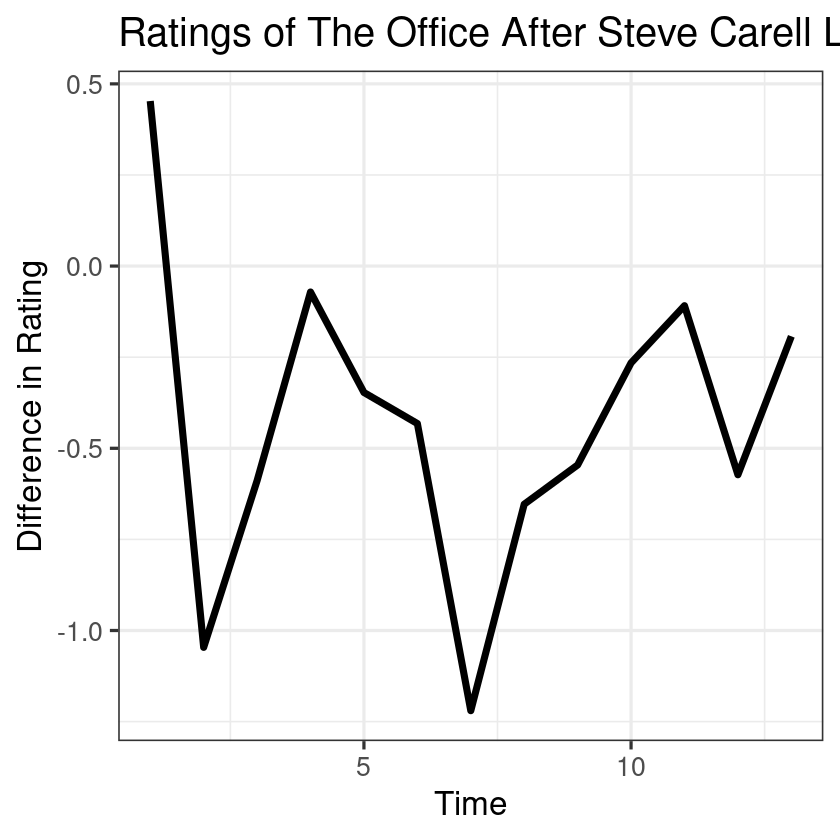

In [96]:
ratingChangeSeries

In [97]:
set.seed(2342342)

aThingy <- LAPIS_with_rank_estimation(Y=Y, W=D,
                           initial_rank=100, tolerance=1e-03, 
                           min_iter=10, max_iter=1000, 
                           mu_grid=c(10^seq(-4,2,1),
                           seq(2,5,1)),
                           warm_start=F, 
                           method='non_explicit_tau',change_memory_length=30,
                           minimum_change=30,
                           num_folds=6)

In [98]:
#ratingChangeSeries <- ggplot(NULL, aes(x=1:length(aThingy), y=aThingy))+geom_line(lwd=2)+
#theme_bw(base_size=20) + xlab('Time') + ylab('Difference in Rating') + 
#ggtitle("Ratings of The Office After Steve Carell Left")

In [99]:
set.seed(2342342)
#set.seed(23742)
withMu <- completion_with_rank_estimation_validate_mu(Y=Y, W=D, 
    initial_rank=50, tolerance=1e-03, 
            min_iter=100,max_iter=1000,mu_grid=c(10^seq(-4,2,1),
                           seq(2,5,1)),
                                                K=3)

In [100]:
withMu$rank_estimate

[1] 50

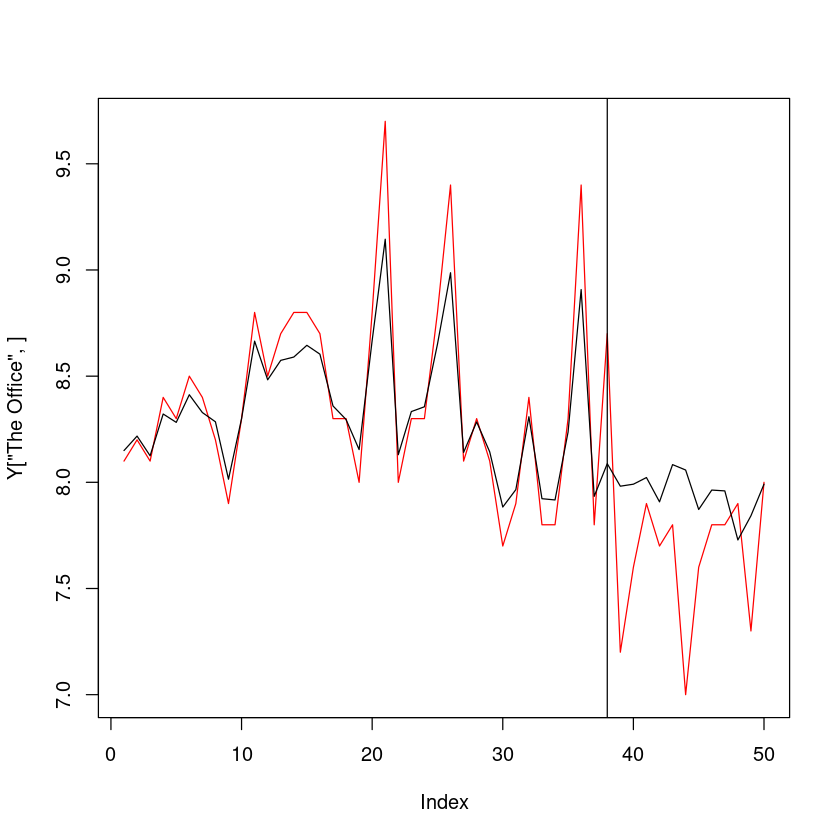

In [101]:

plot(Y['The Office', ], type='l', col='red')
lines(withMu$L_hat['The Office', ], type='l')
abline(v=38)

In [102]:
treatVsControlData <- cbind.data.frame(
    rep(c("Observed", "Estimated Untreated Counterfactual"), each=50 ) , 
c(Y['The Office', ], 
                                         withMu$L_hat['The Office', ]),
rep(1:50, 2))





In [103]:
names(treatVsControlData) <- c('Observation', 'Rating', 'episode_indicator')

In [104]:
(treatVsControlData %>% filter((Observation=='Observed') &
                             (episode_indicator <= 38)))$Rating

[1] 8.1 8.2 8.1 8.4 8.3 8.5 8.4 8.2 7.9 8.3 8.8 8.5 8.7 8.8 8.8 8.7 8.3 8.3 8.0
[20] 8.8 9.7 8.0 8.3 8.3 8.8 9.4 8.1 8.3 8.1 7.7 7.9 8.4 7.8 7.8 8.3 9.4 7.8 8.7

In [105]:
treatVsControlData <- treatVsControlData %>% 
mutate(episode_indicator = rep(1:50, times=2))

In [106]:
whatIWant <- (treatVsControlData %>% filter((Observation=='Observed') &
                             (episode_indicator <= 38)))$Rating

In [107]:
treatVsControlData[(treatVsControlData$Observation=='Estimated Untreated Counterfactual') 
                   &(treatVsControlData$episode_indicator <= 38),]$Rating <- whatIWant


In [108]:
officeIfMichaelNoLeave <- ggplot(treatVsControlData %>% filter(Observation=='Observed'),
      aes(x=episode_indicator, y=Rating)) + 
geom_line(color=c(rep('black', 37), rep('red', 13)), lwd=1.25) + 
geom_line(data=treatVsControlData %>% filter(
    (Observation=="Estimated Untreated Counterfactual") & (episode_indicator >= 38) ),
         aes(x=episode_indicator, y=Rating), color='black', lty=4, lwd=1.25) + 
xlab('Time') + ylab('Average IMDb Rating') + geom_vline(aes(xintercept=38), color='blue', lwd=1.25) + 
theme_bw(base_size=20) + ggtitle("Ratings for The Office (American Version)")


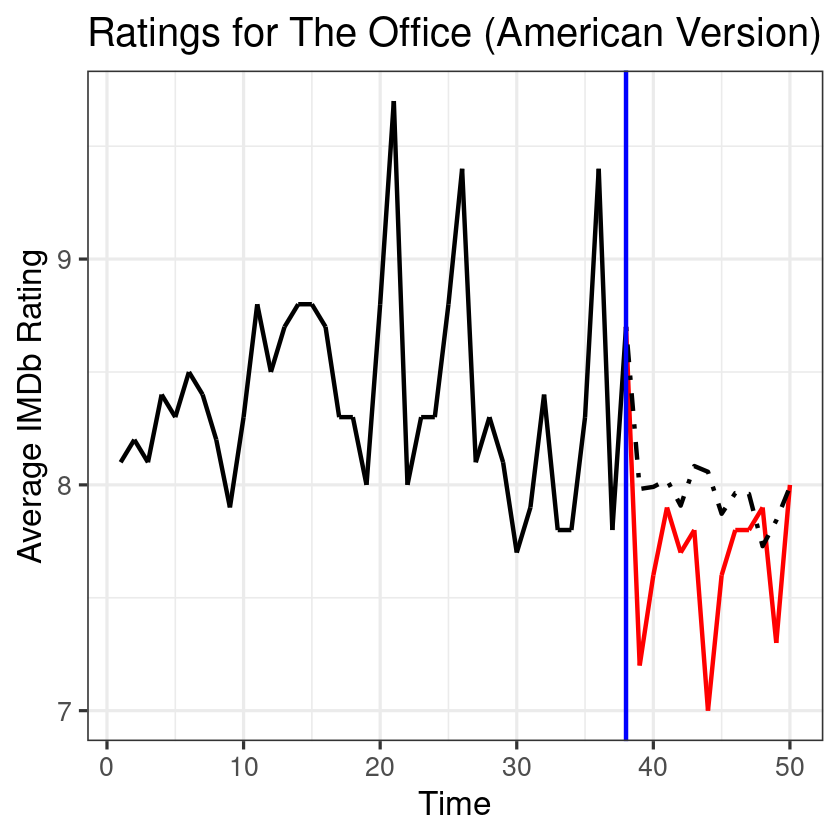

In [109]:
officeIfMichaelNoLeave

In [110]:
ggsave('Office Ratings (with Michael Leaving).pdf', officeIfMichaelNoLeave, width=11, height=8.5)

# Traditional Forecasting for Talk

In [111]:
officeSeries = ts(Y['The Office',], frequency=1)

In [112]:
trainOfficeSeries <- window(officeSeries, start=1, end=44)
testOfficeSeries <- window(officeSeries, start=45)

In [113]:
officeArimaModel <- auto.arima(trainOfficeSeries)

In [114]:
ratingForecast <- forecast(officeArimaModel, h=length(testOfficeSeries))

In [115]:
traditionalTimeSeriesVisual <- autoplot(ratingForecast,  predict.size = 1.25, size = 1.25) + 
geom_line(inherit.aes=FALSE, aes(x=as.numeric(time(testOfficeSeries )), y=as.numeric(testOfficeSeries )), color='red')+
theme_bw(base_size=20) + ylab('Average IMDb Rating') + ggtitle("Ratings for The Office (American Version)")+
geom_line(lwd=1.25)+  scale_linetype_manual(values=2)

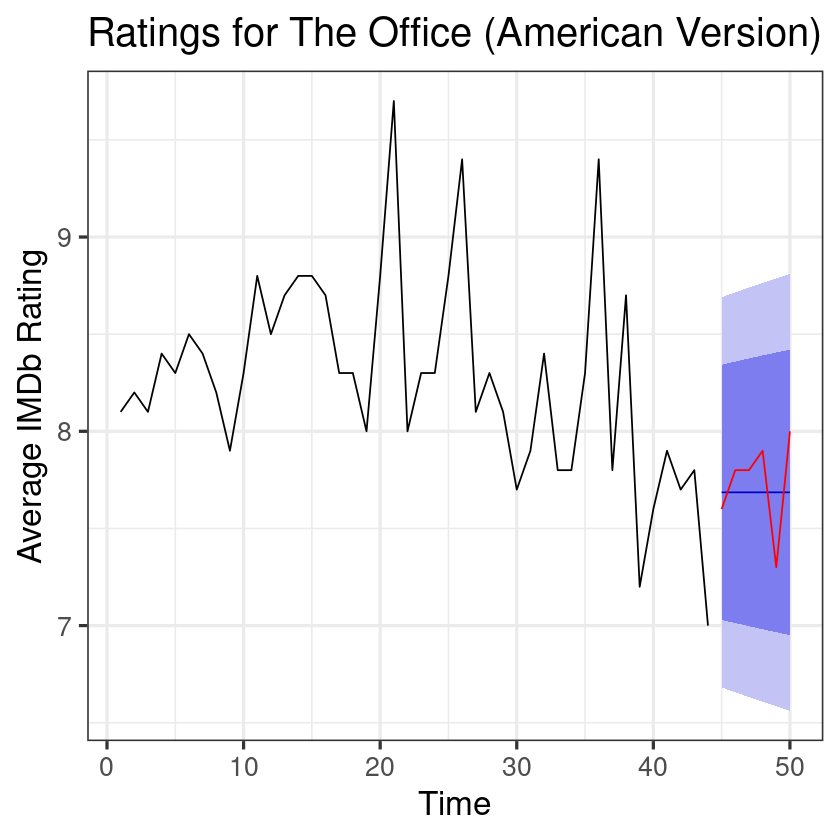

In [116]:
traditionalTimeSeriesVisual

In [133]:
if (!exists('./plots_and_tables')){
    
    
    dir.create('plots_and_tables')
}


ggsave('./plots_and_tables/Office Ratings.pdf', traditionalTimeSeriesVisual, 
       width=11, height=8.5)
ggsave('./plots_and_tables/ratings_after_michael_left.pdf', ratingChangeSeries, 
       width=11, height=8.5)
ggsave('./plots_and_tables/tv_rating_example.pdf', panelDataExample,  
       width=16, height=8.5)


ggsave('./plots_and_tables/mse_distribution_by_method.pdf', mseDistPlot,  
       width=8.5, height=10)

fileConn<-file('plots_and_tables/rating_error_table.txt')
writeLines(errorTableForLatex, fileConn)
close(fileConn)


Warning message in dir.create("plots_and_tables"):
“'plots_and_tables' already exists”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


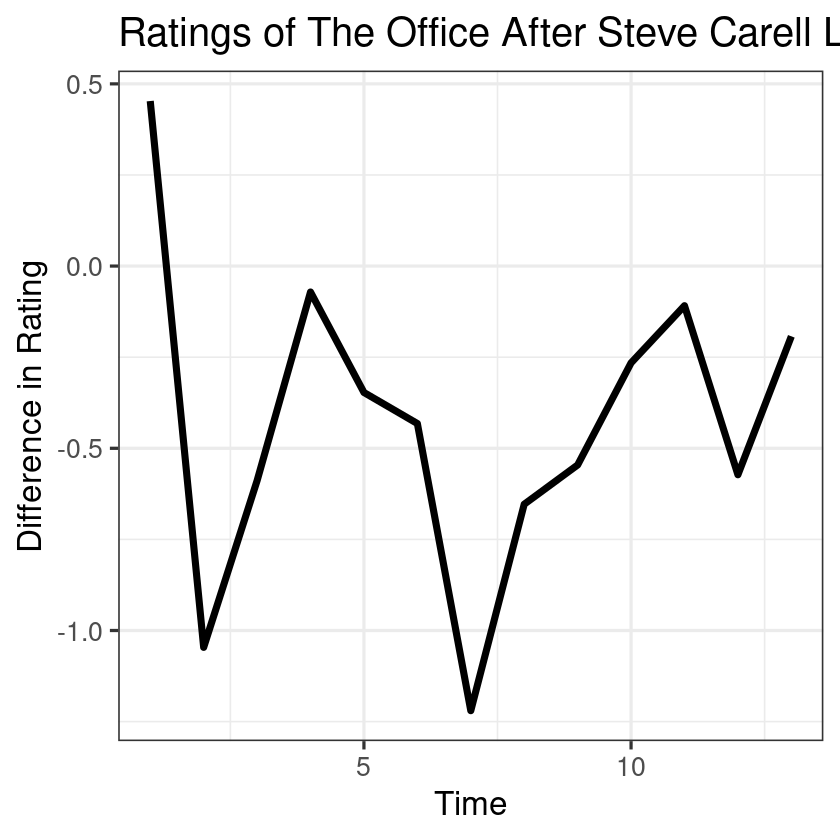

In [118]:
ratingChangeSeries